In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SVMSMOTE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import boxcox

<h1>Loading Dataset</h1>

In [2]:
# Read the CSV file
df = pd.read_csv('white_winequality.csv')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [3]:
# Check if each feature has negative or zero values
negative_or_zero_values = (df <= 0).any()

for feature, has_negative_or_zero in negative_or_zero_values.items():
    print(f"{feature}: {'Negative or zero' if has_negative_or_zero else 'All positive'}")

fixed acidity: All positive
volatile acidity: All positive
citric acid: Negative or zero
residual sugar: All positive
chlorides: All positive
free sulfur dioxide: All positive
total sulfur dioxide: All positive
density: All positive
pH: All positive
sulphates: All positive
alcohol: All positive
quality: All positive


In [4]:
summary = df.describe(include='all')

skewness = df.skew()

mode_values = df.mode().iloc[0]

summary.loc['skew'] = skewness
summary.loc['mode'] = mode_values

summary

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   
skew        0.647751          1.576980     1.281920        1.077094   
mode        6.800000          0.280000     0.300000        1.200000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.036000            23.000000            108.000000     0.991723   
50%       0.043000            34.000000            134.000000     0.993740   
75%       0.050000            46.000000            167.000000     0.996100   
max       0.346000           289.000000            440.000000     1.038980   
skew      5.023331             1.406745              0.390710     0.977773   
mode      0.044000            29.000000            111.000000     0.992000   

                pH    sulphates      alcohol      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean      3.188267     0.489847    10.514267     5.877909  
std       0.151001     0.114126     1.230621     0.885639  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.550000    11.400000     6.000000  
max       3.820000     1.080000    14.200000     9.000000  
skew      0.457783     0.977194     0.487342     0.155796  
mode      3.140000     0.500000     9.400000     6.000000

<h1>Correlation Before Log Transformation</h1>

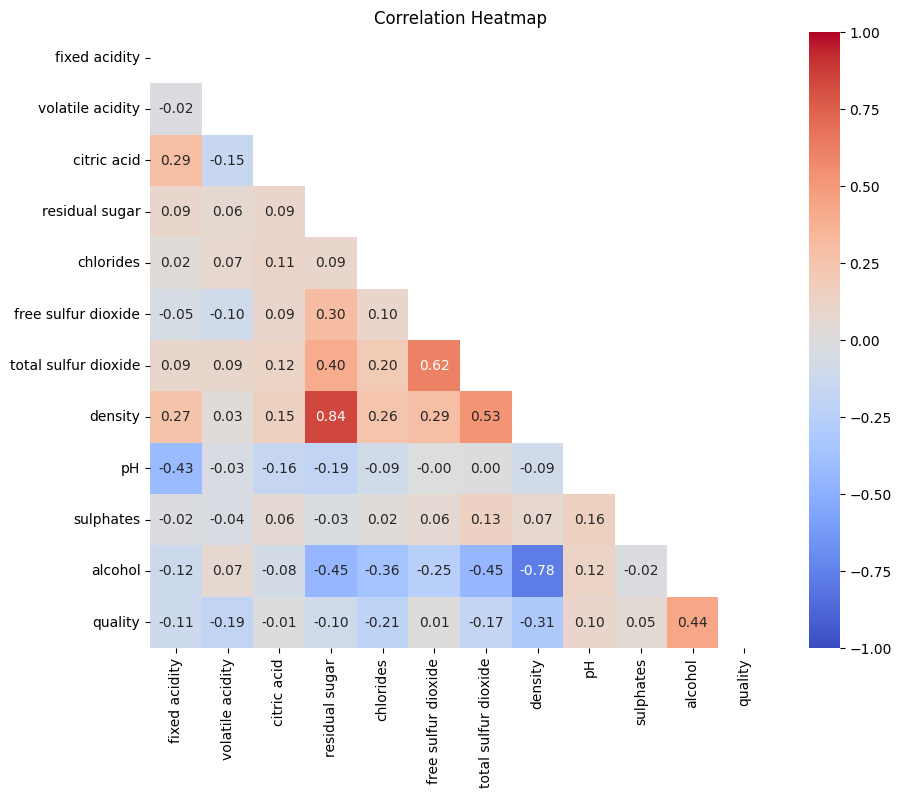

In [5]:
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<h1>Log Transformation</h1>

In [6]:
target_column = 'quality'
target = df[target_column]

exclude_columns = ['citric acid']
features = df.drop([target_column] + exclude_columns, axis=1)

# Log-transform the selected features
log_transformed_features = np.log10(features)

df = pd.concat([log_transformed_features, df[exclude_columns], target], axis=1)

df.head(10)

fixed acidity  volatile acidity  residual sugar  chlorides  \
0       0.845098         -0.568636        1.315970  -1.346787   
1       0.799341         -0.522879        0.204120  -1.309804   
2       0.908485         -0.552842        0.838849  -1.301030   
3       0.857332         -0.638272        0.929419  -1.236572   
4       0.857332         -0.638272        0.929419  -1.236572   
5       0.908485         -0.552842        0.838849  -1.301030   
6       0.792392         -0.494850        0.845098  -1.346787   
7       0.845098         -0.568636        1.315970  -1.346787   
8       0.799341         -0.522879        0.204120  -1.309804   
9       0.908485         -0.657577        0.176091  -1.356547   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             1.653213              2.230449  0.000434  0.477121  -0.346787   
1             1.146128              2.120574 -0.002614  0.518514  -0.309804   
2             1.477121              1.986772 -0.002133  0.513218  -0.356547   
3             1.672098              2.269513 -0.001915  0.503791  -0.397940   
4             1.672098              2.269513 -0.001915  0.503791  -0.397940   
5             1.477121              1.986772 -0.002133  0.513218  -0.356547   
6             1.477121              2.133539 -0.002221  0.502427  -0.327902   
7             1.653213              2.230449  0.000434  0.477121  -0.346787   
8             1.146128              2.120574 -0.002614  0.518514  -0.309804   
9             1.447158              2.110590 -0.002701  0.507856  -0.346787   

    alcohol  citric acid  quality  
0  0.944483         0.36        6  
1  0.977724         0.34        6  
2  1.004321         0.40        6  
3  0.995635         0.32        6  
4  0.995635         0.32        6  
5  1.004321         0.40        6  
6  0.982271         0.16        6  
7  0.944483         0.36        6  
8  0.977724         0.34        6  
9  1.041393         0.43        6

<h1>Correlation After Log Transformation</h1>

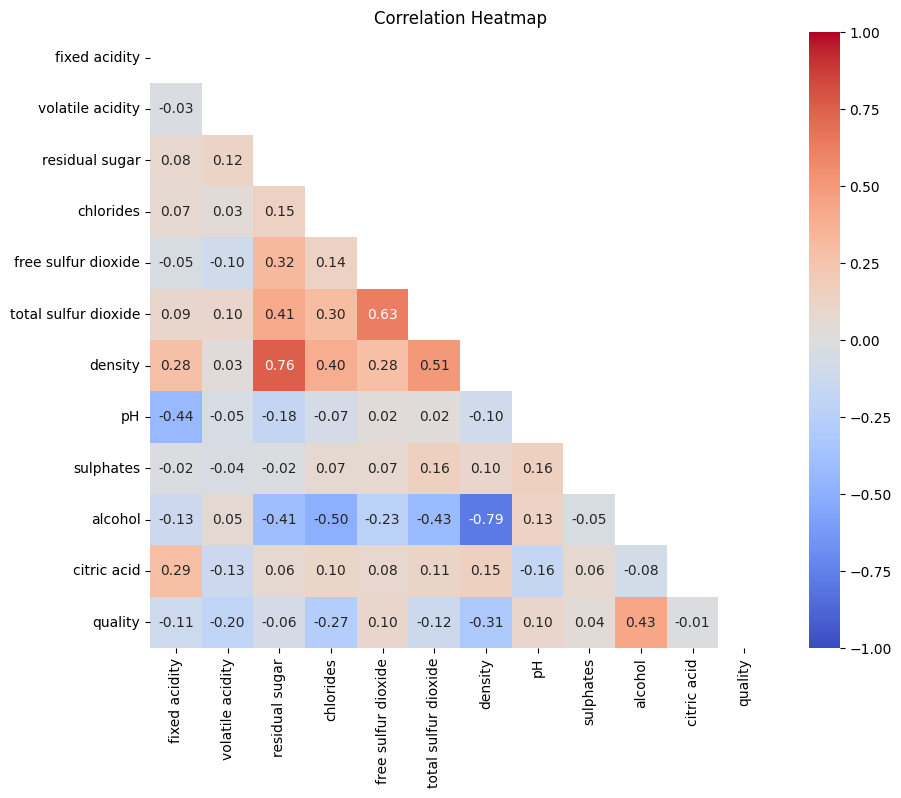

In [7]:
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<h1>Statistical Summary of the Dataset</h1>

In [8]:
summary = df.describe(include='all')

skewness = df.skew()

mode_values = df.mode().iloc[0]

summary.loc['skew'] = skewness
summary.loc['mode'] = mode_values

summary

fixed acidity  volatile acidity  residual sugar    chlorides  \
count    4898.000000       4898.000000     4898.000000  4898.000000   
mean        0.832772         -0.580901        0.643159    -1.367598   
std         0.052790          0.146860        0.400309     0.143851   
min         0.579784         -1.096910       -0.221849    -2.045757   
25%         0.799341         -0.677781        0.230449    -1.443697   
50%         0.832509         -0.585027        0.716003    -1.366532   
75%         0.863323         -0.494850        0.995635    -1.301030   
max         1.152288          0.041393        1.818226    -0.460924   
skew        0.076851          0.139383       -0.161157     1.134134   
mode        0.832509         -0.552842        0.079181    -1.356547   

       free sulfur dioxide  total sulfur dioxide      density           pH  \
count          4898.000000           4898.000000  4898.000000  4898.000000   
mean              1.491737              2.118597    -0.002604     0.503073   
std               0.237790              0.145974     0.001305     0.020410   
min               0.301030              0.954243    -0.005634     0.434569   
25%               1.361728              2.033424    -0.003610     0.489958   
50%               1.531479              2.127105    -0.002727     0.502427   
75%               1.662758              2.222716    -0.001697     0.515874   
max               2.460898              2.643453     0.016607     0.582063   
skew             -0.936322             -0.984216     0.930942     0.298823   
mode              1.462398              2.045323    -0.003488     0.496930   

         sulphates      alcohol  citric acid      quality  
count  4898.000000  4898.000000  4898.000000  4898.000000  
mean     -0.321008     1.018875     0.334192     5.877909  
std       0.097192     0.049958     0.121020     0.885639  
min      -0.657577     0.903090     0.000000     3.000000  
25%      -0.387216     0.977724     0.270000     5.000000  
50%      -0.327902     1.017033     0.320000     6.000000  
75%      -0.259637     1.056905     0.390000     6.000000  
max       0.033424     1.152288     1.660000     9.000000  
skew      0.233757     0.310135     1.281920     0.155796  
mode     -0.301030     0.973128     0.300000     6.000000

<h1>Column Names and their Data Types</h1>

In [9]:
dataset_columns = pd.DataFrame({'column_names':list(df.columns)})

data_types = []
for column in df.columns:
    dtype = str(df[column].dtype)
    data_types.append(dtype)

dataset_columns['data_type'] = data_types
dataset_columns

column_names data_type
0          fixed acidity   float64
1       volatile acidity   float64
2         residual sugar   float64
3              chlorides   float64
4    free sulfur dioxide   float64
5   total sulfur dioxide   float64
6                density   float64
7                     pH   float64
8              sulphates   float64
9                alcohol   float64
10           citric acid   float64
11               quality     int64

<h1>Checking Missing Values</h1>

In [10]:
missing_values = df.isnull().sum()
print(missing_values)

fixed acidity           0
volatile acidity        0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
citric acid             0
quality                 0
dtype: int64


<h1>Check for duplicate entries</h1>

In [11]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

fixed acidity  volatile acidity  residual sugar  chlorides  \
4          0.857332         -0.638272        0.929419  -1.236572   
5          0.908485         -0.552842        0.838849  -1.301030   
7          0.845098         -0.568636        1.315970  -1.346787   
8          0.799341         -0.522879        0.204120  -1.309804   
20         0.792392         -0.180456        0.079181  -1.537602   
...             ...               ...             ...        ...   
4828       0.806180         -0.638272        1.012837  -1.376751   
4850       0.845098         -0.443697        0.397940  -1.318759   
4851       0.806180         -0.481486        0.949390  -1.259637   
4856       0.851258         -0.638272        1.136721  -1.236572   
4880       0.819544         -0.468521        0.908485  -1.337242   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
4                1.672098              2.269513 -0.001915  0.503791   
5                1.477121              1.986772 -0.002133  0.513218   
7                1.653213              2.230449  0.000434  0.477121   
8                1.146128              2.120574 -0.002614  0.518514   
20               1.462398              1.875061 -0.004716  0.522444   
...                   ...                   ...       ...       ...   
4828             1.732394              2.146128 -0.001436  0.509203   
4850             1.826075              2.206826 -0.003725  0.484300   
4851             1.716003              2.214844 -0.002229  0.491362   
4856             1.414973              2.235528 -0.001065  0.462398   
4880             1.832509              2.230449 -0.002203  0.498311   

      sulphates   alcohol  citric acid  quality  
4     -0.397940  0.995635         0.32        6  
5     -0.356547  1.004321         0.40        6  
7     -0.346787  0.944483         0.36        6  
8     -0.309804  0.977724         0.34        6  
20    -0.408935  1.107210         0.48        8  
...         ...       ...          ...      ...  
4828  -0.327902  0.963788         0.35        5  
4850  -0.251812  1.045323         0.35        6  
4851  -0.318759  0.982271         0.44        5  
4856  -0.337242  0.954243         0.39        6  
4880  -0.301030  0.979245         0.40        6  

[937 rows x 12 columns]

In [12]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

Empty DataFrame
Columns: [fixed acidity, volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, citric acid, quality]
Index: []

In [14]:
def outlier_info(df):
    quantile_75 = []
    quantile_25 = []
    inter_quantile_range = []
    minimum_value = []
    maximum_value = []
    number_of_outliers = []
    percentage_of_outliers = []
    numeric_df = df.select_dtypes(np.number)
    
    for column in numeric_df.columns:
        q75, q25 = np.percentile(df[column], [75, 25])
        quantile_75.append(q75)
        quantile_25.append(q25)
        iqr = q75 - q25
        inter_quantile_range.append(iqr)
        min_value = q25 - (iqr * 1.5)
        minimum_value.append(min_value)
        max_value = q75 + (iqr * 1.5)
        maximum_value.append(max_value)
        outlier_count = len(np.where((df[column] > max_value) | (df[column] < min_value))[0])
        number_of_outliers.append(outlier_count)
        outlier_percent = round(outlier_count/len(df[column])*100, 2)
        percentage_of_outliers.append(outlier_percent)
        
    outliers_summary = pd.DataFrame(
        {
            'Number of Outliers' : number_of_outliers,
            'Outliers Percentage' : percentage_of_outliers,
            '75% Quantile' : quantile_75,
            '25% Quantile' : quantile_25,
            'Inter Quantile Range' : inter_quantile_range,
            'Maximum Value' : maximum_value,
            'Minimum Value' : minimum_value,
        }
    ).T
    
    outliers_summary.columns = numeric_df.columns.values
    
    return outliers_summary

In [15]:
outliers = outlier_info(df)

In [16]:
outliers

fixed acidity  volatile acidity  residual sugar  \
Number of Outliers       108.000000         51.000000        0.000000   
Outliers Percentage        2.730000          1.290000        0.000000   
75% Quantile               0.863323         -0.481486        0.949390   
25% Quantile               0.799341         -0.677781        0.204120   
Inter Quantile Range       0.063982          0.196295        0.745270   
Maximum Value              0.959296         -0.187044        2.067295   
Minimum Value              0.703367         -0.972223       -0.913785   

                       chlorides  free sulfur dioxide  total sulfur dioxide  \
Number of Outliers    180.000000           127.000000             51.000000   
Outliers Percentage     4.540000             3.210000              1.290000   
75% Quantile           -1.301030             1.653213              2.220108   
25% Quantile           -1.455932             1.361728              2.025306   
Inter Quantile Range    0.154902             0.291485              0.194802   
Maximum Value          -1.068677             2.090440              2.512311   
Minimum Value          -1.688285             0.924501              1.733103   

                       density         pH  sulphates   alcohol  citric acid  \
Number of Outliers    6.000000  43.000000  41.000000  0.000000       223.00   
Outliers Percentage   0.150000   1.090000   1.040000  0.000000         5.63   
75% Quantile         -0.001867   0.517196  -0.259637  1.056905         0.39   
25% Quantile         -0.003655   0.489958  -0.387216  0.977724         0.27   
Inter Quantile Range  0.001788   0.027237   0.127579  0.079181         0.12   
Maximum Value         0.000814   0.558052  -0.068269  1.175677         0.57   
Minimum Value        -0.006336   0.449102  -0.578584  0.858952         0.09   

                      quality  
Number of Outliers     156.00  
Outliers Percentage      3.94  
75% Quantile             6.00  
25% Quantile             5.00  
Inter Quantile Range     1.00  
Maximum Value            7.50  
Minimum Value            3.50

In [17]:
total_number_of_outliers = outliers.loc['Number of Outliers', :].sum()

print(f'The total number of outliers after log transformation is: {total_number_of_outliers}')

The total number of outliers after log transformation is: 986.0


In [18]:
def detect_outliers(
    df, 
    xticklabels_fontsize=12, 
    yticklabels_fontsize=12, 
    title_fontsize=22, 
    boxplot_xlabel_fontsize=12, 
):
   
    for i, column in enumerate(df.columns):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), clear=False)
        
        
        df[column].hist(bins=30, ax=ax1)
        
        ax = sns.boxplot(x=column, data=df, ax=ax2)
        ax = sns.stripplot(x=column, data=df, color="maroon", jitter=0.2, size=2.5)
        
        
        ax1.set_title('Distribution of ' + column, fontsize=title_fontsize)
        ax2.set_title('Boxplot of ' + column, fontsize=title_fontsize)
        
        
        
        plt.setp(ax1.get_xticklabels(), fontsize=xticklabels_fontsize)
        plt.setp(ax1.get_yticklabels(), fontsize=yticklabels_fontsize)
        
        plt.setp(ax2.get_xticklabels(), fontsize=xticklabels_fontsize)
        ax2.set_xlabel(ax2.get_xlabel(), fontsize=boxplot_xlabel_fontsize)
        
        plt.grid(axis='both', color='black', linewidth=0.5)
        
        fig.tight_layout()

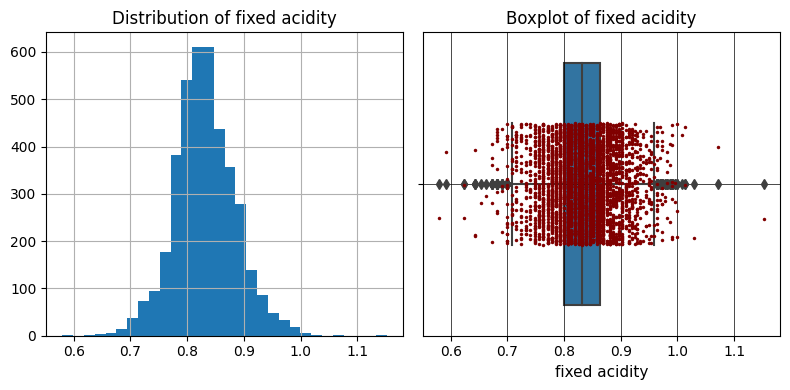

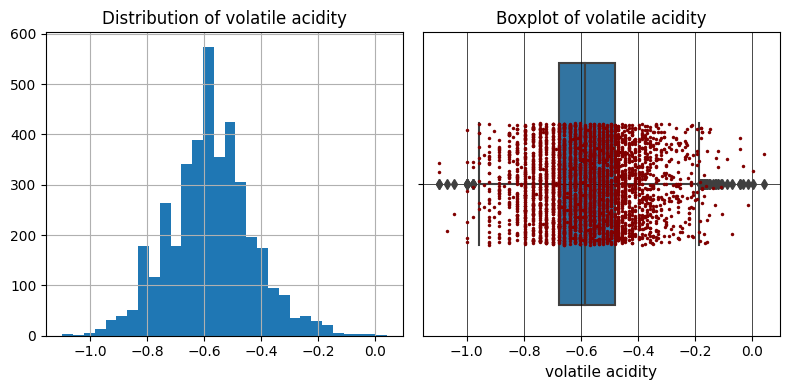

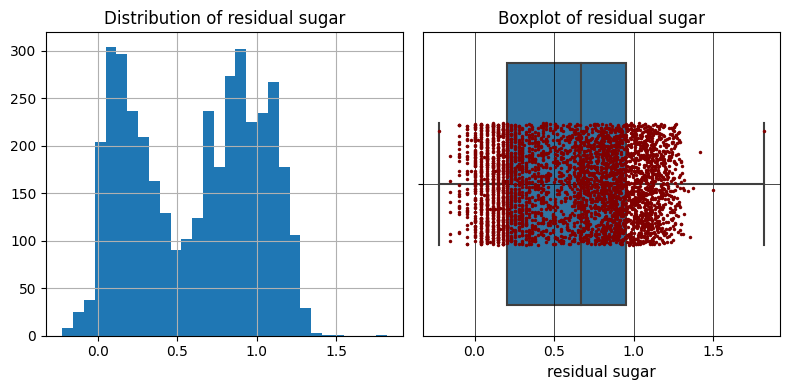

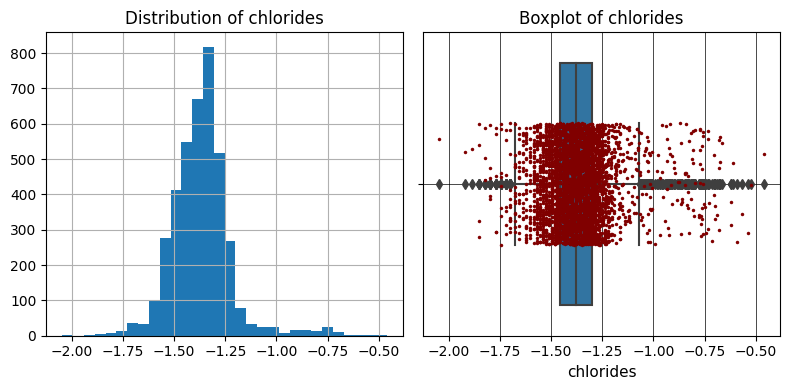

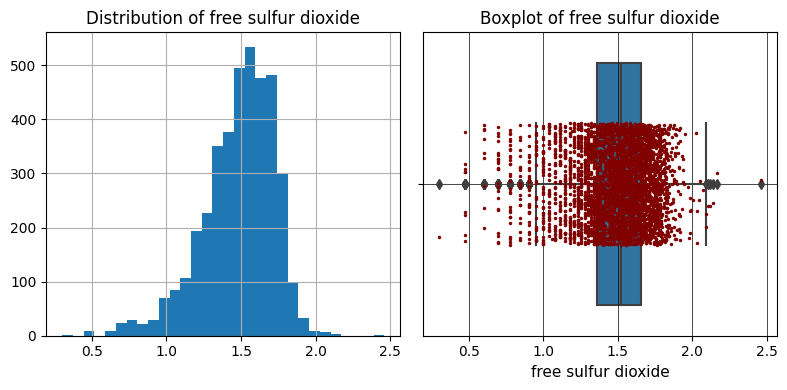

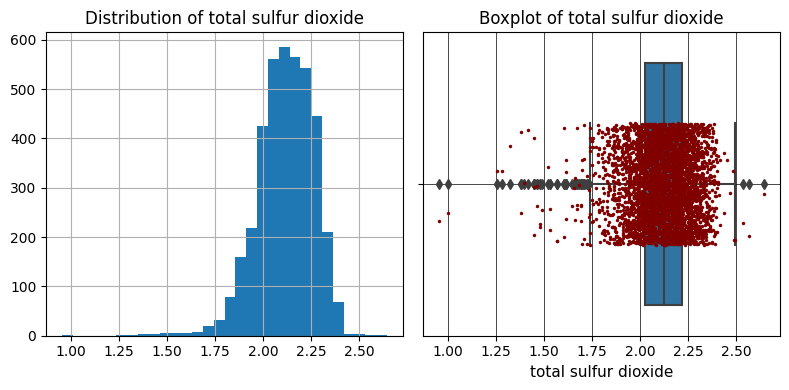

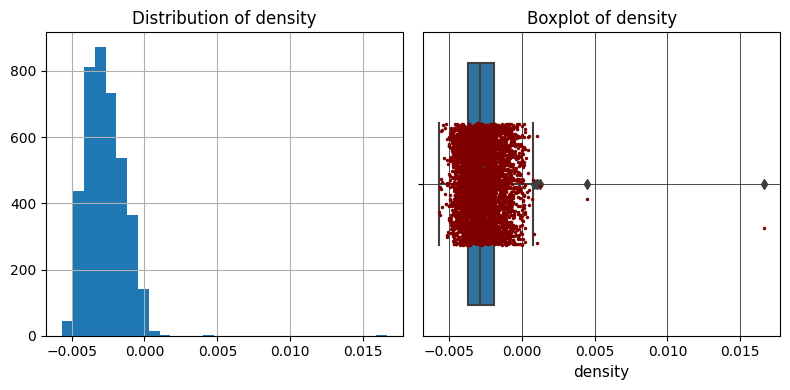

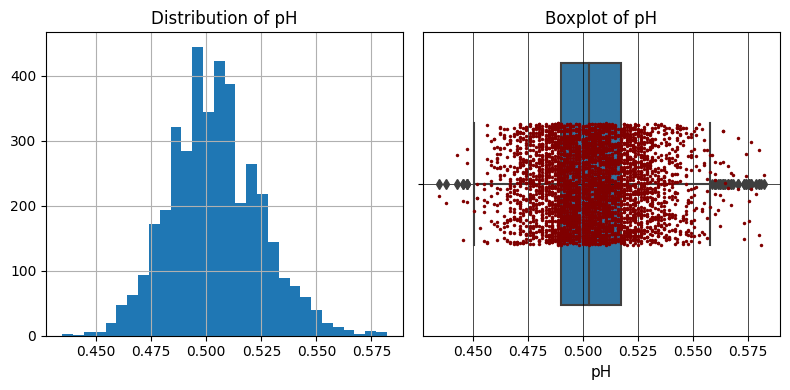

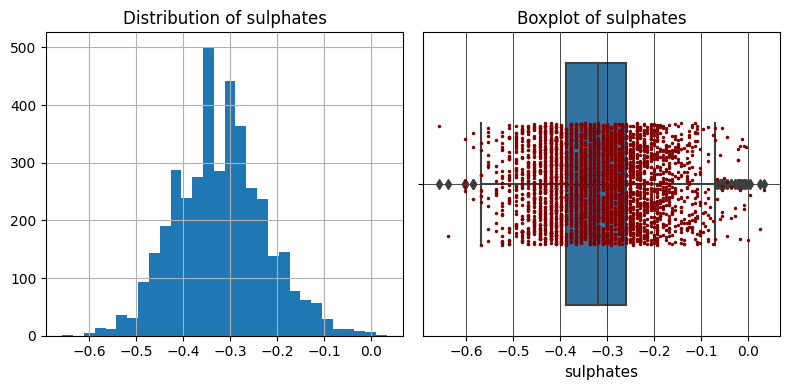

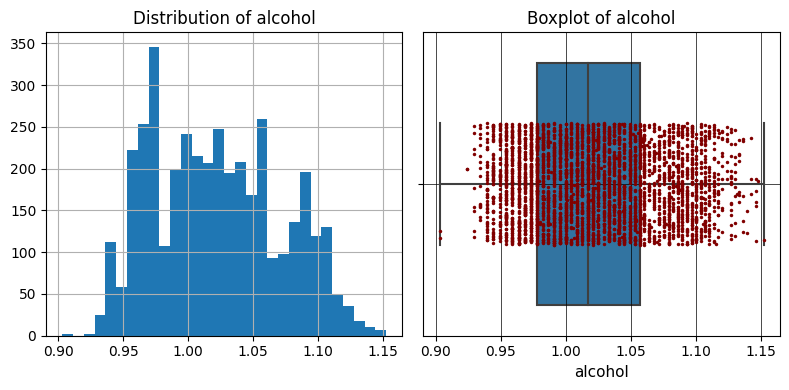

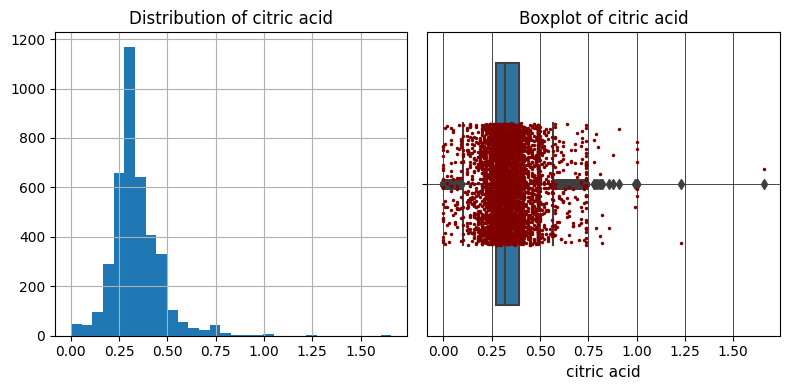

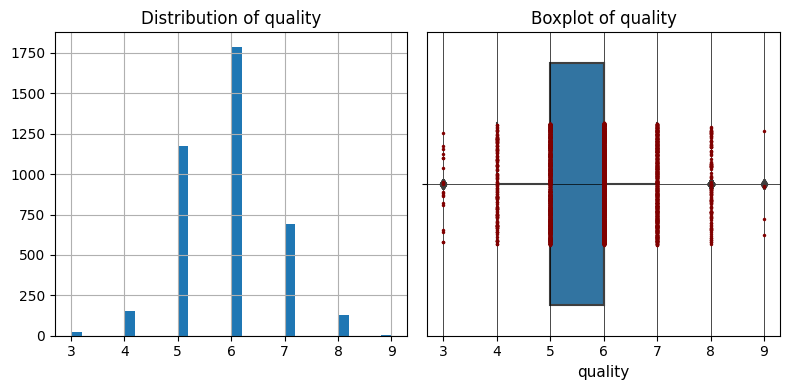

In [19]:
detect_outliers(
    df.select_dtypes(np.number),
    xticklabels_fontsize=10, 
    yticklabels_fontsize=10, 
    title_fontsize=12, 
    boxplot_xlabel_fontsize=11, 
)

<h1>Correlation of Dataset Features after Log and Dropping Duplicates</h1>

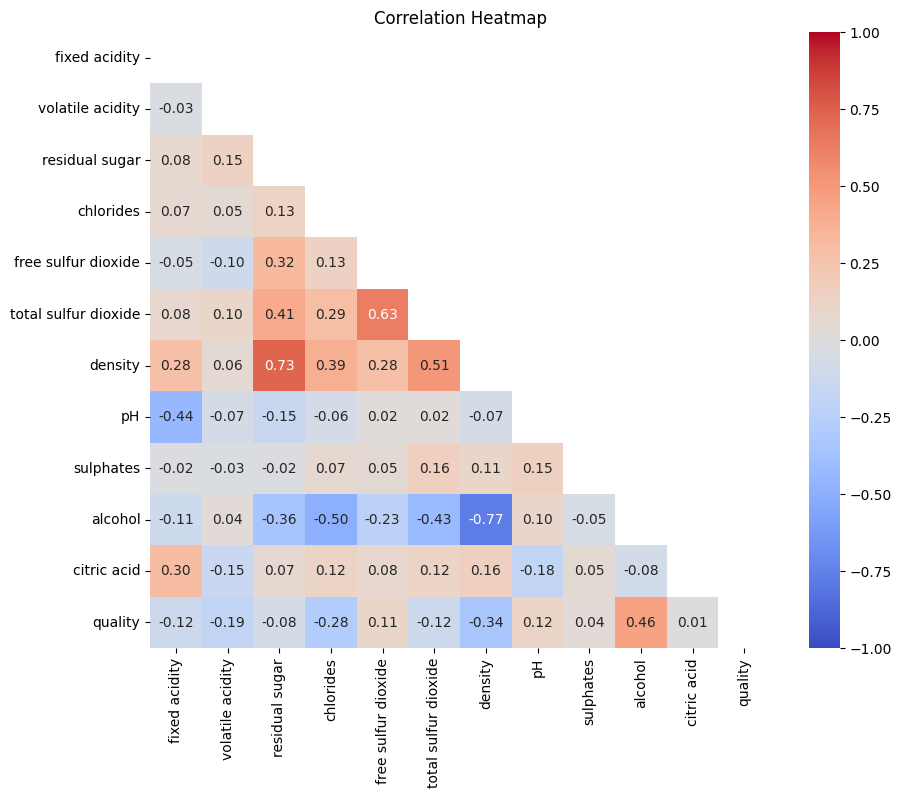

In [20]:
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

<h1>Distribution Plot of Target Variable</h1>

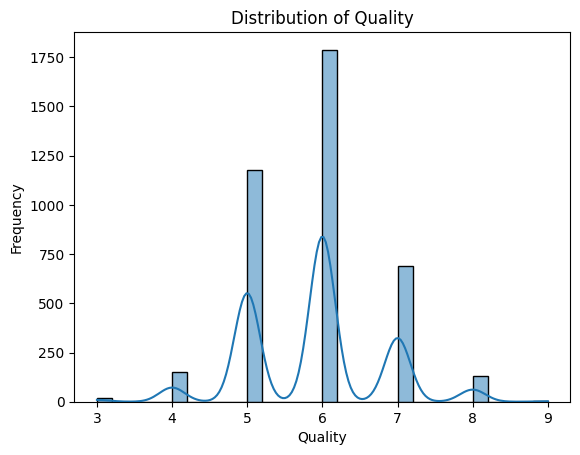

In [21]:
y = df['quality']
sns.histplot(y, kde=True, bins=30)  # KDE (Kernel Density Estimate) for smoothness
plt.title('Distribution of Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

<h1>Count Plot of Target Variable</h1>

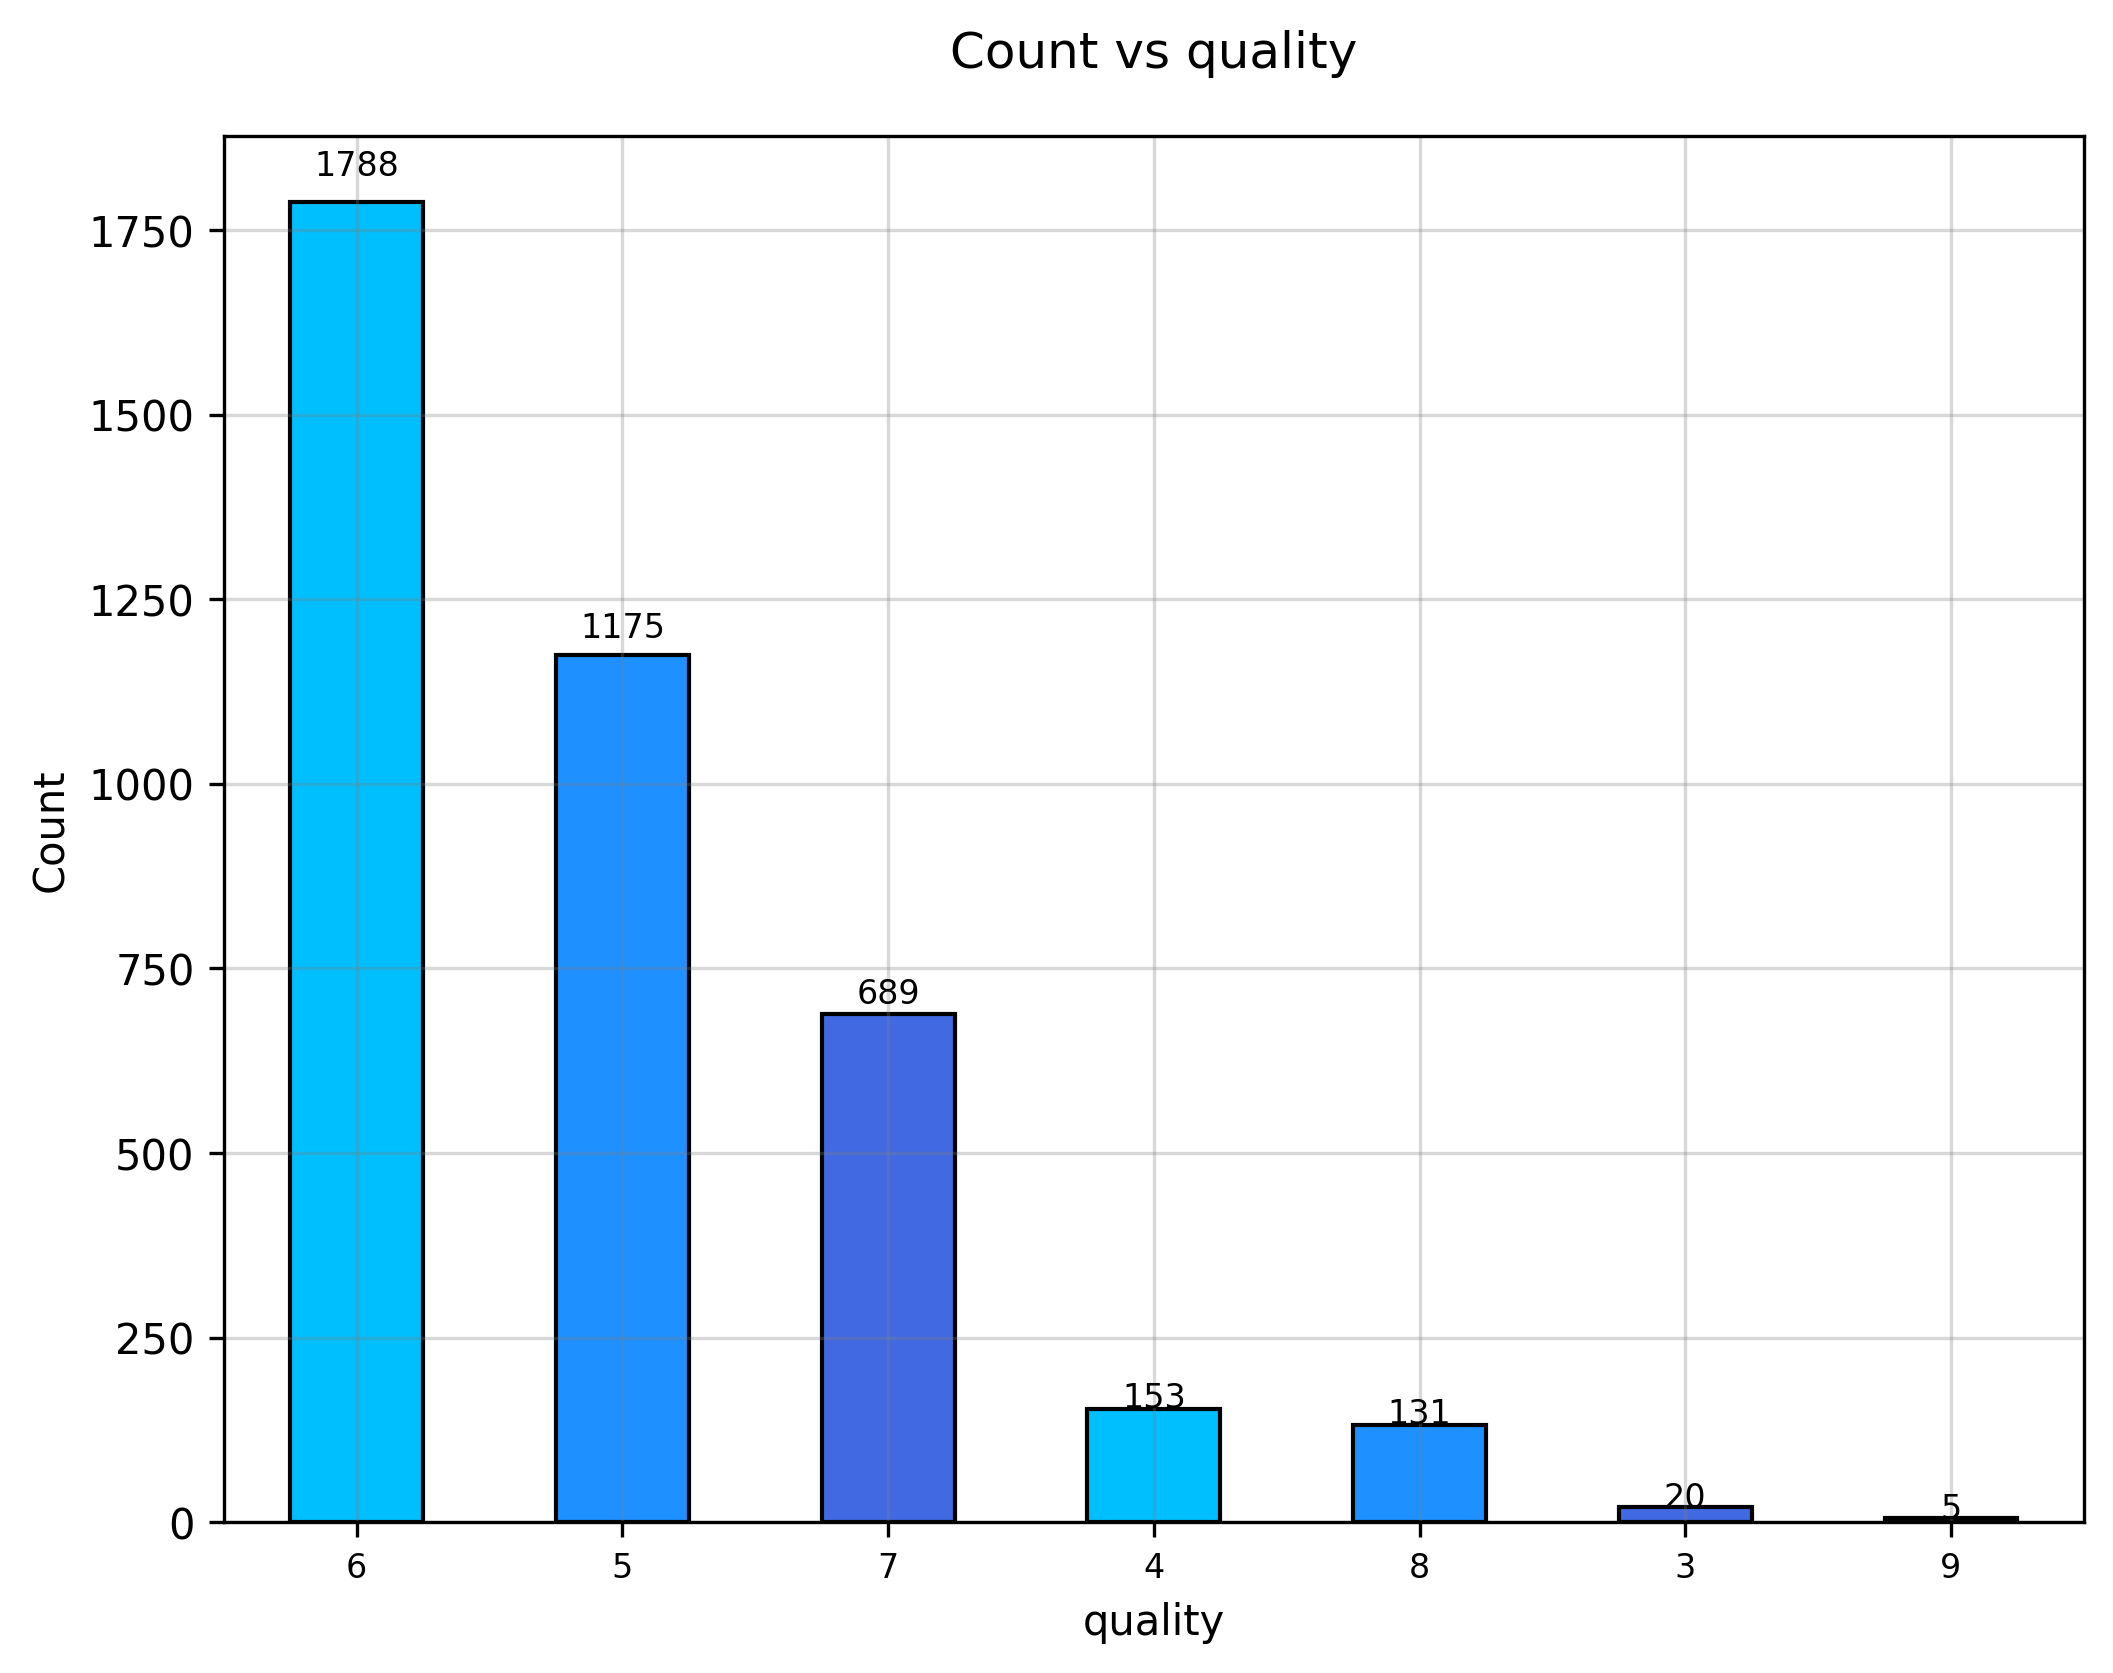

In [22]:
def count_plot(column_name):

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    value_counts = df[column_name].value_counts()

    ax = value_counts.plot(
        kind='bar', 
        rot=0, 
        color=['deepskyblue', 'dodgerblue', 'royalblue'], 
        edgecolor='black', 
        linewidth=1,
    )
    
    plt.title(f'Count vs {column_name}', fontsize=12, pad=16.5)
    plt.ylabel('Count', fontsize=10)

    for patch, count in zip(ax.patches, value_counts):
        width = patch.get_width()
        height = patch.get_height()
        x, y = patch.get_xy()
        ax.annotate(f'{count}', (x + width/2, y + height*1.02), ha='center', fontsize=8)
    
    plt.xticks(fontsize=8)
    
    plt.grid(alpha=0.3, color='grey')
    
    plt.show()

# Example usage
count_plot('quality')


<h1>Convert quality to binary</h1>

In [23]:
df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

In [24]:
mean_value_of_quality = df['quality'].mean()

In [25]:
bins = (2, mean_value_of_quality, 9)
groups_name = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = groups_name)
df['quality'].unique()

#Now lets assign a labels to our quality variable
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])

In [26]:
df.head(10)

fixed acidity  volatile acidity  residual sugar  chlorides  \
0        0.845098         -0.568636        1.315970  -1.346787   
1        0.799341         -0.522879        0.204120  -1.309804   
2        0.908485         -0.552842        0.838849  -1.301030   
3        0.857332         -0.638272        0.929419  -1.236572   
6        0.792392         -0.494850        0.845098  -1.346787   
9        0.908485         -0.657577        0.176091  -1.356547   
10       0.908485         -0.568636        0.161368  -1.481486   
11       0.934498         -0.638272        0.623249  -1.455932   
12       0.897627         -0.744727        0.079181  -1.397940   
13       0.819544         -0.795880        0.176091  -1.356547   

    free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0              1.653213              2.230449  0.000434  0.477121  -0.346787   
1              1.146128              2.120574 -0.002614  0.518514  -0.309804   
2              1.477121              1.986772 -0.002133  0.513218  -0.356547   
3              1.672098              2.269513 -0.001915  0.503791  -0.397940   
6              1.477121              2.133539 -0.002221  0.502427  -0.327902   
9              1.447158              2.110590 -0.002701  0.507856  -0.346787   
10             1.041393              1.799341 -0.004014  0.475671  -0.251812   
11             1.230449              2.037426 -0.002308  0.496930  -0.275724   
12             1.204120              1.875061 -0.003488  0.502427  -0.200659   
13             1.681241              2.155336 -0.003839  0.549003  -0.283997   

     alcohol  citric acid  quality  
0   0.944483         0.36        1  
1   0.977724         0.34        1  
2   1.004321         0.40        1  
3   0.995635         0.32        1  
6   0.982271         0.16        1  
9   1.041393         0.43        1  
10  1.079181         0.41        0  
11  0.986772         0.40        0  
12  1.033424         0.37        0  
13  1.093422         0.40        1

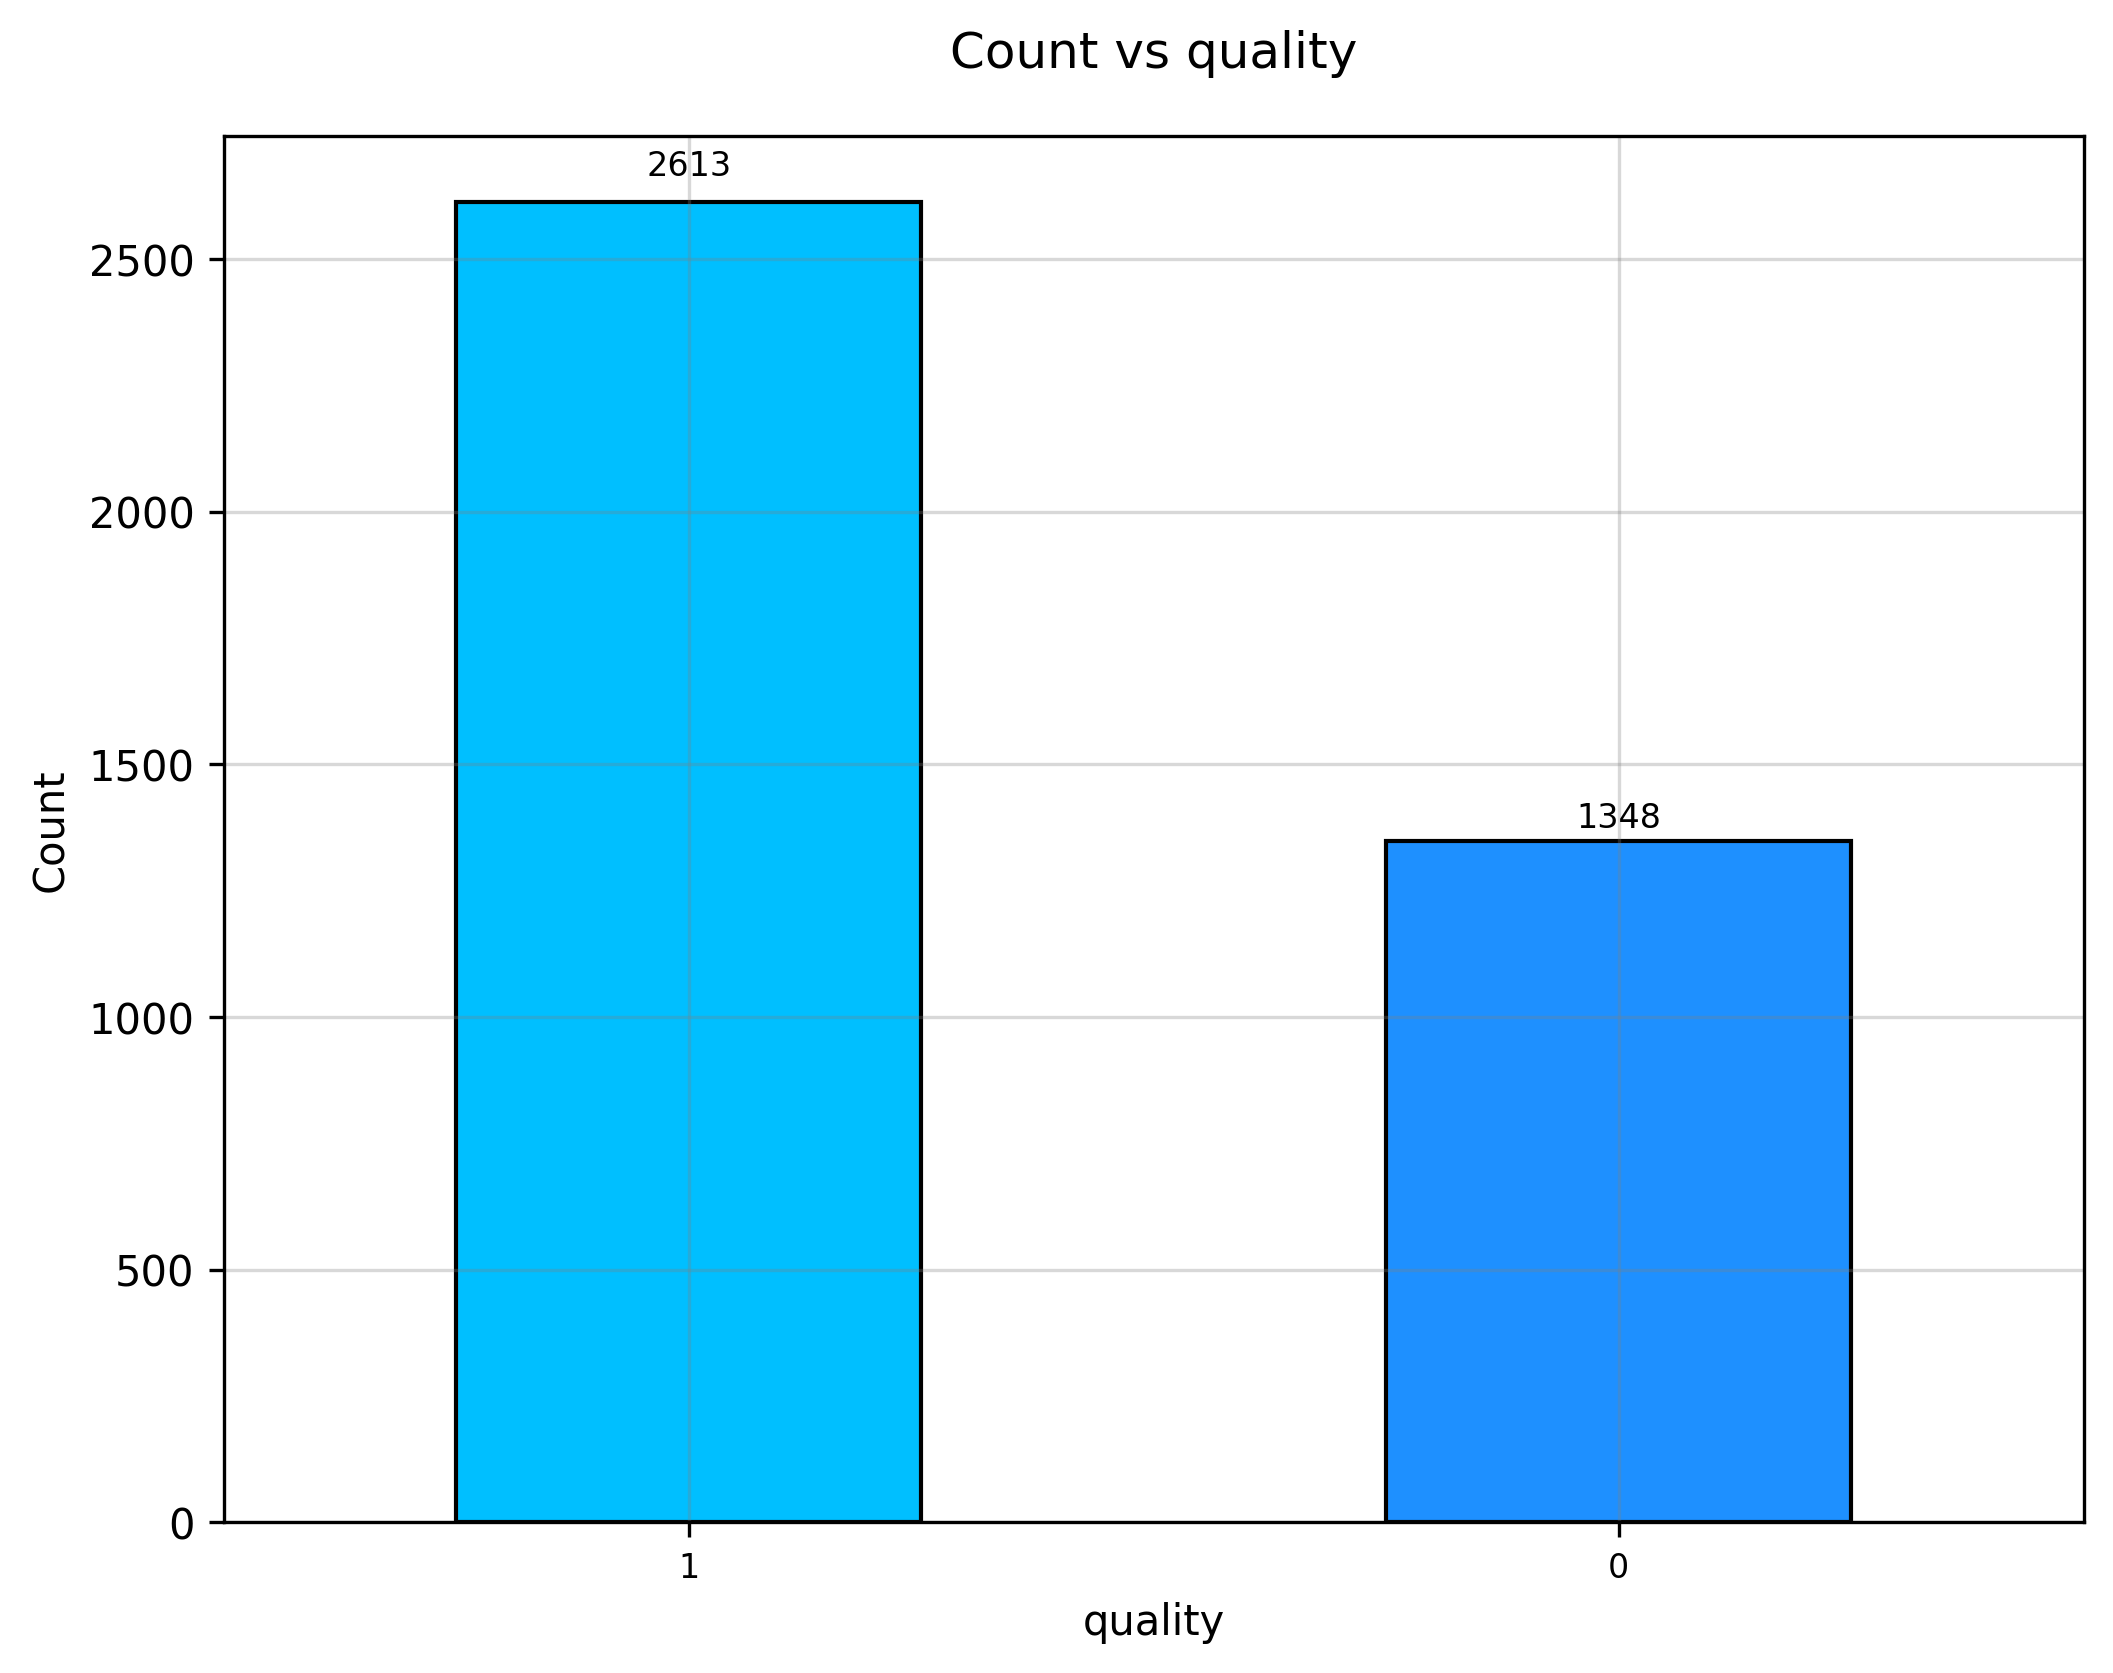

In [27]:
count_plot('quality')

<h1>Feature Statistics per target variable</h1>

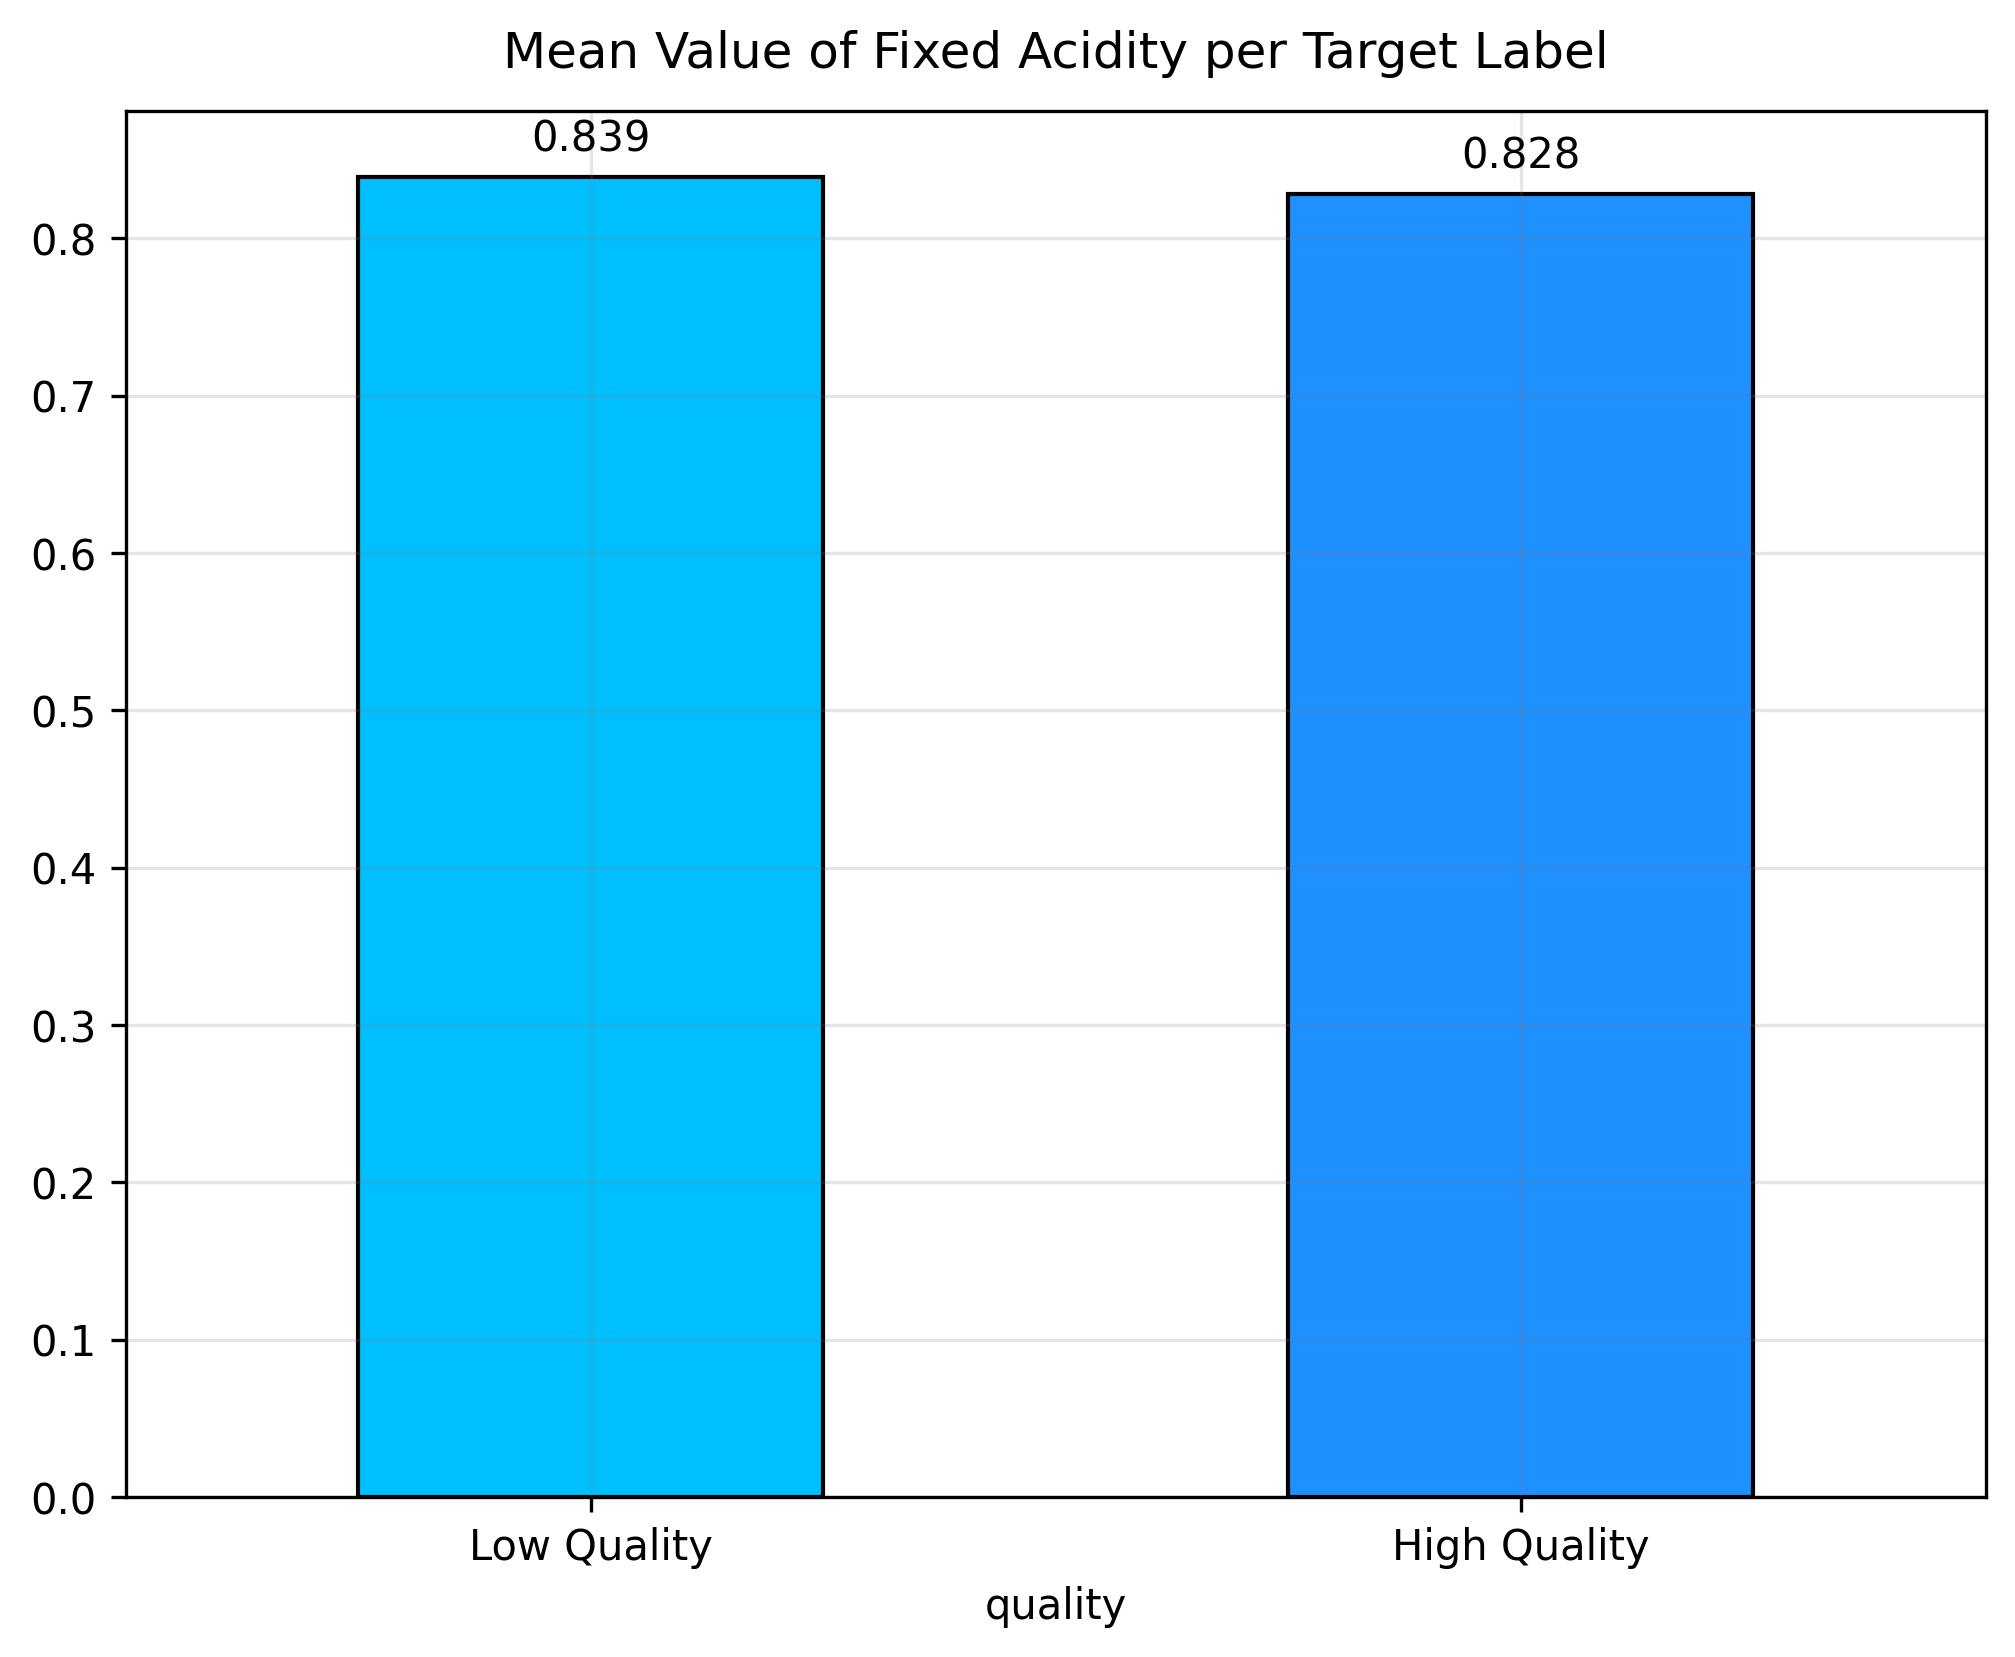

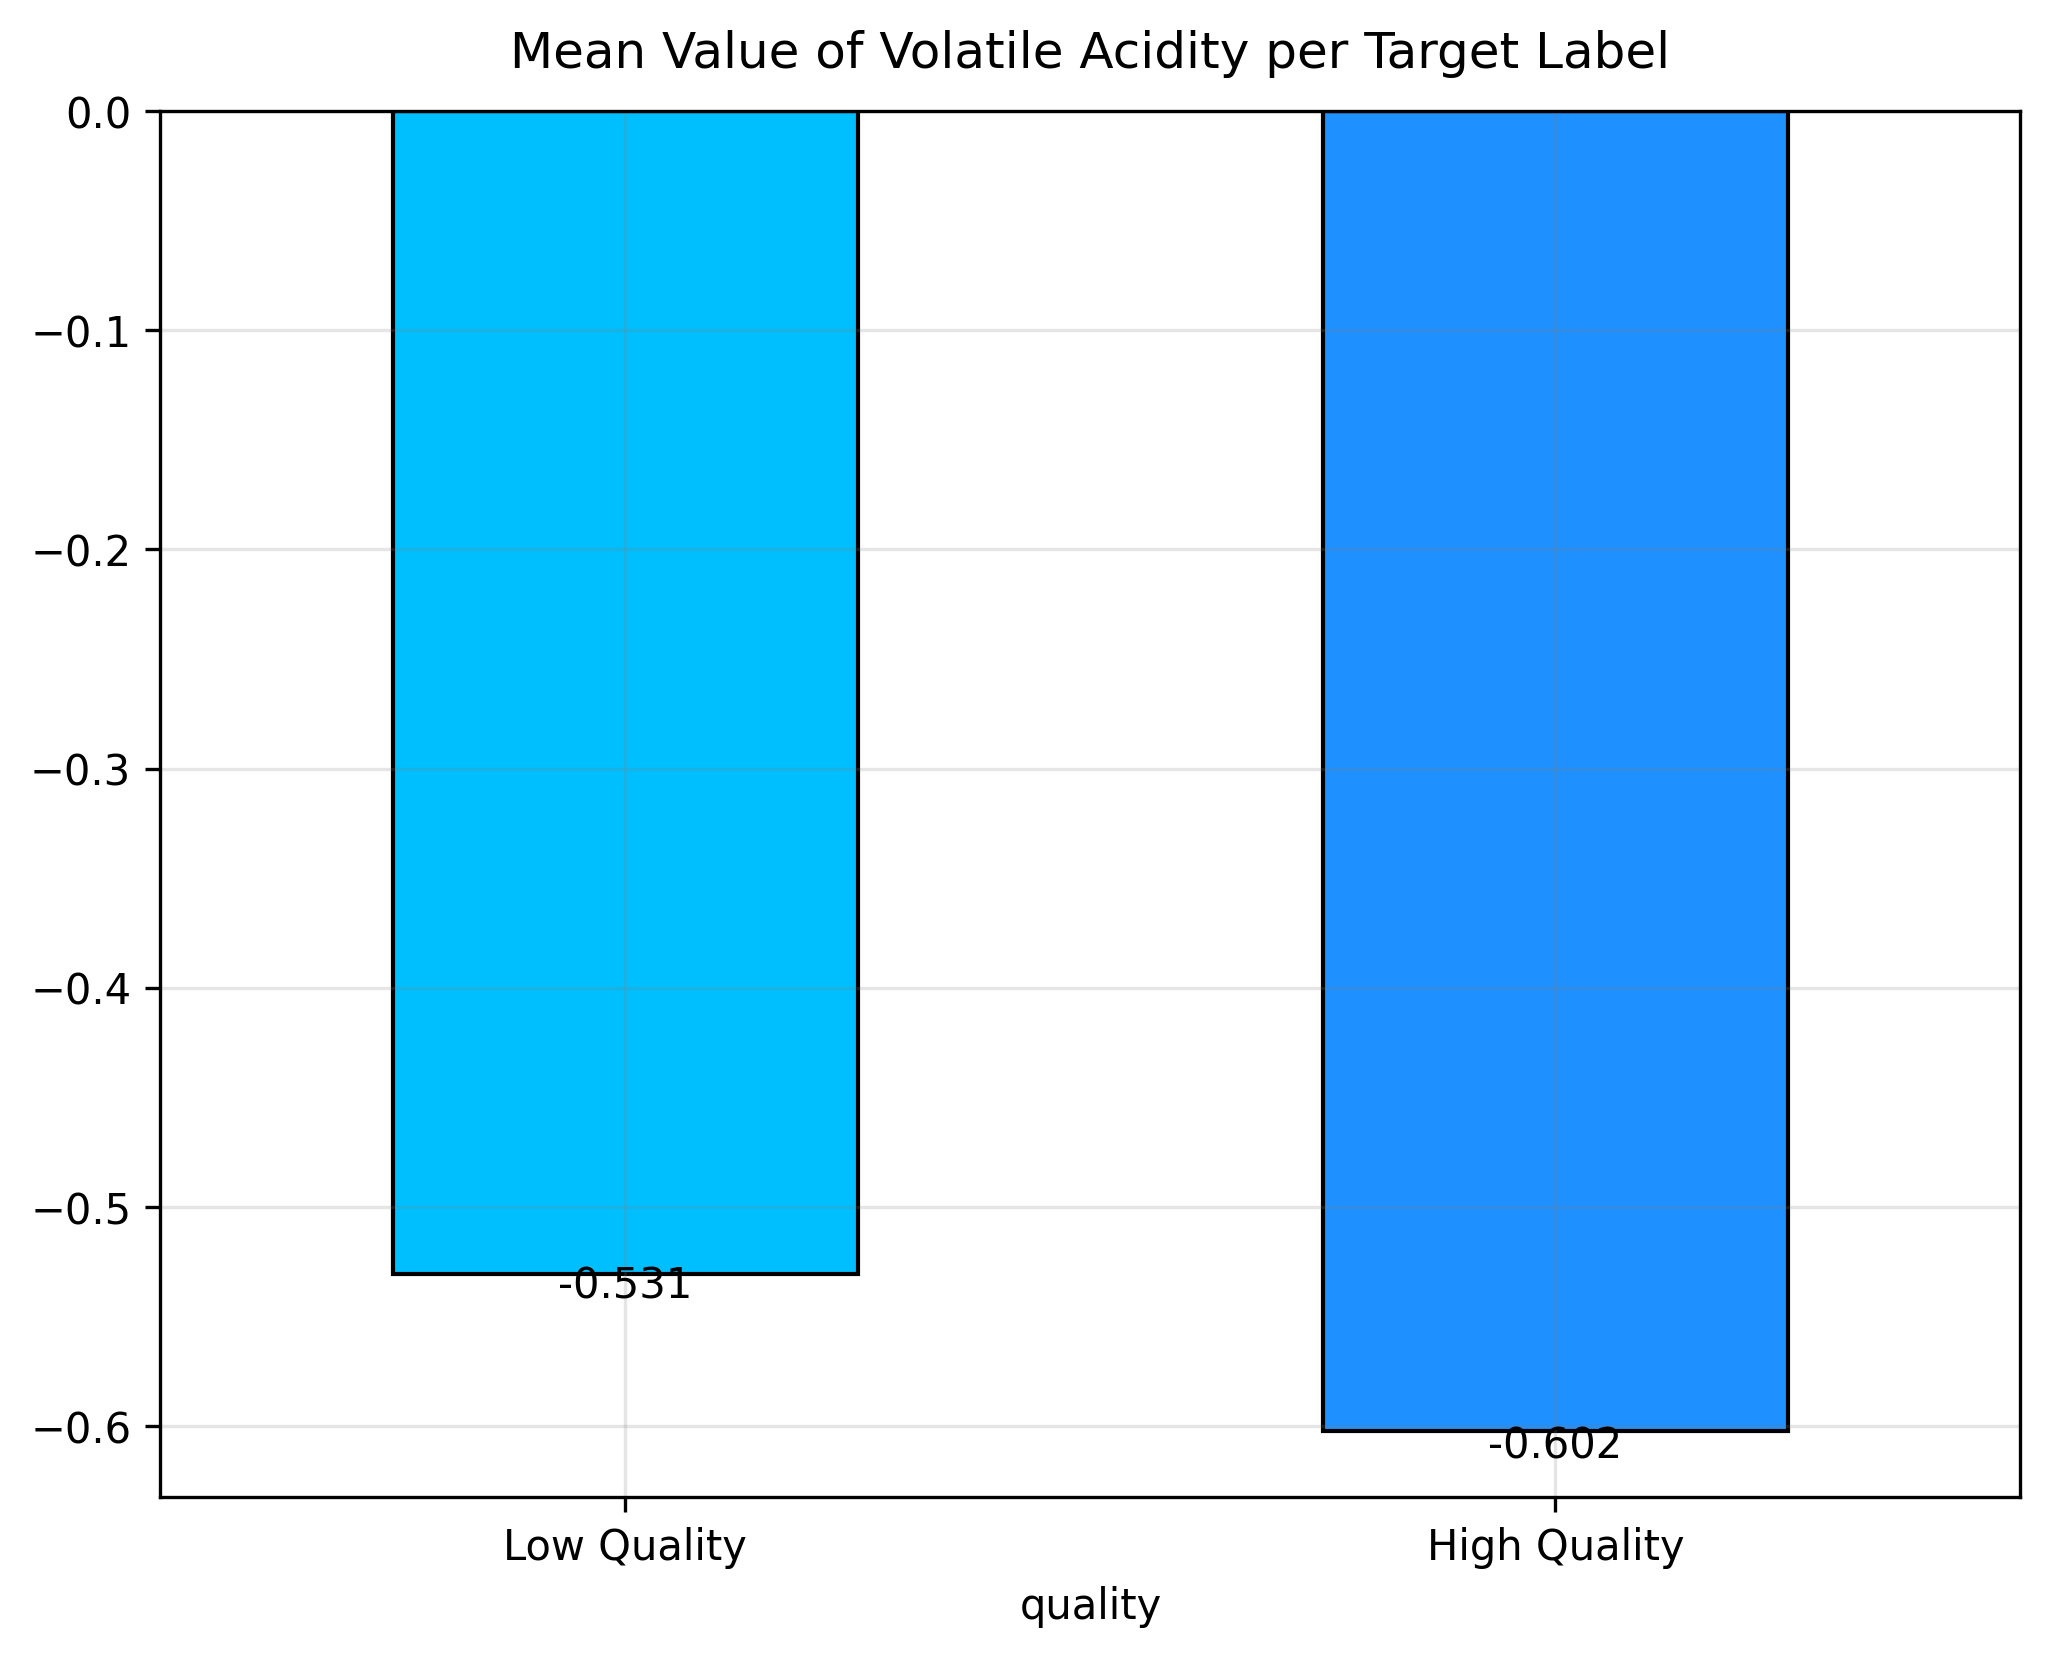

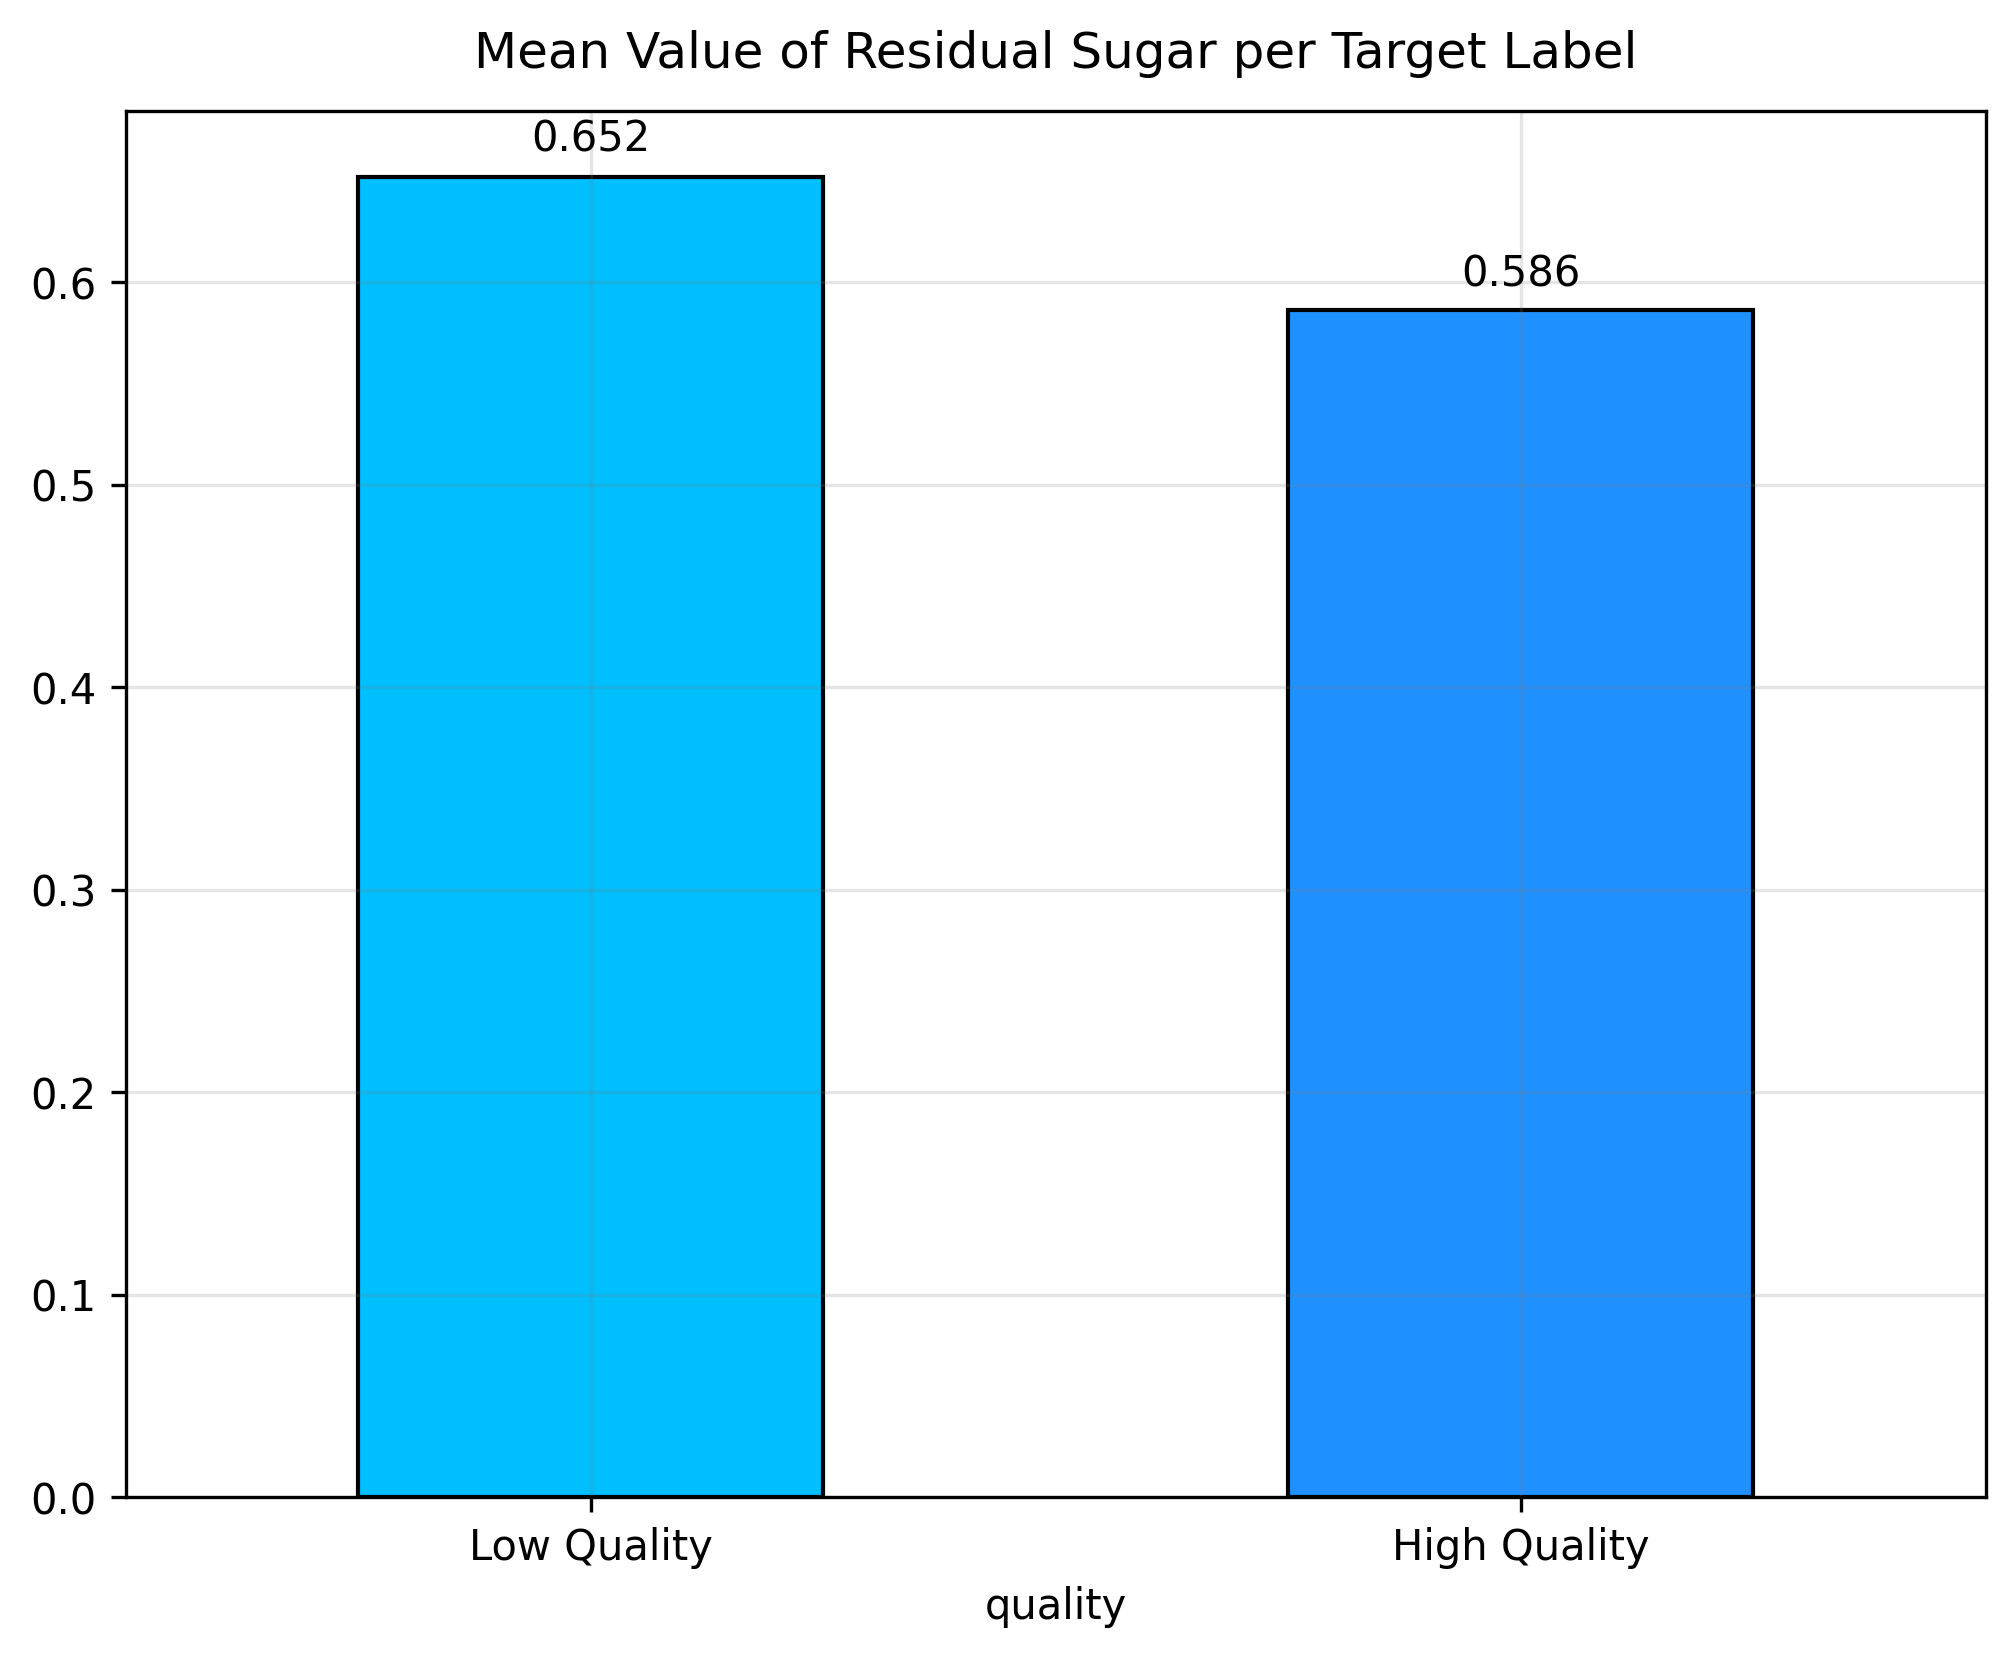

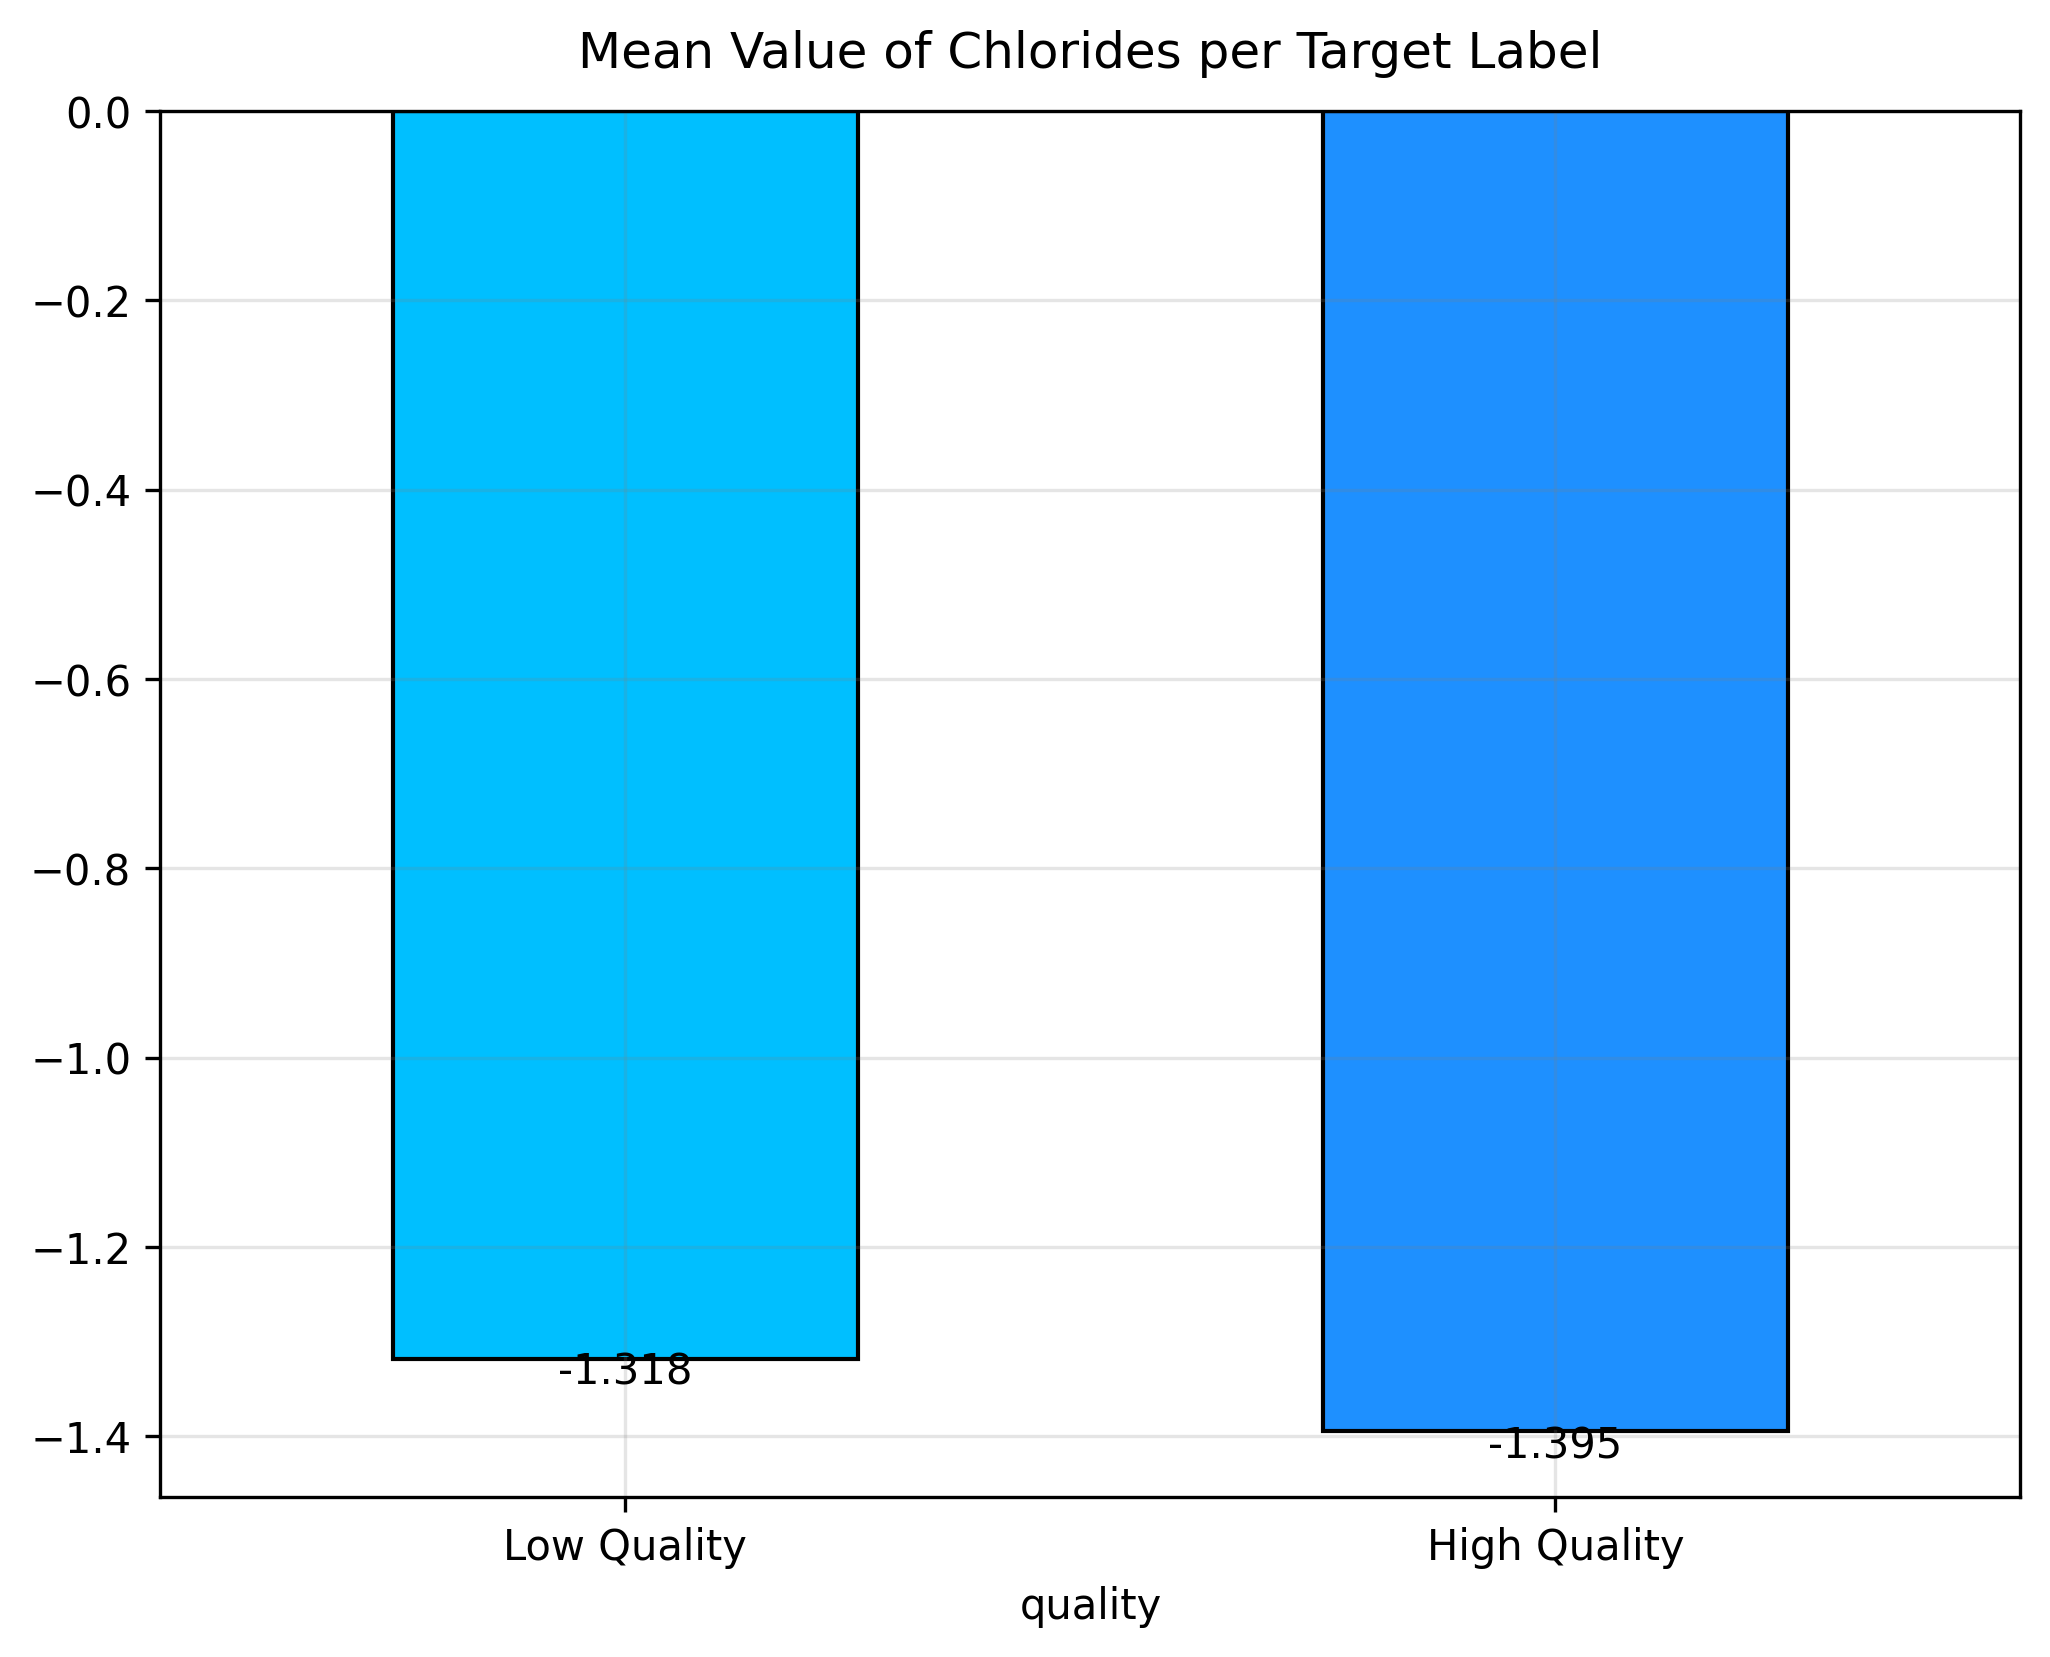

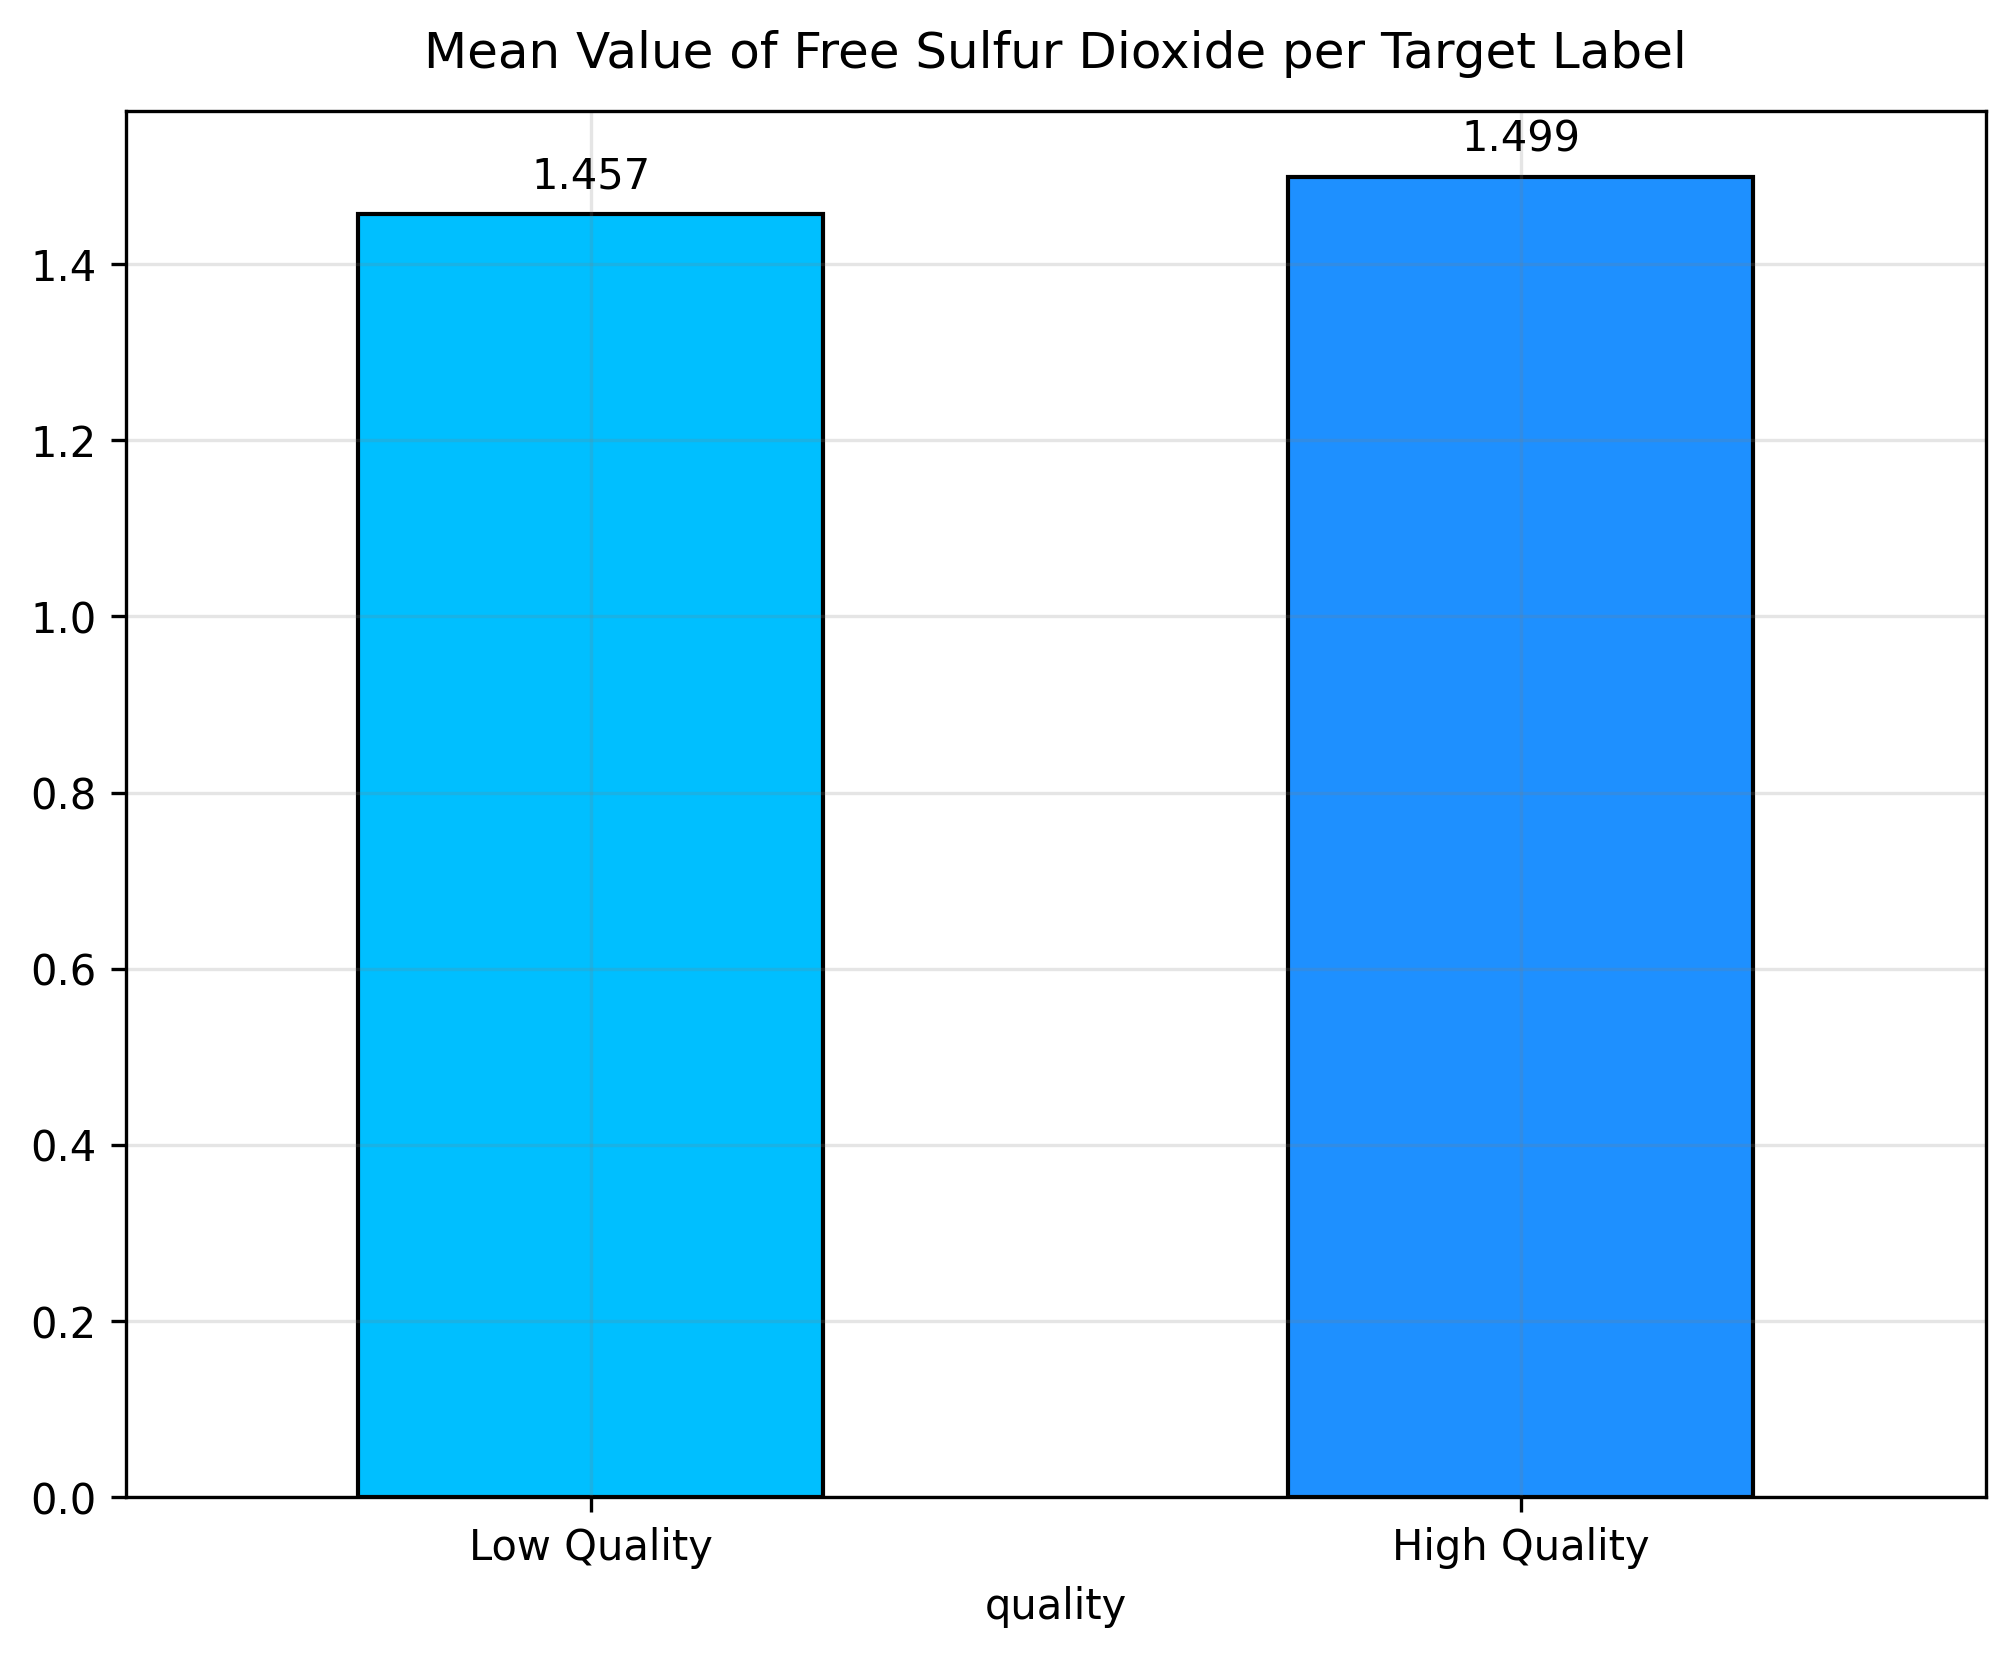

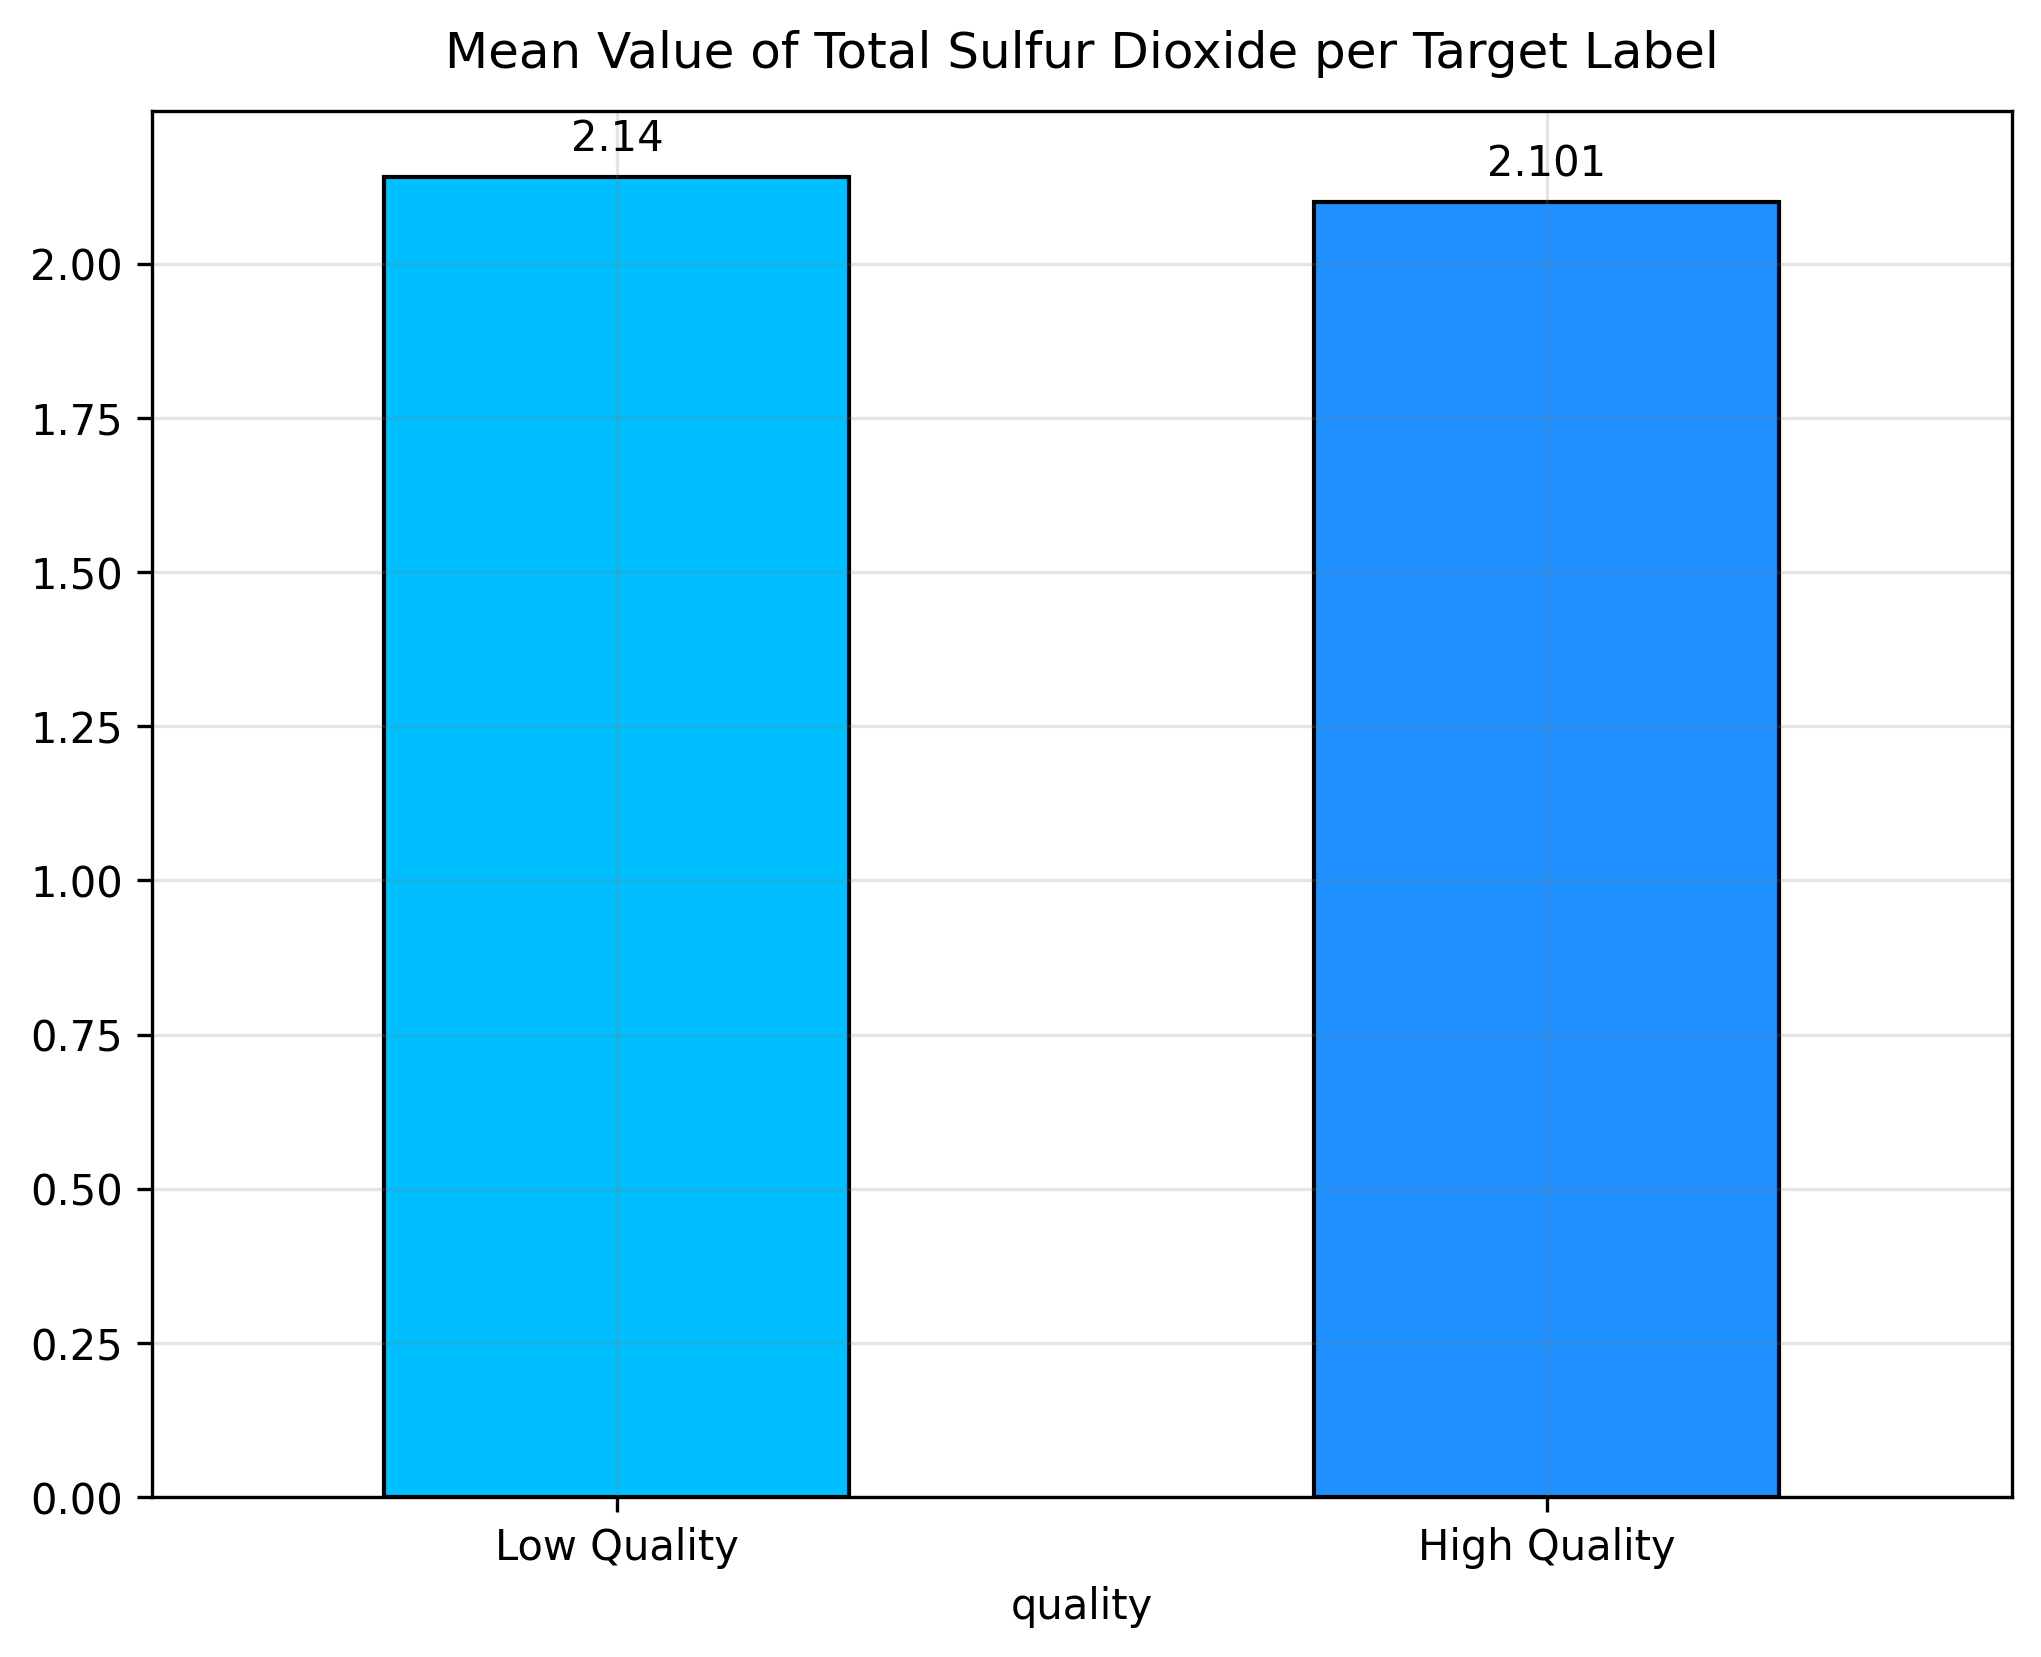

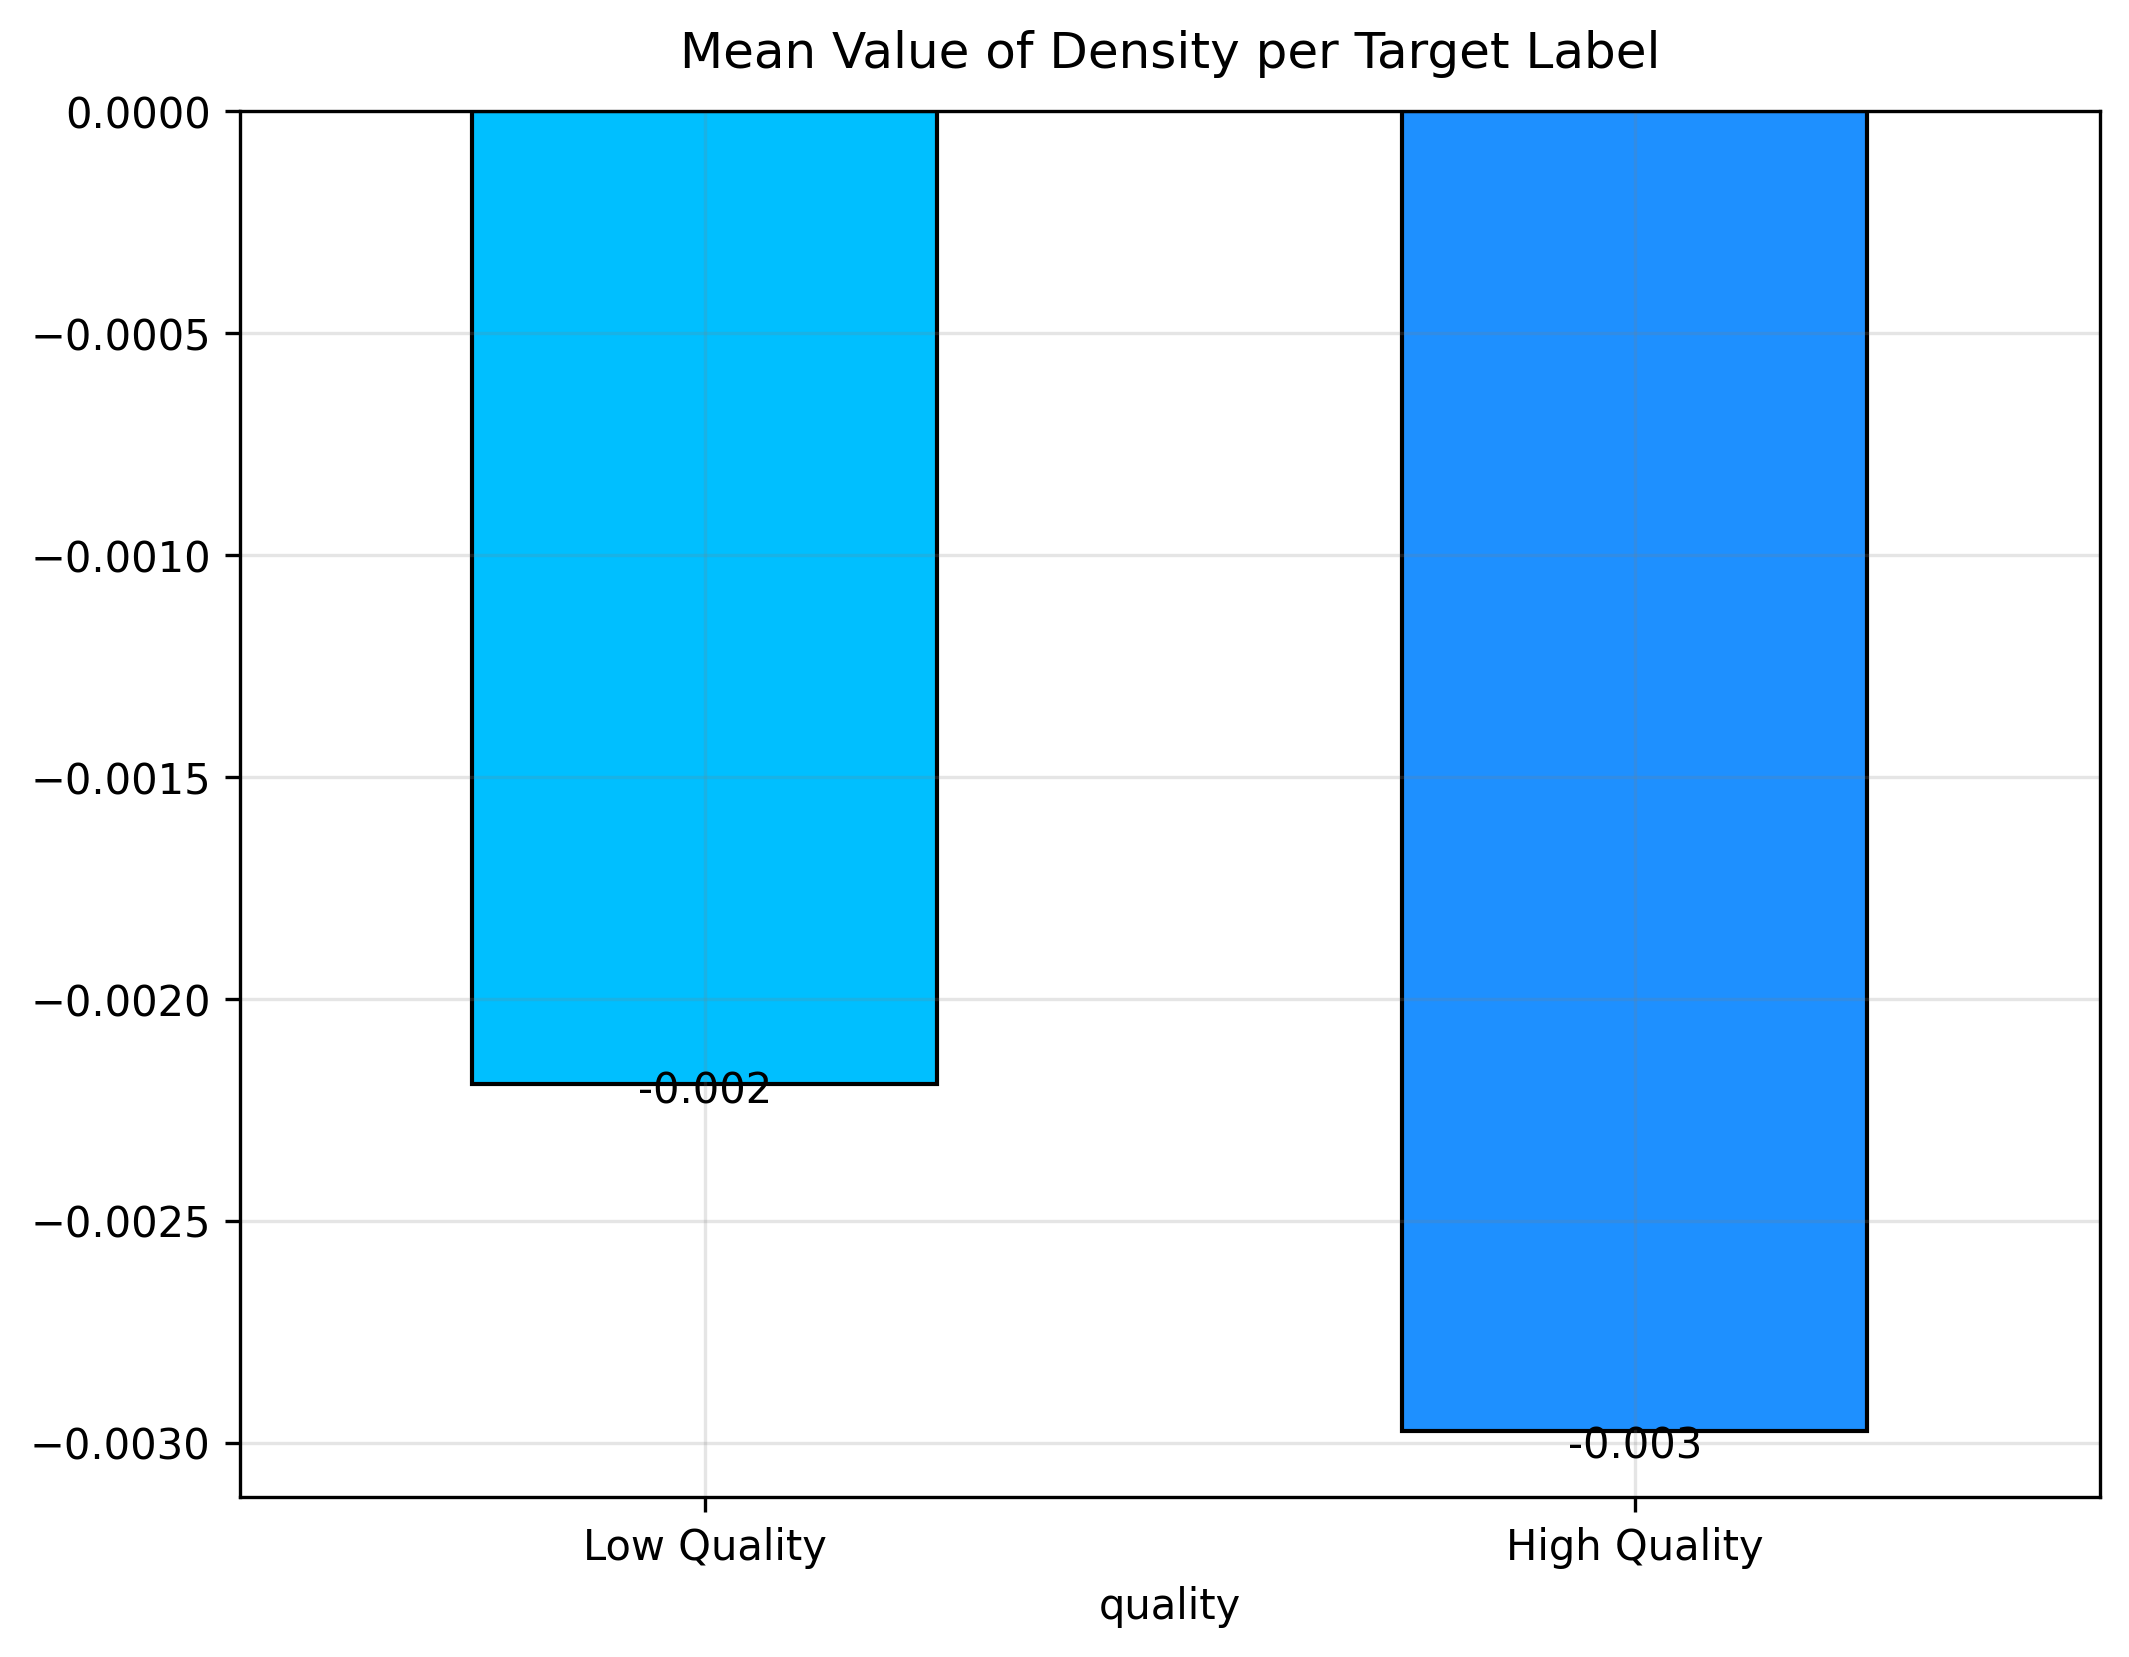

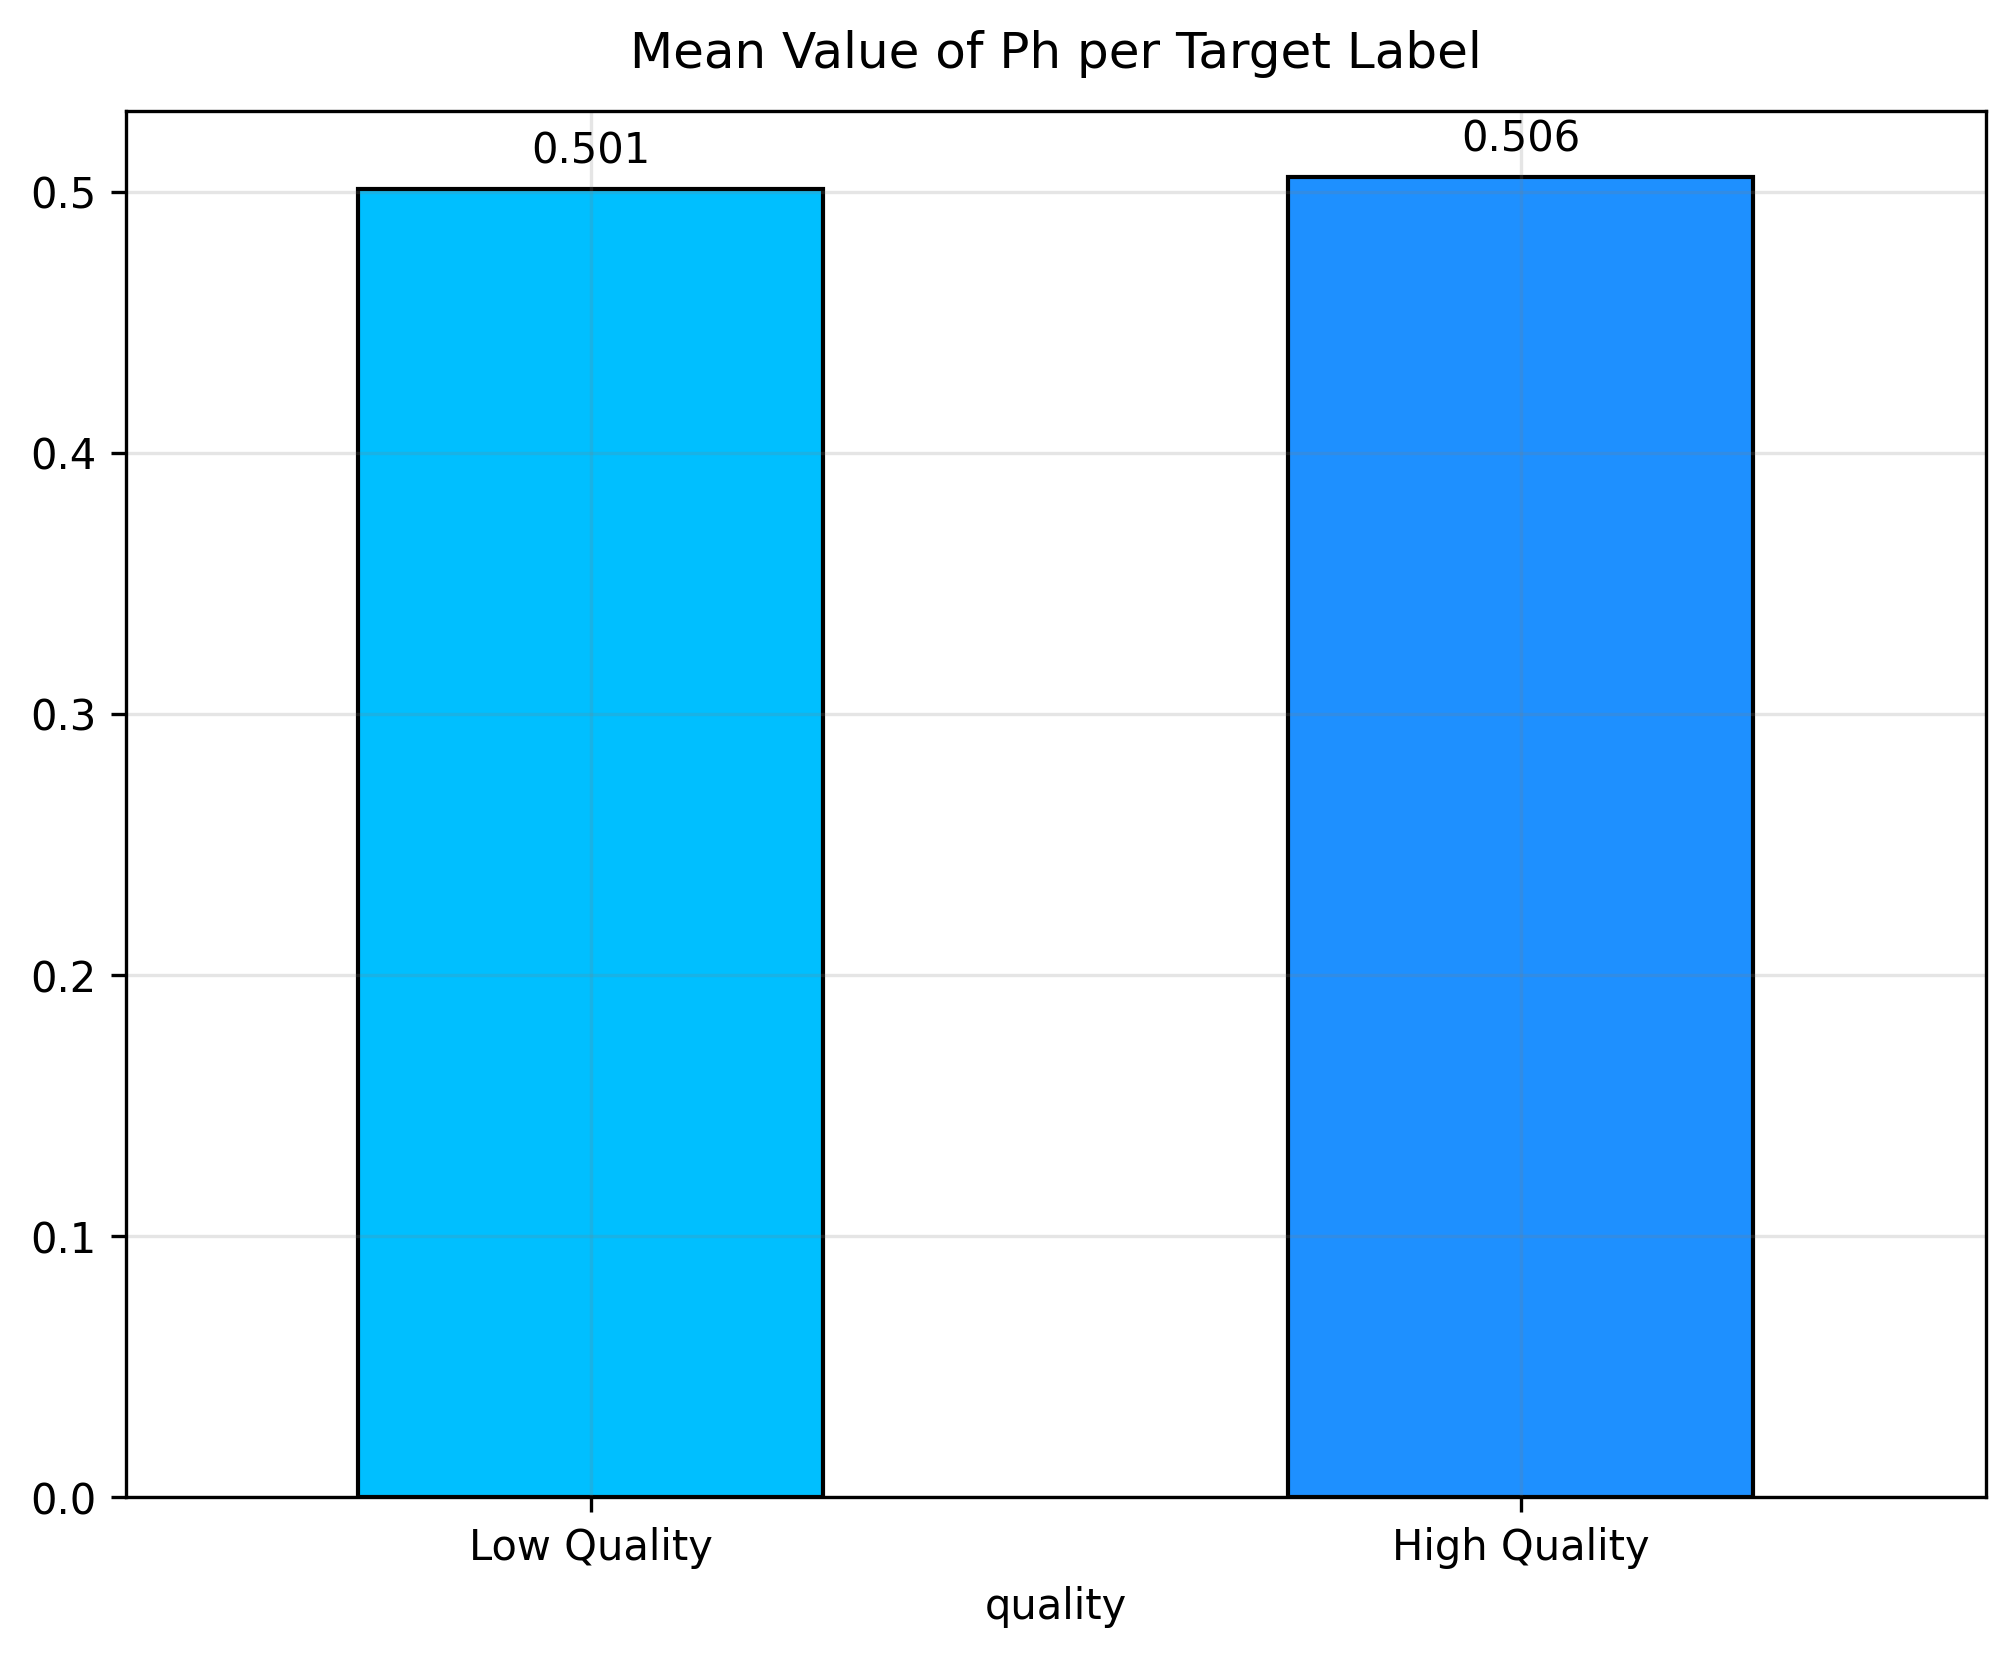

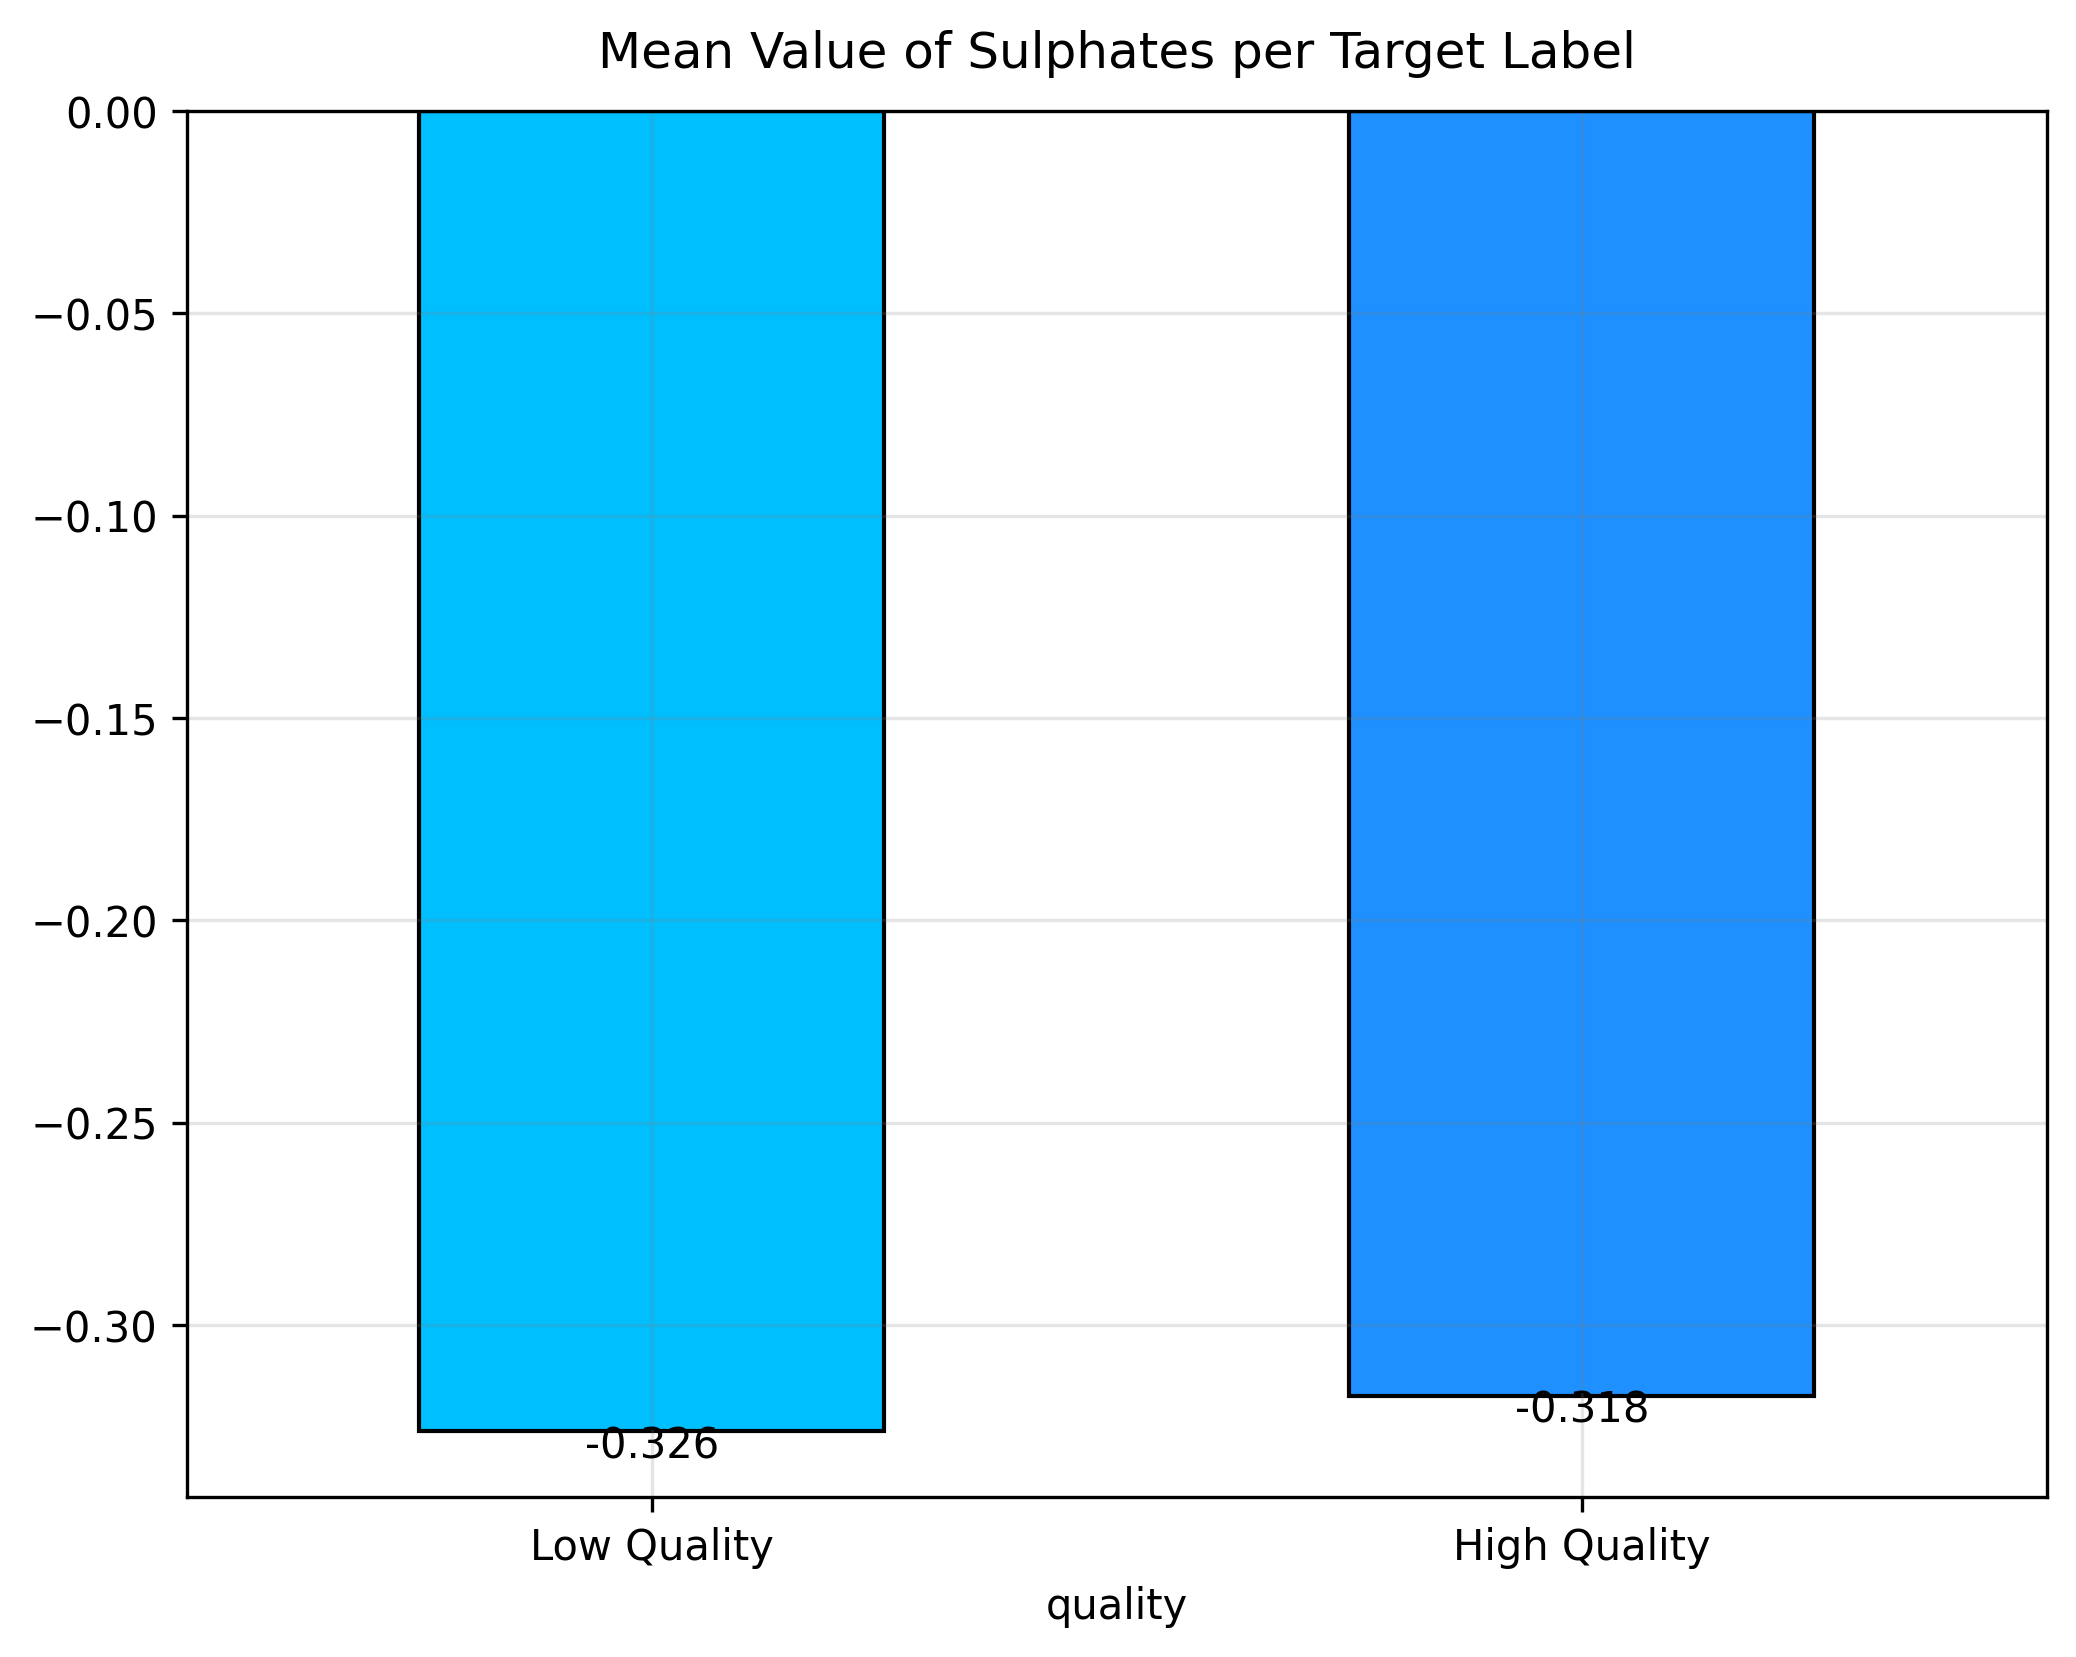

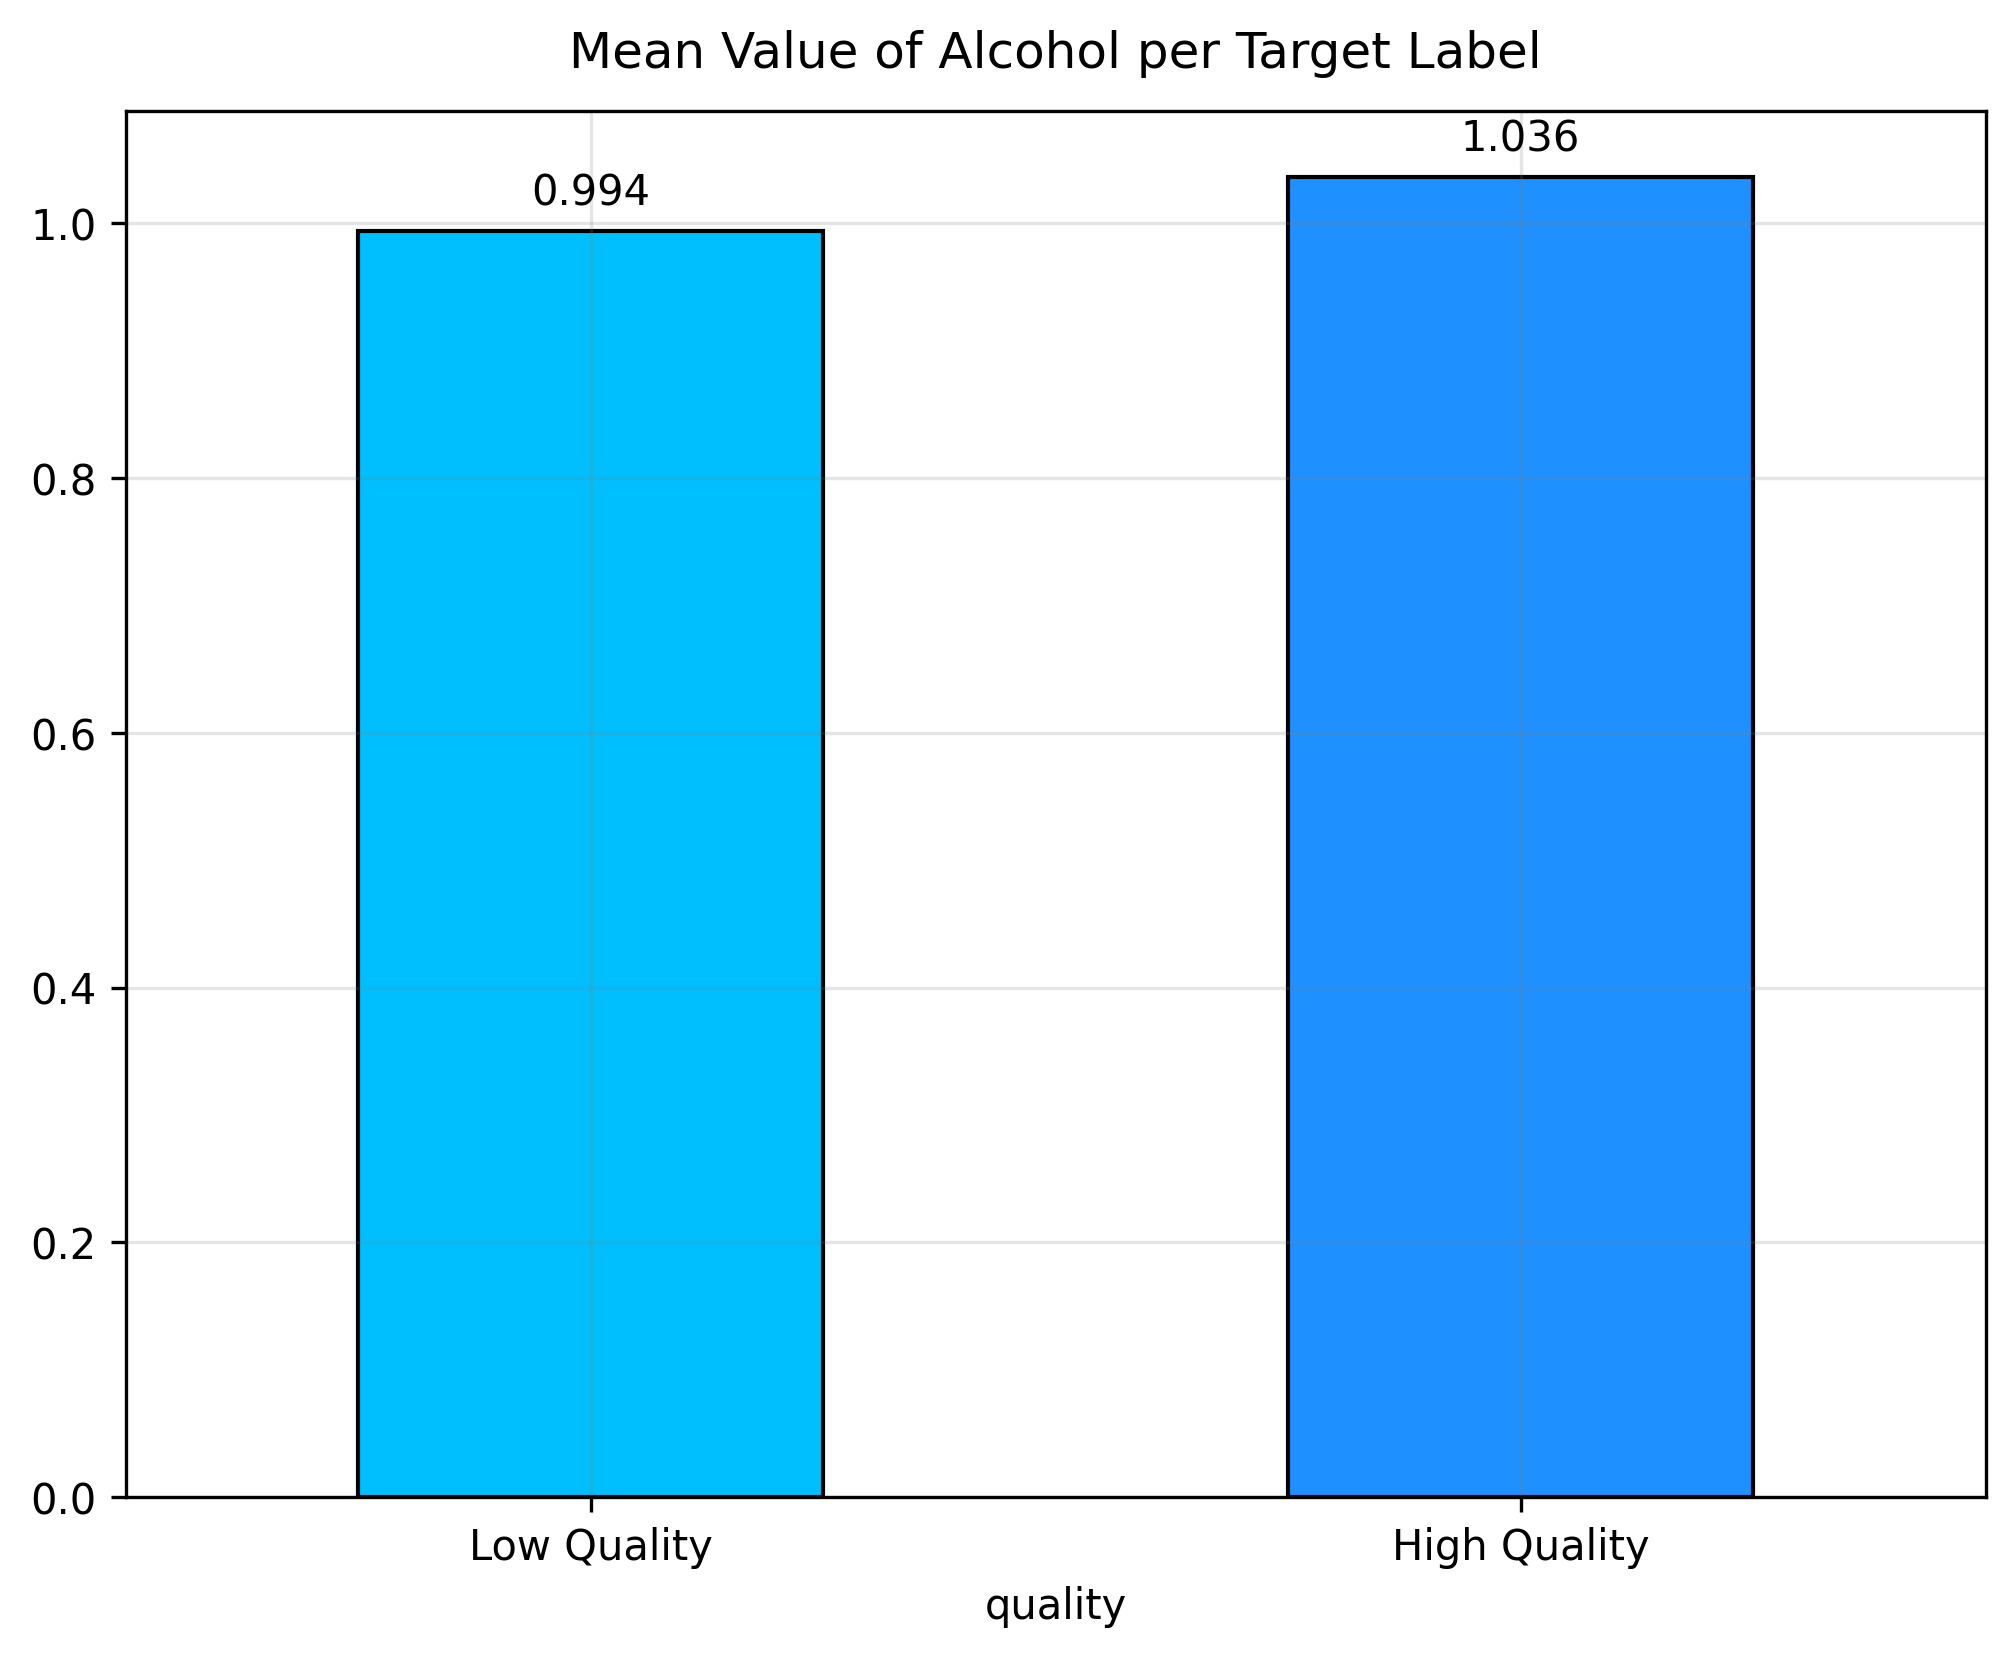

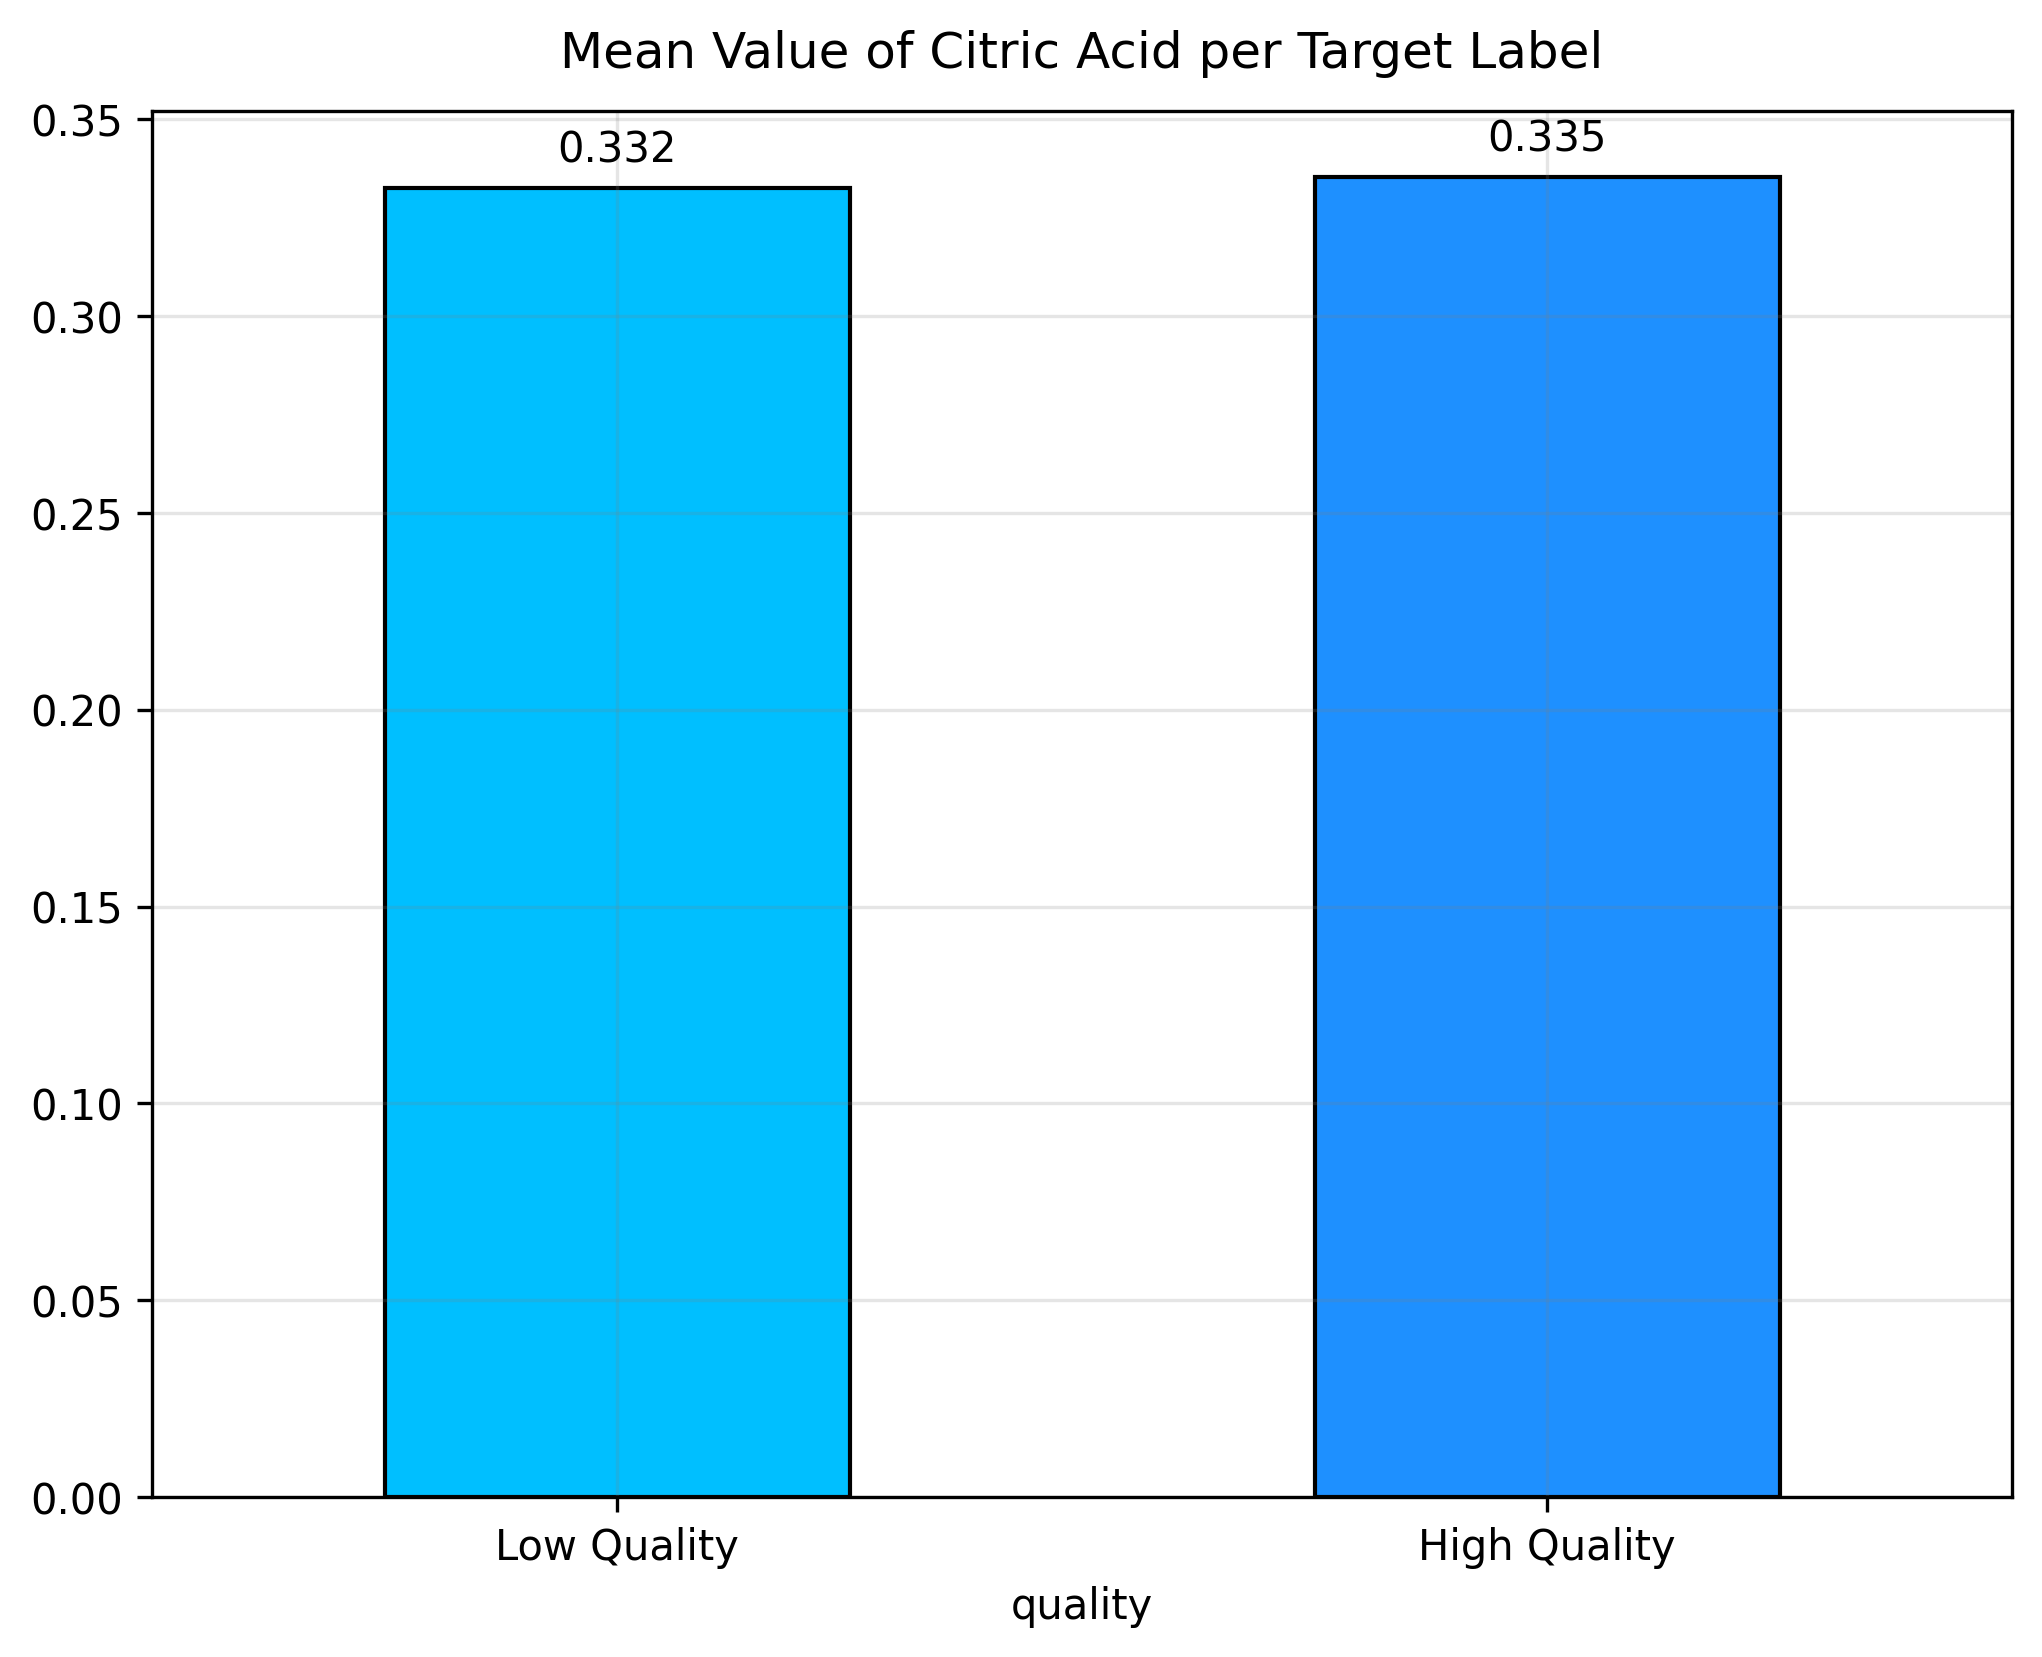

In [28]:
features_mean_stats = df.groupby('quality').mean()

for col in list(features_mean_stats.columns.values):
    subset = features_mean_stats[col]
    
    fig = plt.figure(figsize=(8, 6), dpi=300)
    
    ax = subset.plot(
        kind='bar', 
        rot=0, 
        color=['deepskyblue', 'dodgerblue', 'royalblue'], 
        edgecolor='black', 
        linewidth=1,
    )
    
    plt.title(f'Mean Value of {col.title()} per Target Label', fontsize=12, pad=10.5)
    
    plt.xticks(ticks=np.arange(len(subset)), labels=['Low Quality', 'High Quality'], fontsize=10)
    
    plt.grid(alpha=0.2, color='grey')
    
    for patch in ax.patches:
        width = patch.get_width()
        height = patch.get_height()
        x, y = patch.get_xy()
        ax.annotate(f'{round(height, 3)}', (x + width/2, y + height*1.02), ha='center')
    
    plt.show()

In [29]:
features_std_stats = df.groupby('quality').std()
features_std_stats

fixed acidity  volatile acidity  residual sugar  chlorides  \
quality                                                               
0             0.055763          0.146707        0.419357   0.156392   
1             0.053015          0.143245        0.380409   0.137009   

         free sulfur dioxide  total sulfur dioxide   density        pH  \
quality                                                                  
0                   0.294996              0.171024  0.001104  0.019897   
1                   0.207706              0.133575  0.001264  0.020551   

         sulphates   alcohol  citric acid  
quality                                    
0         0.088689  0.037941     0.143228  
1         0.100978  0.048199     0.110221

<h1>Feature Statistics per Target Variable</h1>

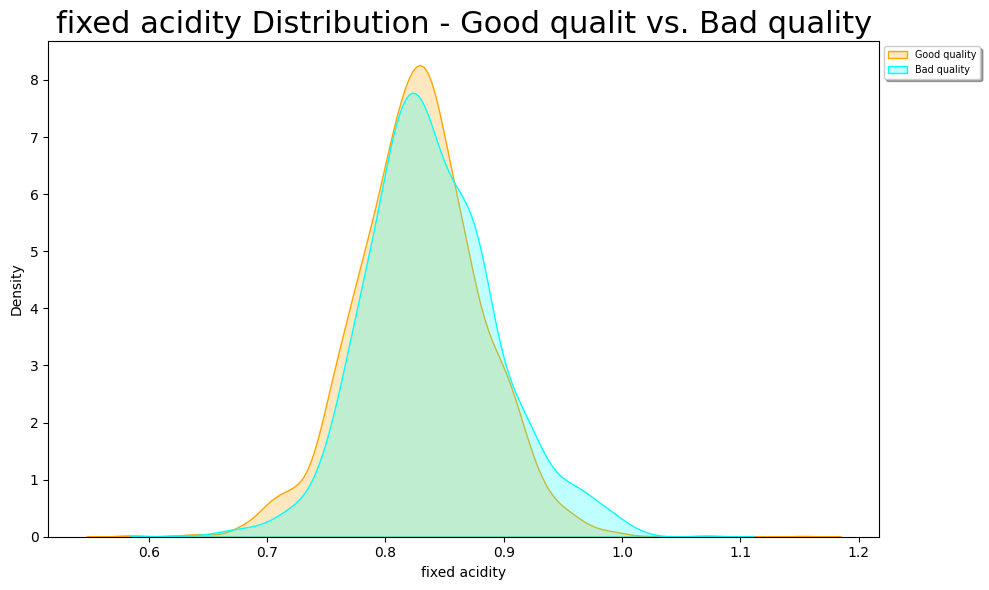

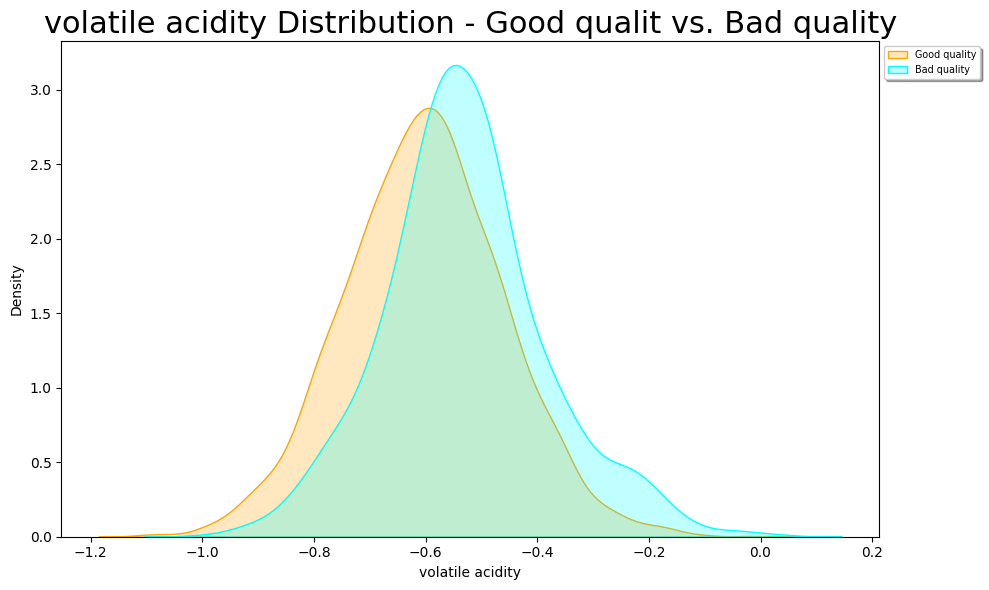

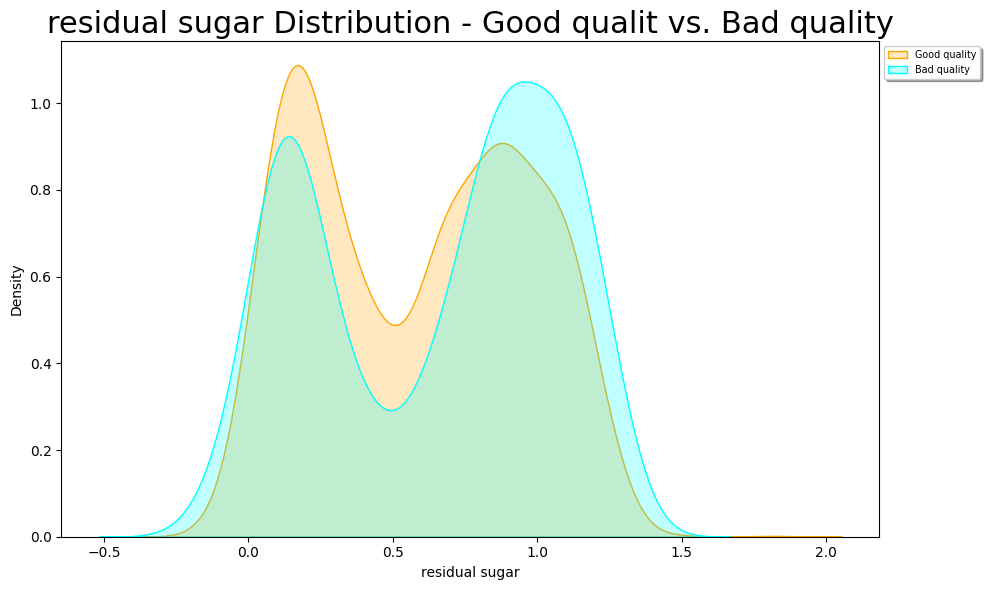

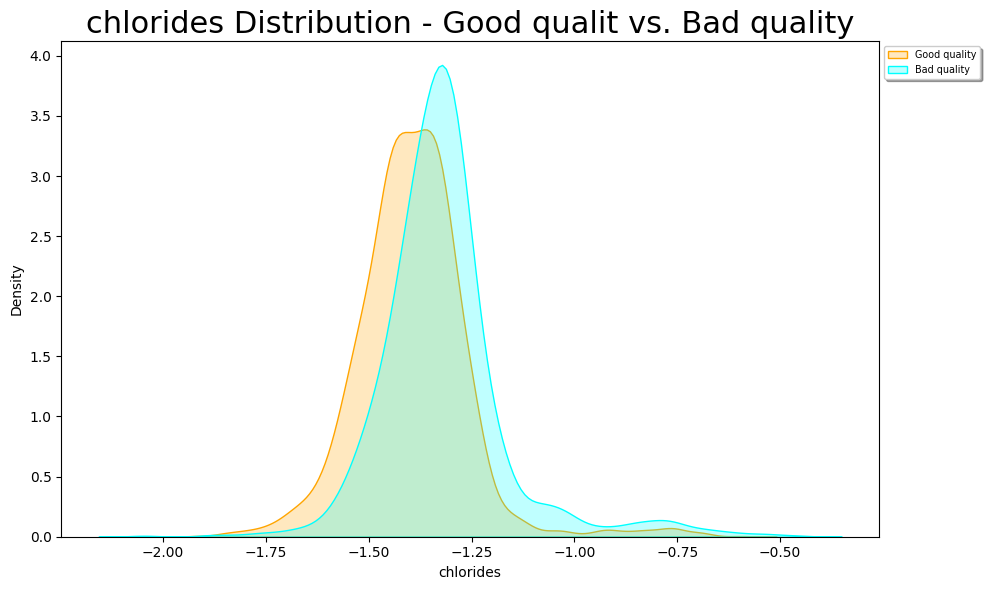

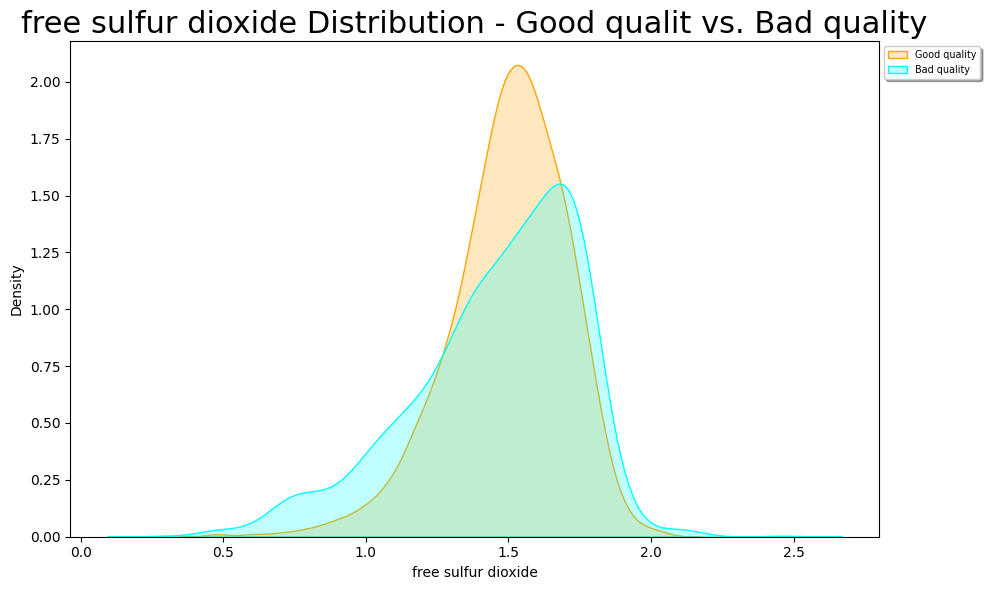

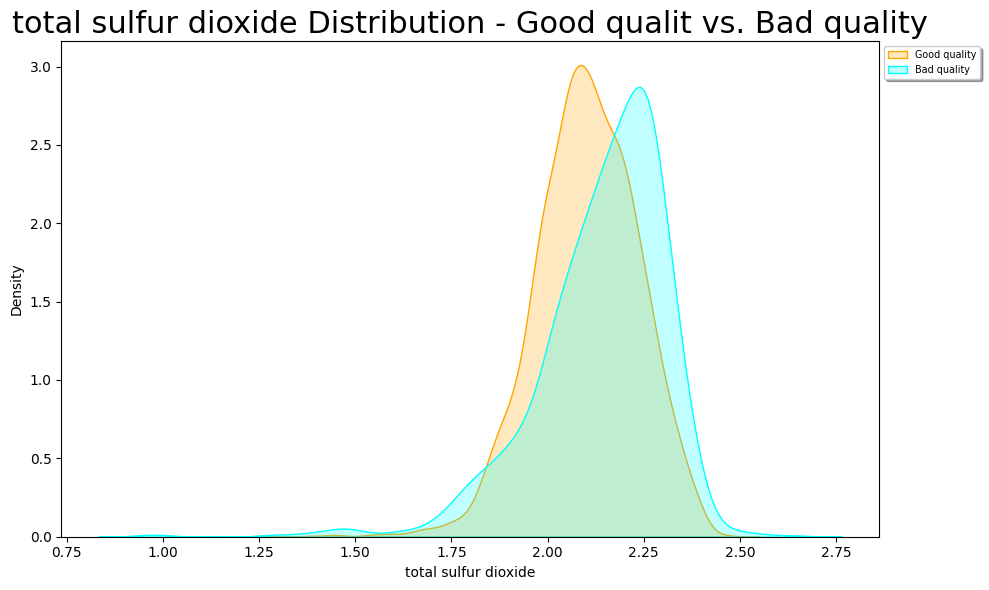

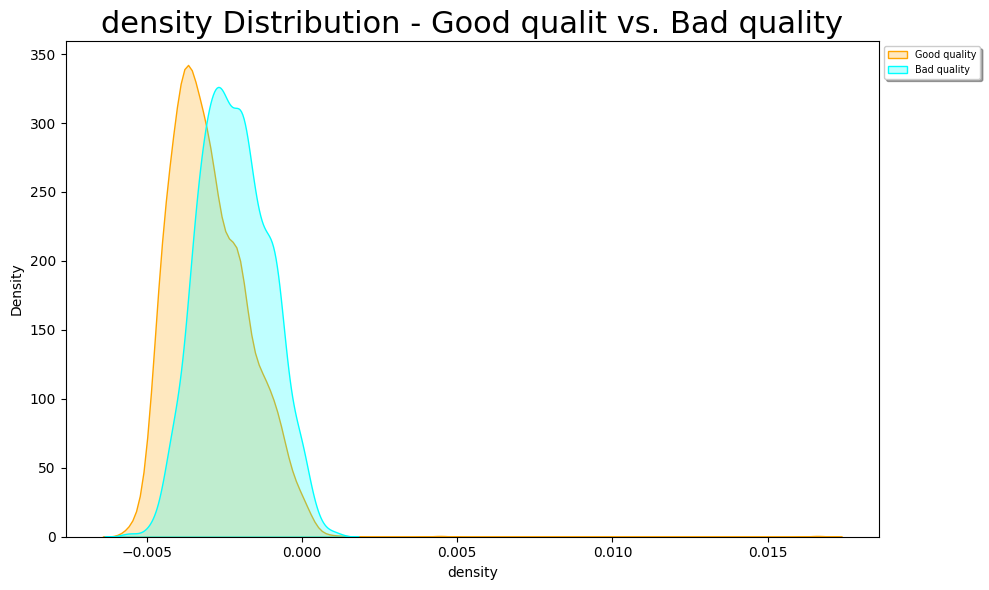

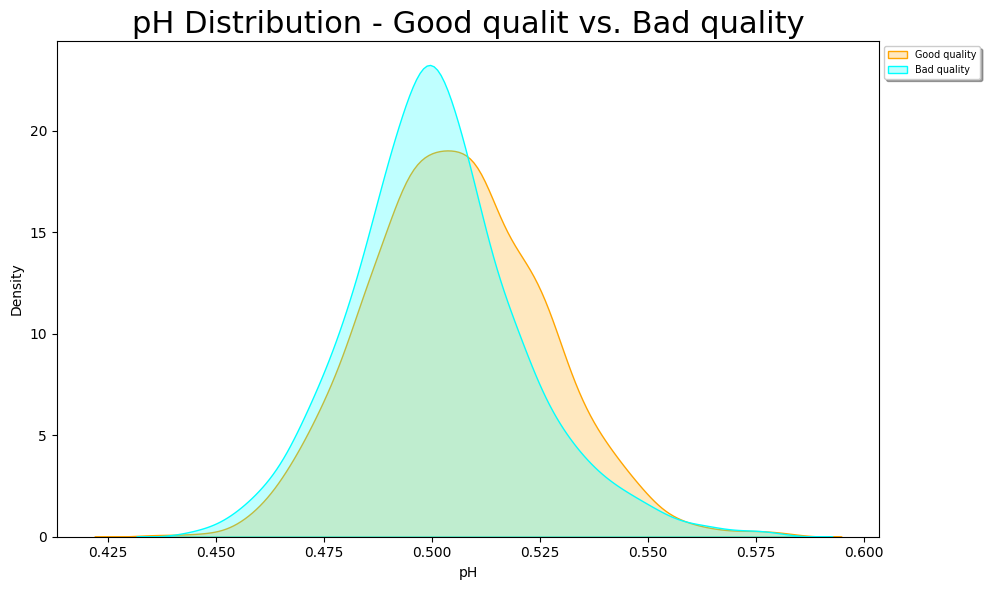

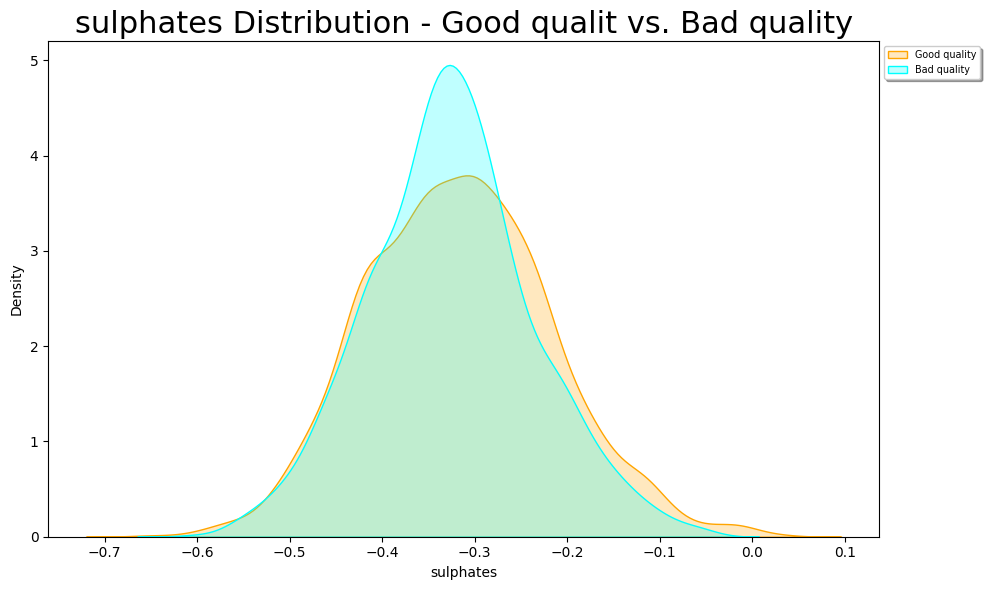

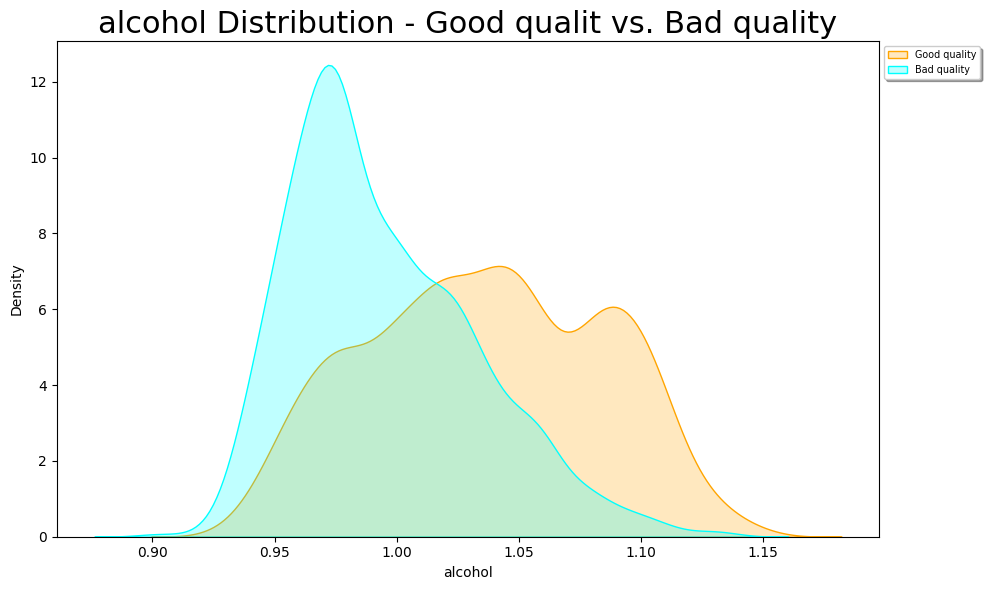

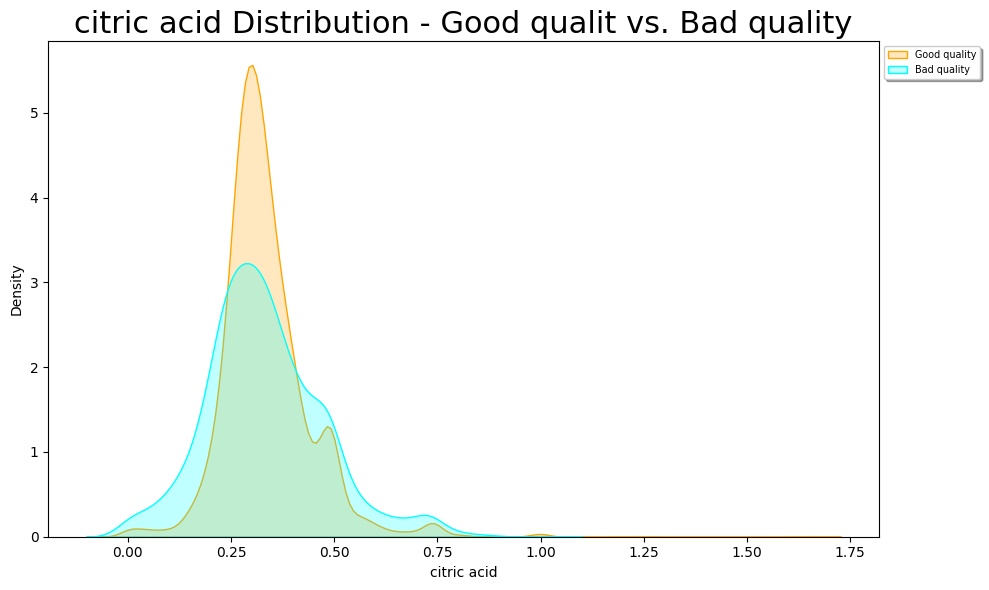

In [30]:
column_names = list(df.iloc[:, :11].columns.values)

labels = ['Good quality', 'Bad quality']

colors = ['orange', 'cyan']

for column_name in column_names:
    
    fig = plt.figure(figsize=(10, 6))


    ax = sns.kdeplot(
        df.loc[(df['quality'] == 1), column_name], 
        color=colors[0], 
        fill=True, 
        label=labels[0],
    )

    ax = sns.kdeplot(
        df.loc[(df['quality'] == 0), column_name], 
        color=colors[1], 
        fill=True, 
        label=labels[1],
    )

    plt.title(f'{column_name} Distribution - Good qualit vs. Bad quality', fontsize=22)

    plt.tick_params(top=False, bottom=True, left=True, right=False)

    plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize='x-small', frameon=True, shadow=True, fancybox=True)

    plt.tight_layout()
    
    plt.show()

<h1>Splitting the Data into Feature Matrix and Target Label</h1>

In [31]:
X = df.drop(['quality'], axis=1)
y = df['quality']

<h1>SMOTE Sampling to deal with imbalance classes</h1>

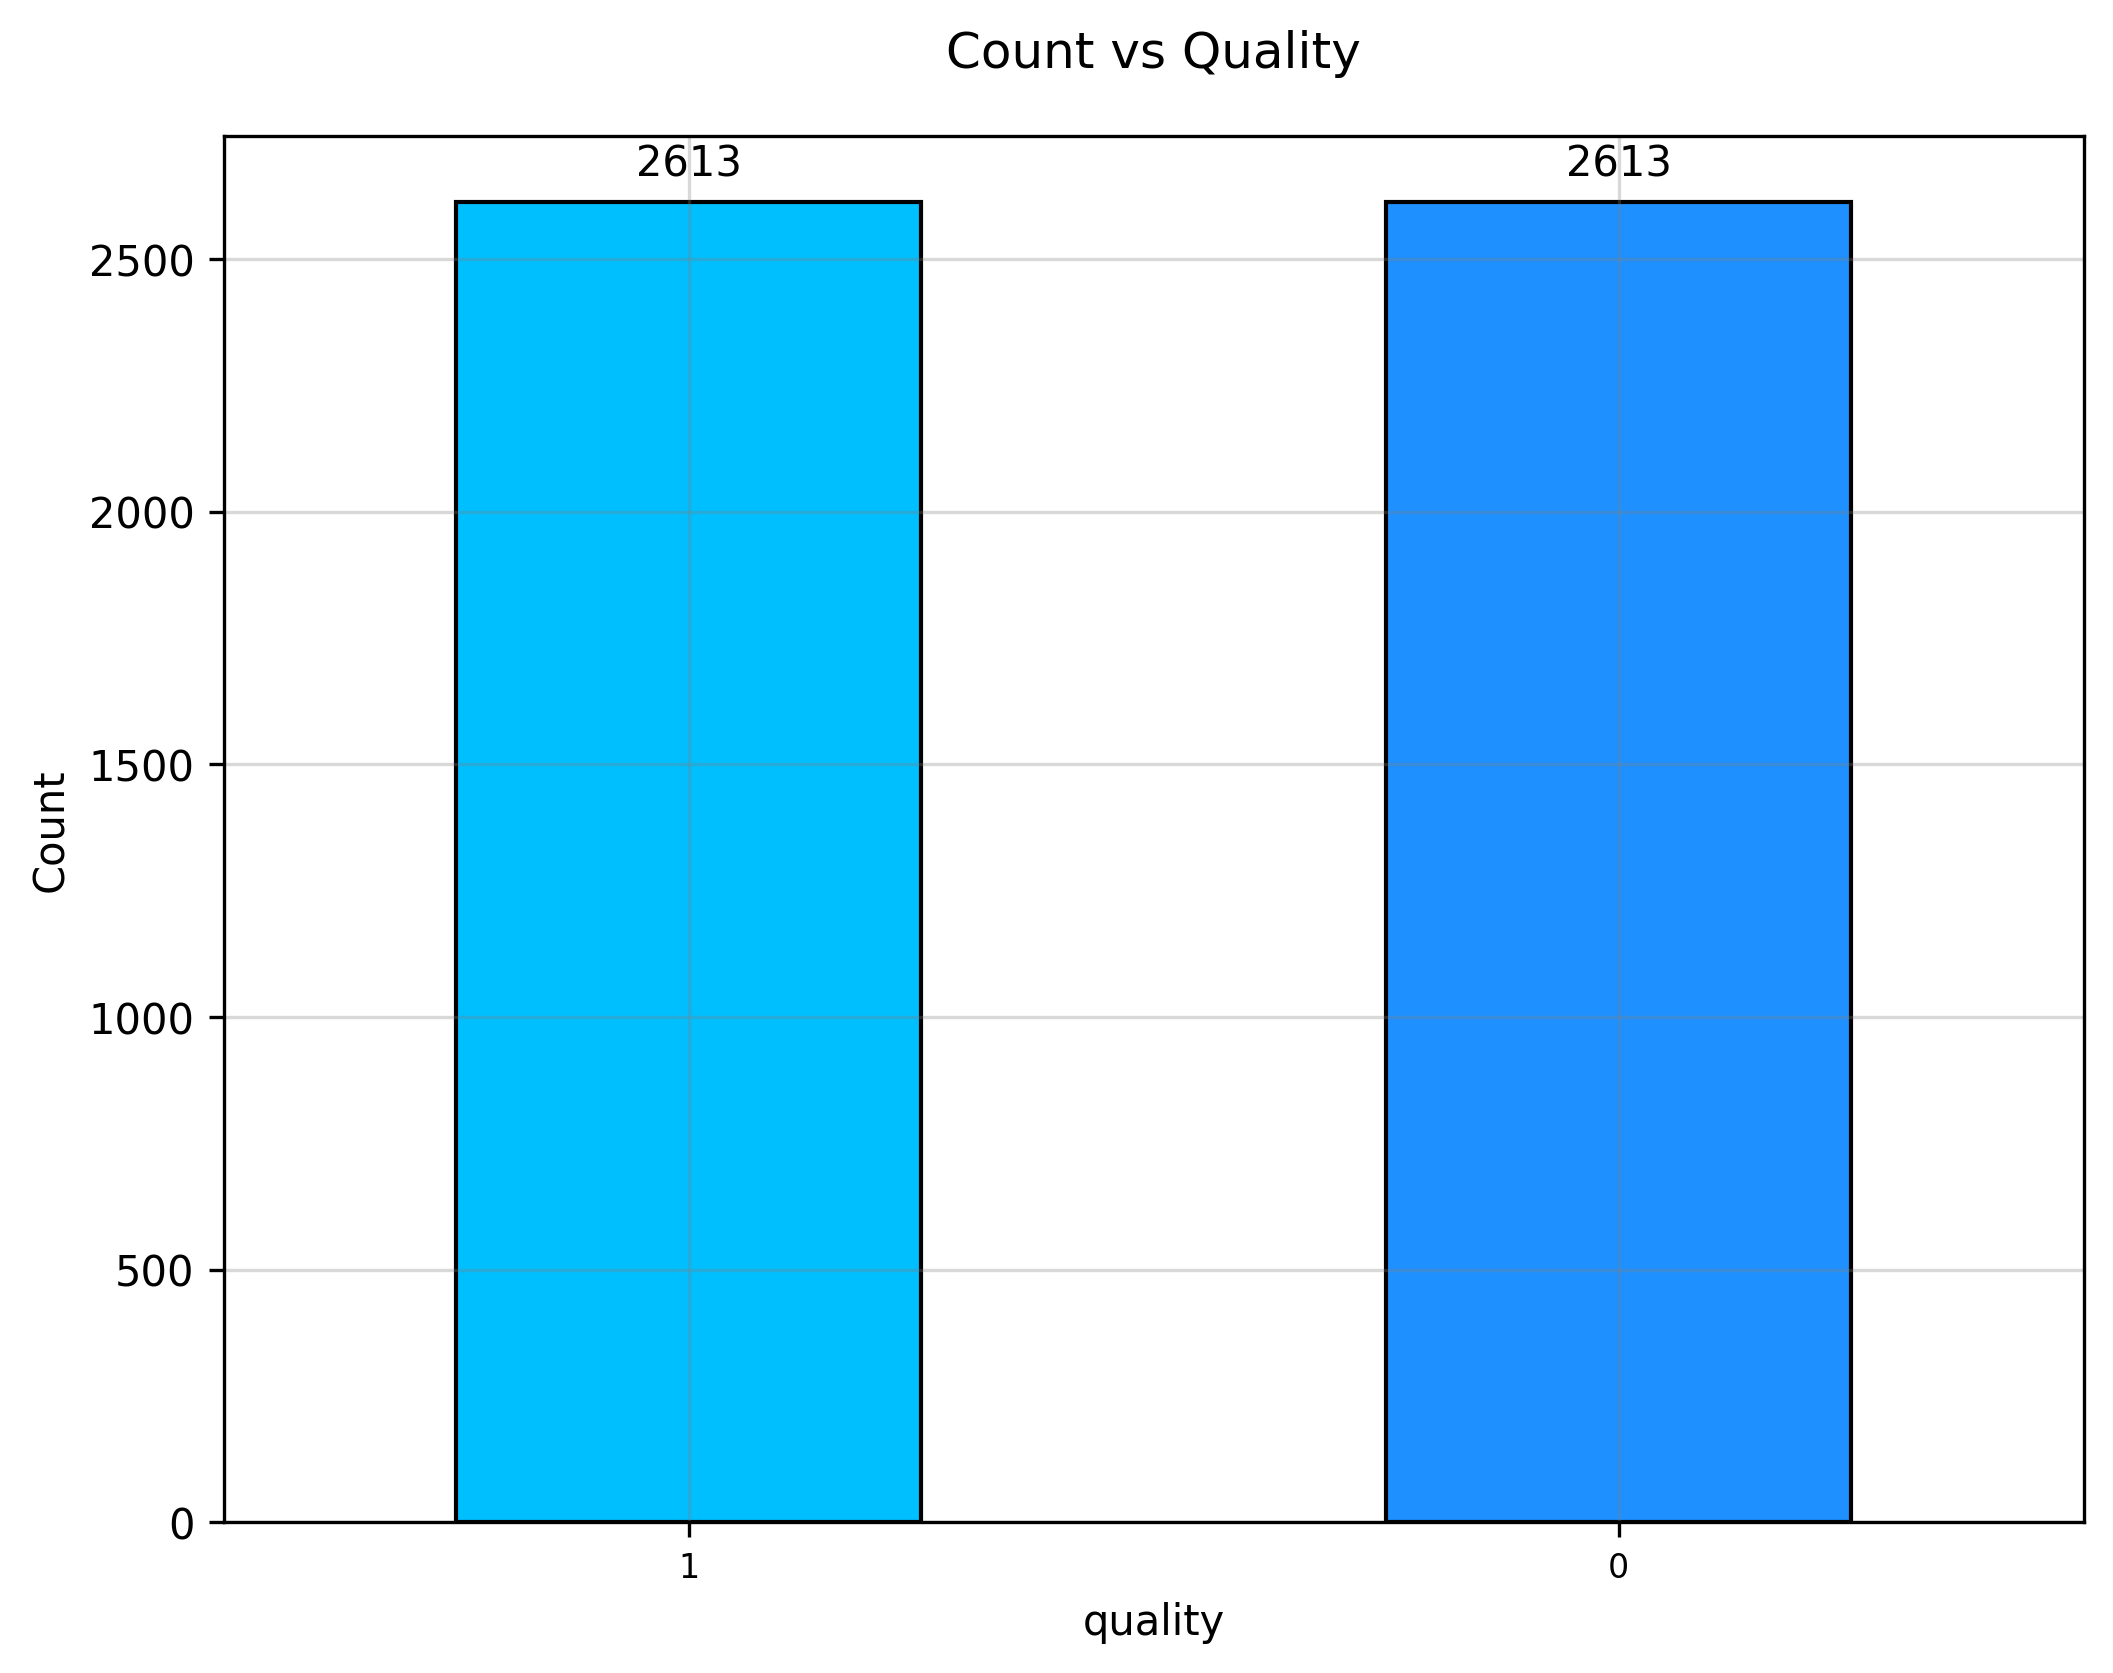

In [32]:
smote = SVMSMOTE(random_state=80)
X, y = smote.fit_resample(X, y)

plotted_y = y

fig = plt.figure(figsize=(8, 6), dpi=300)

ax = plotted_y.value_counts().plot(
    kind='bar', 
    rot=0, 
    color=['deepskyblue', 'dodgerblue', 'royalblue'], 
    edgecolor='black', 
    linewidth=1,
)
    
plt.title(f'Count vs Quality', fontsize=12, pad=16.5)
plt.ylabel('Count', fontsize=10)
    
for patch in ax.patches:
    width = patch.get_width()
    height = patch.get_height()
    x, plotted_y = patch.get_xy()
    ax.annotate(f'{height}', (x + width/2, plotted_y + height*1.02), ha='center')
    
plt.xticks(fontsize=8)
    
plt.grid(alpha=0.3, color='grey')
    
plt.show()

<h1>Splitting the Dataset into Train and Test sets</h1>

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=80)

<h1>Scalling Train and Test sets</h1>

In [34]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

df_train_scaled = pd.DataFrame(X_train, columns=X.columns)
df_test_scaled = pd.DataFrame(X_test, columns=X.columns)

df_combined_scaled = pd.concat([df_train_scaled, df_test_scaled], ignore_index=True)

summary_combined_scaled = df_combined_scaled.describe(include='all')

skewness_combined_scaled = df_combined_scaled.skew()
summary_combined_scaled.loc['skew'] = skewness_combined_scaled

train_accuracies = []
test_accuracies = []

summary_combined_scaled

fixed acidity  volatile acidity  residual sugar    chlorides  \
count    5226.000000       5226.000000     5226.000000  5226.000000   
mean        0.443514          0.463916        0.412740     0.452094   
std         0.094565          0.128907        0.196040     0.097836   
min         0.000000          0.000000        0.000000     0.000000   
25%         0.383502          0.385954        0.208801     0.394969   
50%         0.441438          0.464089        0.448974     0.452142   
75%         0.505582          0.540651        0.581173     0.494204   
max         1.000000          1.000000        1.000000     1.039696   
skew        0.162843          0.189957       -0.101882     1.200413   

       free sulfur dioxide  total sulfur dioxide      density           pH  \
count          5226.000000           5226.000000  5226.000000  5226.000000   
mean              0.509735              0.683574     0.165687     0.465721   
std               0.112024              0.077987     0.053929     0.136918   
min              -0.016703              0.000000     0.000000    -0.003789   
25%               0.451650              0.639653     0.126016     0.375537   
50%               0.524757              0.690023     0.161959     0.460073   
75%               0.591414              0.739653     0.201322     0.551241   
max               1.000000              1.000000     1.000000     1.000000   
skew             -0.835024             -1.278948     0.916718     0.293790   

         sulphates      alcohol  citric acid  
count  5226.000000  5226.000000  5226.000000  
mean      0.446442     0.387636     0.293137  
std       0.147920     0.166879     0.101335  
min      -0.079331     0.000000     0.000000  
25%       0.342968     0.245510     0.233126  
50%       0.447014     0.366147     0.280561  
75%       0.542244     0.507101     0.340722  
max       1.000000     1.000000     1.339954  
skew      0.180623     0.462401     1.116366

<h1>Modelling</h1>

In [35]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                annot_kws={"size": 14}, linewidths=0.5, linecolor="black")
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

<h2>KNeighbors Classifier</h2>

<h3>When K = 1</h3>

Training Accuracy Score: 1.0
Testing Accuracy Score: 0.8154875717017208

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2090
           1       1.00      1.00      1.00      2090

    accuracy                           1.00      4180
   macro avg       1.00      1.00      1.00      4180
weighted avg       1.00      1.00      1.00      4180

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       523
           1       0.86      0.75      0.80       523

    accuracy                           0.82      1046
   macro avg       0.82      0.82      0.81      1046
weighted avg       0.82      0.82      0.81      1046



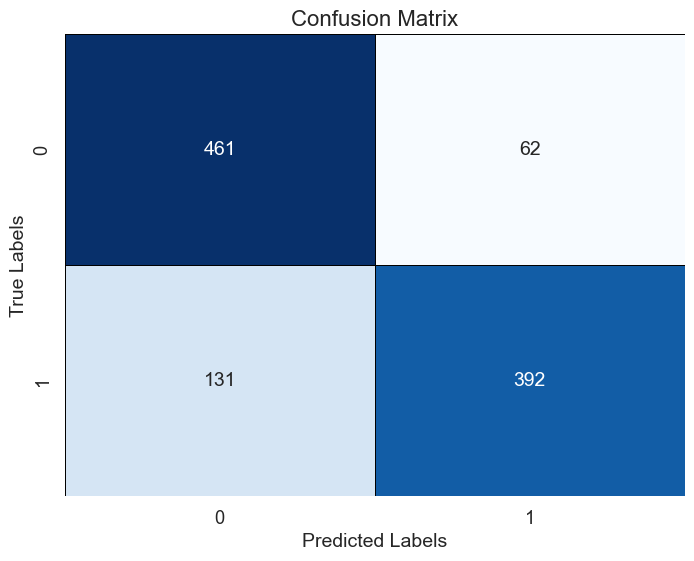

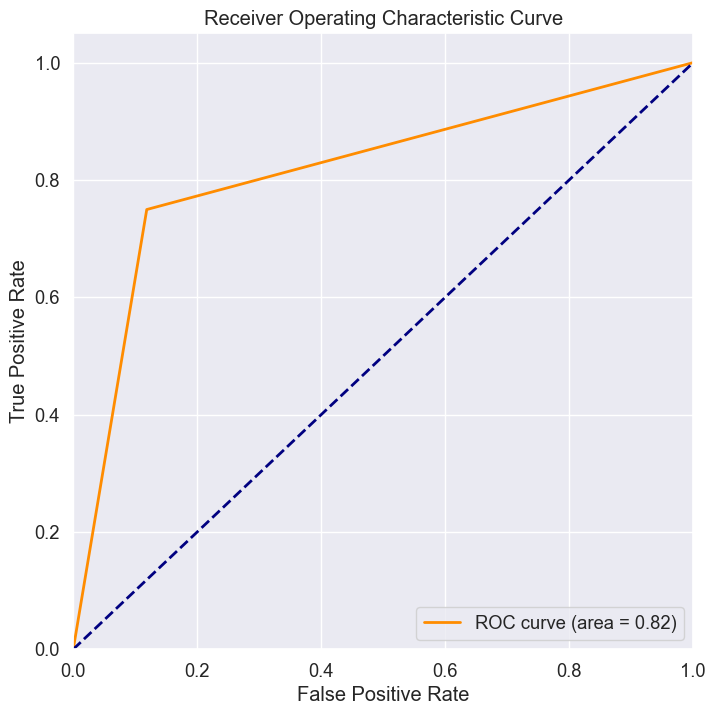

In [36]:
model_knn_1 = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_knn_1.fit(X_train, y_train)

y_test_pred_knn_1 = model_knn_1.predict(X_test)

y_train_pred_knn_1 = model_knn_1.predict(X_train)

train_accuracy = model_knn_1.score(X_train, y_train)
test_accuracy = model_knn_1.score(X_test, y_test)

train_accuracies.append(train_accuracy)
test_accuracies.append(test_accuracy)

print(f"Training Accuracy Score: {train_accuracy}")
print(f"Testing Accuracy Score: {test_accuracy}")

print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_knn_1))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred_knn_1))

# Print confusion matrix
conf_matrix_knn_1 = confusion_matrix(y_test, y_test_pred_knn_1)
plot_confusion_matrix(conf_matrix_knn_1)

# Get predicted probabilities for positive class
y_test_prob_knn_1 = model_knn_1.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_knn_1, tpr_knn_1, _ = roc_curve(y_test, y_test_prob_knn_1)
roc_auc = auc(fpr_knn_1, tpr_knn_1)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn_1, tpr_knn_1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

<h3>When K = 3</h3>

Training Accuracy Score: 0.8949760765550239
Testing Accuracy Score: 0.7934990439770554

Training Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2090
           1       0.93      0.85      0.89      2090

    accuracy                           0.89      4180
   macro avg       0.90      0.89      0.89      4180
weighted avg       0.90      0.89      0.89      4180

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       523
           1       0.84      0.73      0.78       523

    accuracy                           0.79      1046
   macro avg       0.80      0.79      0.79      1046
weighted avg       0.80      0.79      0.79      1046



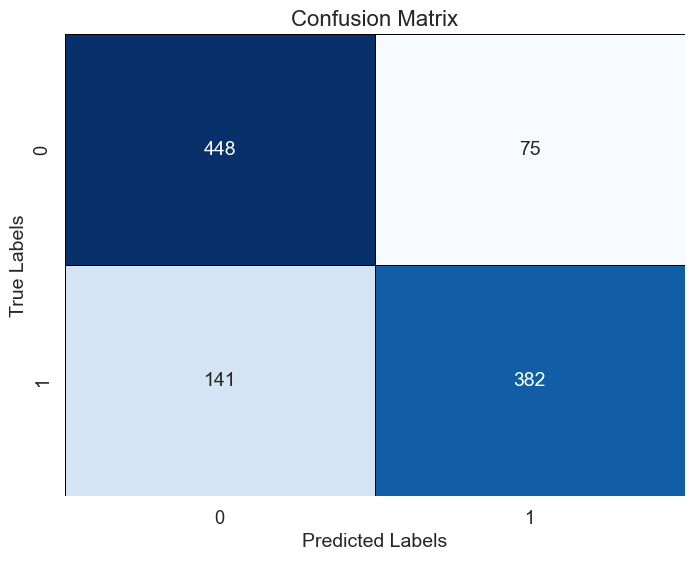

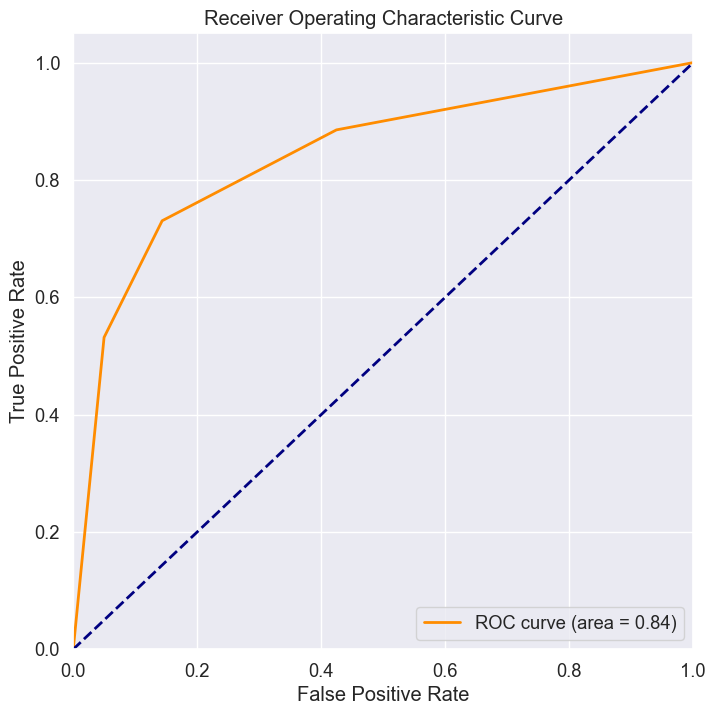

In [37]:
model_knn_2 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
model_knn_2.fit(X_train, y_train)

y_test_pred_knn_2 = model_knn_2.predict(X_test)

y_train_pred_knn_2 = model_knn_2.predict(X_train)

train_accuracy = model_knn_2.score(X_train, y_train)
test_accuracy = model_knn_2.score(X_test, y_test)

train_accuracies.append(train_accuracy)
test_accuracies.append(test_accuracy)

print(f"Training Accuracy Score: {train_accuracy}")
print(f"Testing Accuracy Score: {test_accuracy}")

print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_knn_2))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred_knn_2))

# Print confusion matrix
conf_matrix_knn_2 = confusion_matrix(y_test, y_test_pred_knn_2)
plot_confusion_matrix(conf_matrix_knn_2)

# Get predicted probabilities for positive class
y_test_prob_knn_2 = model_knn_2.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_knn_3, tpr_knn_3, _ = roc_curve(y_test, y_test_prob_knn_2)
roc_auc = auc(fpr_knn_3, tpr_knn_3)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_knn_3, tpr_knn_3, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

<h2>RandomForest Classifier</h2>

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Validation Accuracy for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}: 0.8066985645933015
Validation Accuracy for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}: 0.8114832535885167
Validation Accuracy for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}: 0.8143540669856459
Validation Accuracy for {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}: 0.817464114832536
Validation Accuracy for {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 50}: 0.8076555023923444
Validation Accuracy for {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}: 0.8117224880382775
Validation Accuracy for {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 150}: 0.8160287081339714
Validation Accuracy for {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 200}: 0.81244019138756
Validation Accuracy for {'max_depth': None, 'min_samples_split': 6, 'n_

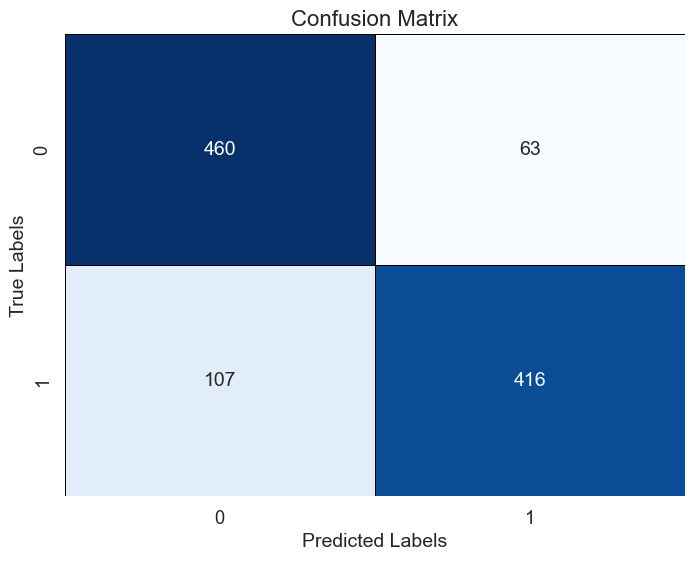

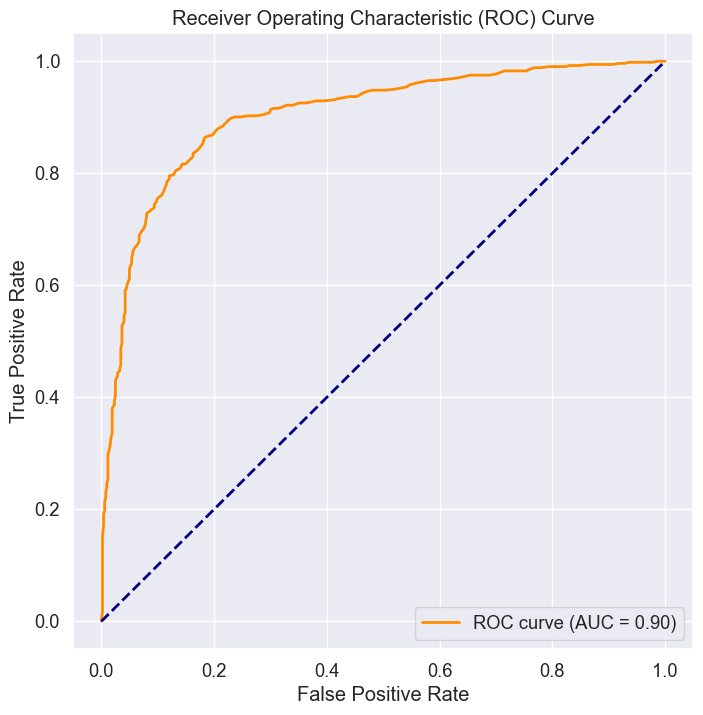

In [38]:
model_rf = RandomForestClassifier(random_state=80)
model_rf.fit(X_train, y_train)

# Step 1: Tune hyperparameters using cross-validation on the training set
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=80), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Print the validation accuracy for each hyperparameter combination
cv_results = grid_search_rf.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Validation Accuracy for {params}: {mean_score}")

# Print the best hyperparameters and corresponding accuracy
best_params_rf = grid_search_rf.best_params_
best_accuracy_rf = grid_search_rf.best_score_
print("\nBest Hyperparameters:", best_params_rf)
print("Validation Accuracy:", best_accuracy_rf)

# Step 2: Evaluate the model on the testing set
best_rf_model = RandomForestClassifier(random_state=80, **best_params_rf)
best_rf_model.fit(X_train, y_train)

y_training_pred_rf = best_rf_model.predict(X_train)
y_testing_pred_rf = best_rf_model.predict(X_test)

train_accuracy = best_rf_model.score(X_train, y_train)
test_accuracy = best_rf_model.score(X_test, y_test)

train_accuracies.append(train_accuracy)
test_accuracies.append(test_accuracy)

print(f"Training Accuracy Score: {train_accuracy}")
print(f"Testing Accuracy Score: {test_accuracy}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_testing_pred_rf))

# Print confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_testing_pred_rf)
plot_confusion_matrix(conf_matrix_rf)

# Step 3: Plot the ROC curve
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<h2>SVC Classifier</h2>

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}: 0.738755980861244
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}: 0.7492822966507177
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}: 0.7569377990430624
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}: 0.7492822966507177
Validation Accuracy for {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}: 0.738755980861244
Validation Accuracy for {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}: 0.7181818181818181
Validation Accuracy for {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}: 0.6375598086124403
Validation Accuracy for {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}: 0.7181818181818181
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}: 0.738755980861244
Validation Accuracy for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}: 0.7492822966507177
Validation Accuracy for {'C': 0.1,

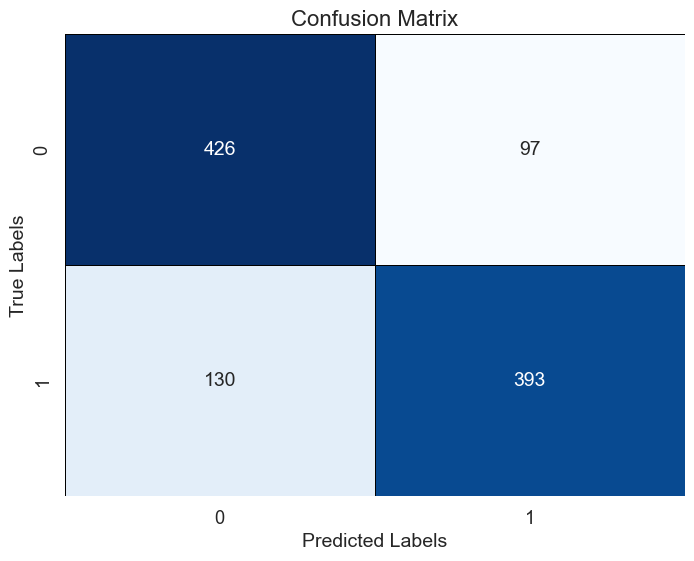

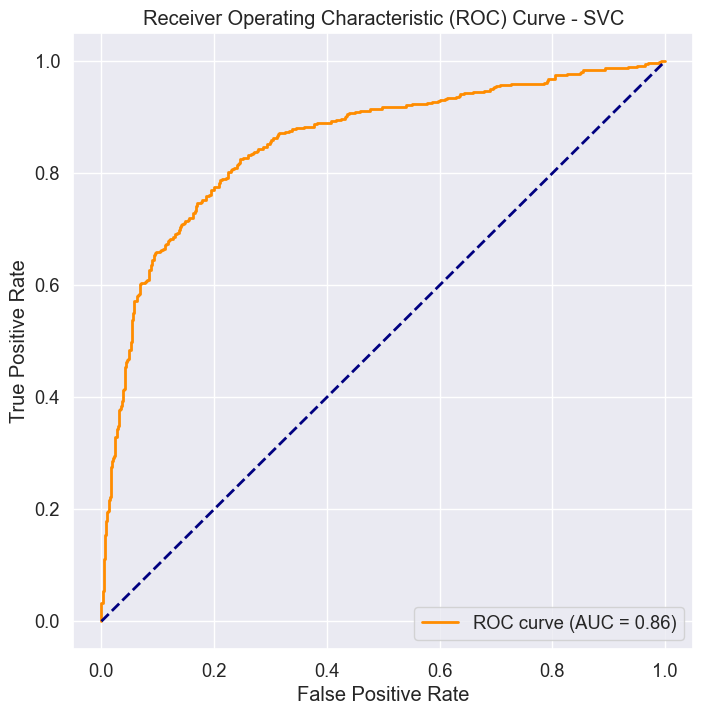

In [39]:
model_svc = SVC(random_state=80)
model_svc.fit(X_train, y_train)

# Step 4: Tune hyperparameters using cross-validation on the training set
param_grid_svc = {
    'C': [0.1, 1, 10, 0.01],
    'kernel': ['linear', 'rbf', 'poly', 'rbf'],
    'gamma': ['scale', 'auto', 'scale', 0.1]
}

grid_search_svc = GridSearchCV(SVC(random_state=80), param_grid_svc, cv=5, scoring='accuracy', verbose=1)
grid_search_svc.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
best_params_svc = grid_search_svc.best_params_
best_accuracy_svc = grid_search_svc.best_score_

# Print the validation accuracy for each hyperparameter combination
cv_results_svc = grid_search_svc.cv_results_
for mean_score, params in zip(cv_results_svc['mean_test_score'], cv_results_svc['params']):
    print(f"Validation Accuracy for {params}: {mean_score}")

print("\nBest Hyperparameters:", best_params_svc)
print("Validation Accuracy:", best_accuracy_svc)

# Step 6: Evaluate the model on the testing set
best_svc_model = SVC(random_state=80, **best_params_svc)
best_svc_model.fit(X_train, y_train)

y_training_pred_svc = best_svc_model.predict(X_train)
y_testing_pred_svc = best_svc_model.predict(X_test)

train_accuracy = best_svc_model.score(X_train, y_train)
test_accuracy = best_svc_model.score(X_test, y_test)

train_accuracies.append(train_accuracy)
test_accuracies.append(test_accuracy)

print(f"Training Accuracy Score: {train_accuracy}")
print(f"Testing Accuracy Score: {test_accuracy}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_testing_pred_svc))

# Print confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_testing_pred_svc)
plot_confusion_matrix(conf_matrix_svc)

# Step 7: Plot the ROC curve
y_pred_prob_svc = best_svc_model.decision_function(X_test)  # Decision function scores

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(8, 8))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVC')
plt.legend(loc='lower right')
plt.show()

In [40]:
models_summary = pd.DataFrame(
        {
            'Model Name' : ['KNN_1', 'KNN_3', 'Random Forest', 'SVC'], 
            'Train Accuracy' : train_accuracies, 
            'Test Accuracy' : test_accuracies,
        }
    )

In [41]:
def plot_model_summary(
    model_summary, 
    figsize=(20, 14), 
    dpi=300,
):

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    width = 0.4

    x_ticks_location = np.arange(len(model_summary['Model Name']))


    test_plot = ax.bar(
        x_ticks_location, 
        model_summary['Test Accuracy'], 
        width, 
        color="deepskyblue", 
        edgecolor="orangered", 
        align='center', 
        linewidth=3, 
        label='Test Accuracy', 
        hatch=("/"),
    )


    train_plot = ax.bar(
        x_ticks_location + width, 
        model_summary['Train Accuracy'], 
        width, color="darkorange", 
        edgecolor="royalblue", 
        align='center', 
        linewidth=3, 
        label='Train Accuracy',
    )


    ax.set_title("Models Accuracy", fontsize=28, pad=25)

    ax.set_xticks(x_ticks_location + width / 2)
    ax.set_xticklabels(model_summary['Model Name'], fontsize=25)

    ax.set_xlabel('Model', fontsize=28, labelpad=20)

    plt.yticks(fontsize=25)
    ax.set_ylabel('Accuracy', fontsize=28, labelpad=20)

    ax.grid(which="both", axis="both", color="black", linewidth=0.8)

    ax.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize='xx-large', frameon=True, shadow=True, fancybox=True)

    fig.tight_layout()
    
    
    def label(plot):
        for patch in plot.patches:
            width = patch.get_width()
            height = patch.get_height()
            x, y = patch.get_xy()
            plt.text(
                x=x + width / 2, 
                y=y + height * 1.001,
                s=round(height, 3),
                ha='center',
                va="bottom",
                fontsize='xx-large',
            )

    label(test_plot)
    label(train_plot)

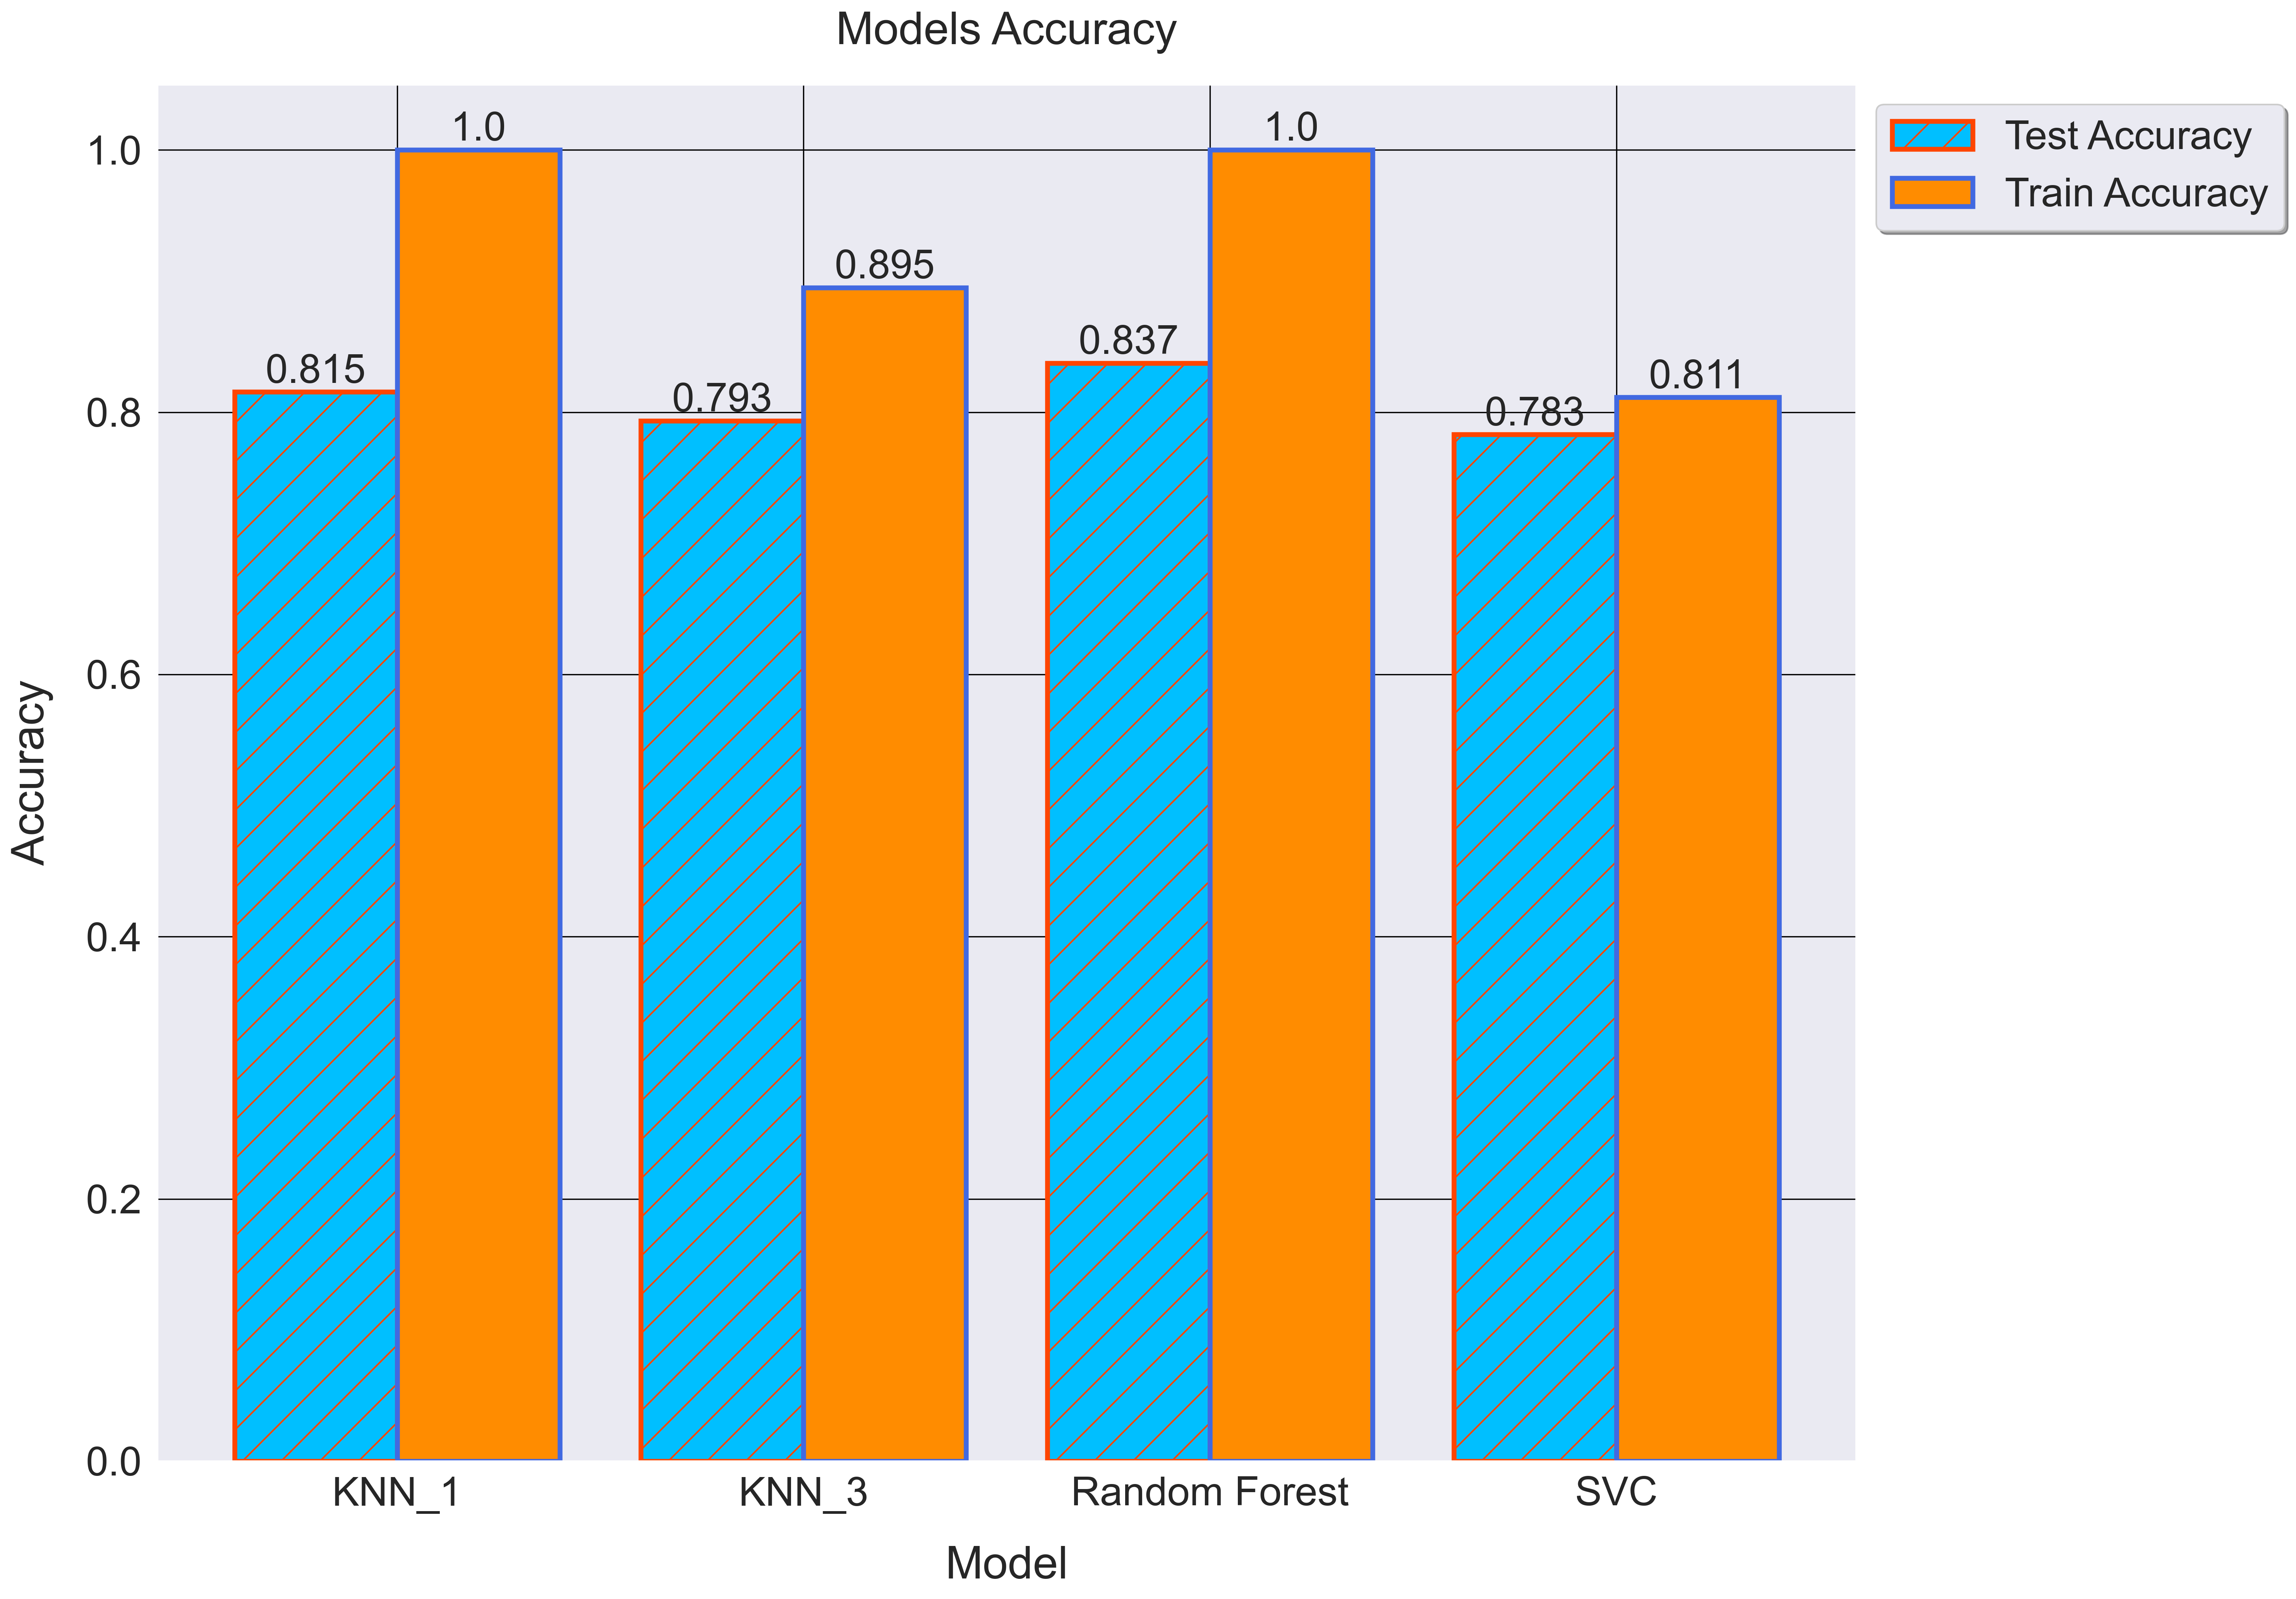

In [42]:
plot_model_summary(
    model_summary=models_summary, 
    figsize=(20, 14), 
    dpi=300, 
)

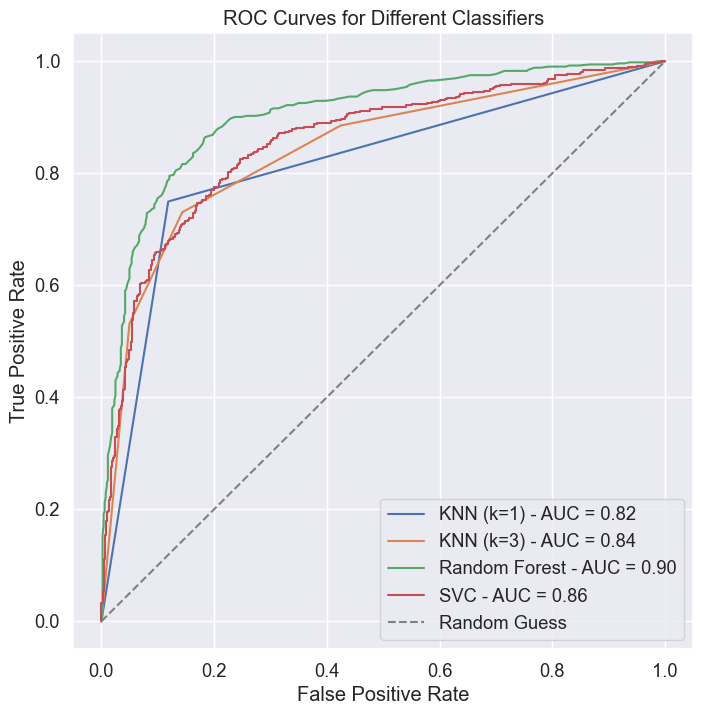

In [43]:
# Calculate AUC for each classifier
knn_k1_auc = auc(fpr_knn_1, tpr_knn_1)
knn_k3_auc = auc(fpr_knn_3, tpr_knn_3)
rf_auc = auc(fpr_rf, tpr_rf)
svc_auc = auc(fpr_svc, tpr_svc)

# Plot ROC curves
plt.figure(figsize=(8, 8))

plt.plot(fpr_knn_1, tpr_knn_1, label=f'KNN (k=1) - AUC = {knn_k1_auc:.2f}')
plt.plot(fpr_knn_3, tpr_knn_3, label=f'KNN (k=3) - AUC = {knn_k3_auc:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest - AUC = {rf_auc:.2f}')
plt.plot(fpr_svc, tpr_svc, label=f'SVC - AUC = {svc_auc:.2f}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.grid(True)
plt.show()

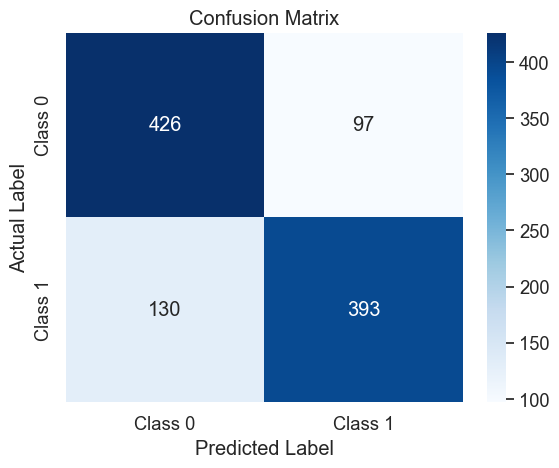

Misclassified Instances:
      Actual Label  Predicted Label
81               1                0
1165             1                0
708              0                1
679              1                0
1178             1                0
...            ...              ...
4009             0                1
1886             1                0
980              0                1
153              1                0
913              1                0

[227 rows x 2 columns]


In [44]:
y_pred = best_svc_model.predict(X_test)

# Compare predictions with actual labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# Identify misclassified instances
misclassified_indices = (y_pred != y_test)
misclassified_instances = X_test[misclassified_indices]
misclassified_actual_labels = y_test[misclassified_indices]
misclassified_predicted_labels = y_pred[misclassified_indices]

misclassified_data = pd.DataFrame({
    'Actual Label': misclassified_actual_labels,
    'Predicted Label': misclassified_predicted_labels
})

# Display the misclassified instances as a table
print("Misclassified Instances:")
print(misclassified_data)